<a href="https://colab.research.google.com/github/xazhu9/AIPI-590/blob/main/Assignment%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 590 - XAI \ Assignment #03

Description: Apply linear, logistic, and GAM regression on Churn problem,make comparision for their strength and weakness, and pick one that is fit for understanding churning problem.

https://colab.research.google.com/github/xazhu9/AIPI-590/blob/main/Assignment%203.ipynb#scrollTo=32qOv_8XVUqy

In [1]:
pip install pygam

Load Package

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import statsmodels.api as sm
from pygam import LinearGAM, LogisticGAM, s, f
from scipy.stats import skew, kurtosis
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV

Functions

In [3]:
def logit(p):
    return np.log(p / (1 - p))

def check_linearity_numerical(df, col, target='Churn'):
    df['bin'] = pd.qcut(df[col], q=10, duplicates='drop')
    bin_mean = df.groupby('bin')[target].mean()
    bin_mean = bin_mean[(bin_mean > 0) & (bin_mean < 1)]
    log_odds = logit(bin_mean)

    plt.figure(figsize=(10, 6))
    bin_centers = df.groupby('bin')[col].mean()
    plt.plot(bin_centers, log_odds, marker='o')
    plt.title(f'Logit(p) vs {col}')
    plt.xlabel(col)
    plt.ylabel('Logit(p)')
    plt.show()

def check_linearity_categorical(df, col, target='Churn'):
    cat_mean = df.groupby(col)[target].mean()
    cat_mean = cat_mean[(cat_mean > 0) & (cat_mean < 1)]
    log_odds = logit(cat_mean)

    plt.figure(figsize=(10, 6))
    plt.bar(cat_mean.index.astype(str), log_odds)
    plt.title(f'Logit(p) vs {col}')
    plt.xlabel(col)
    plt.ylabel('Logit(p)')
    plt.xticks(rotation=45)
    plt.show()

1.EDA

Data analysis(Asked ChatGPT about EDA and assumption for different models, especially for GAM)

Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Missing Values after imputation:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


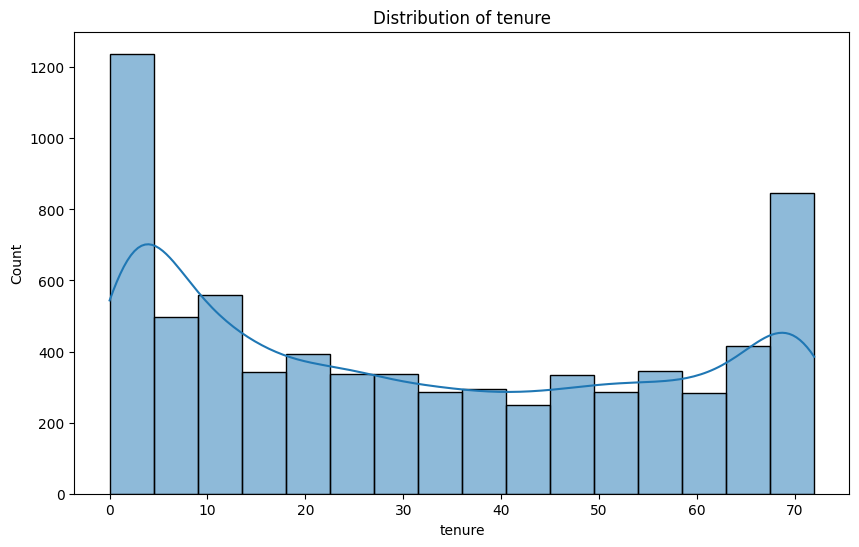

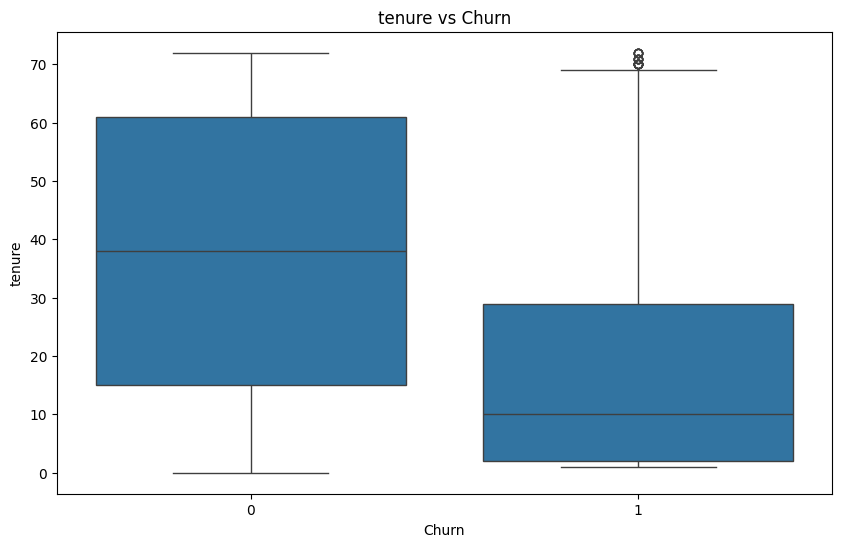

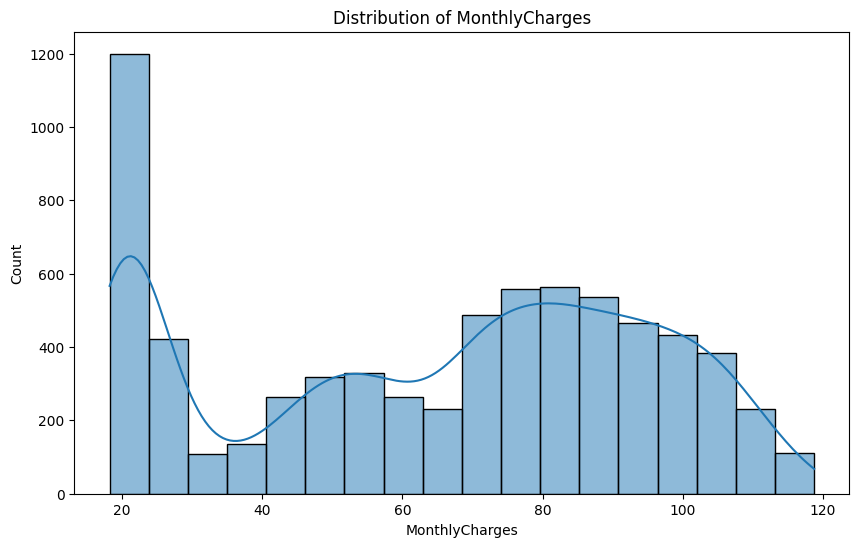

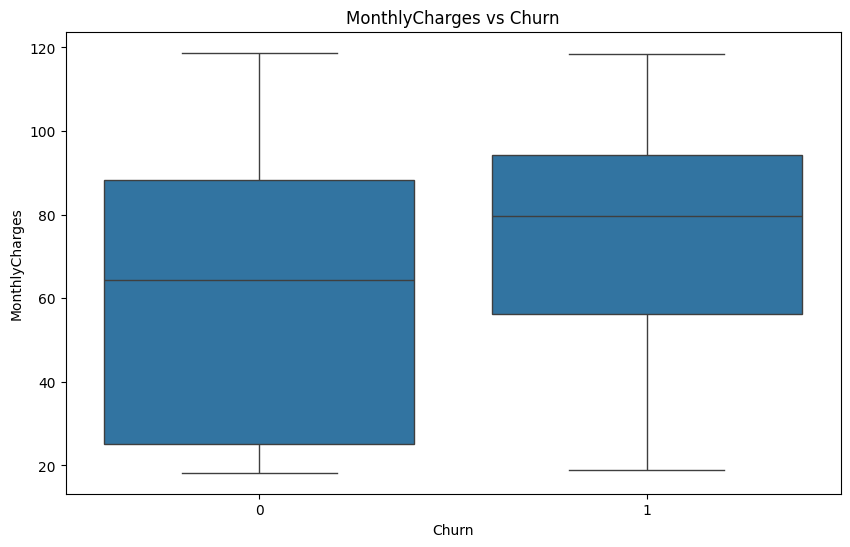

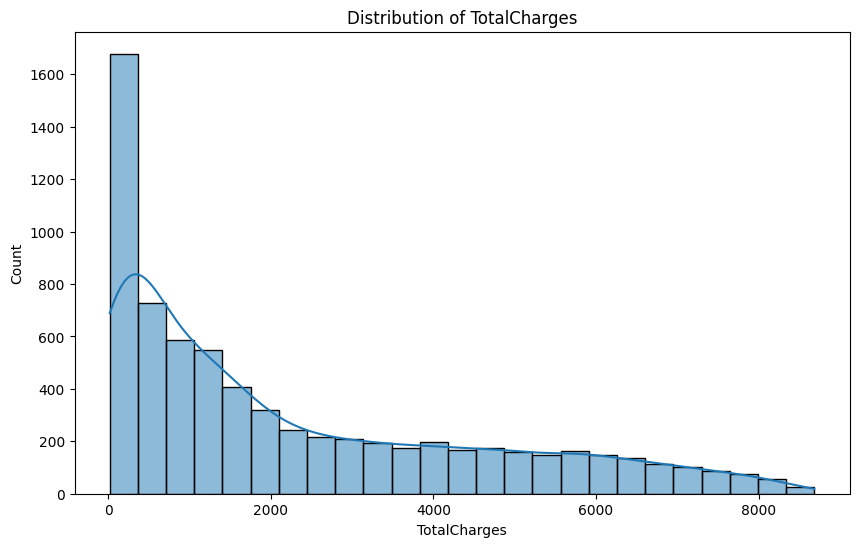

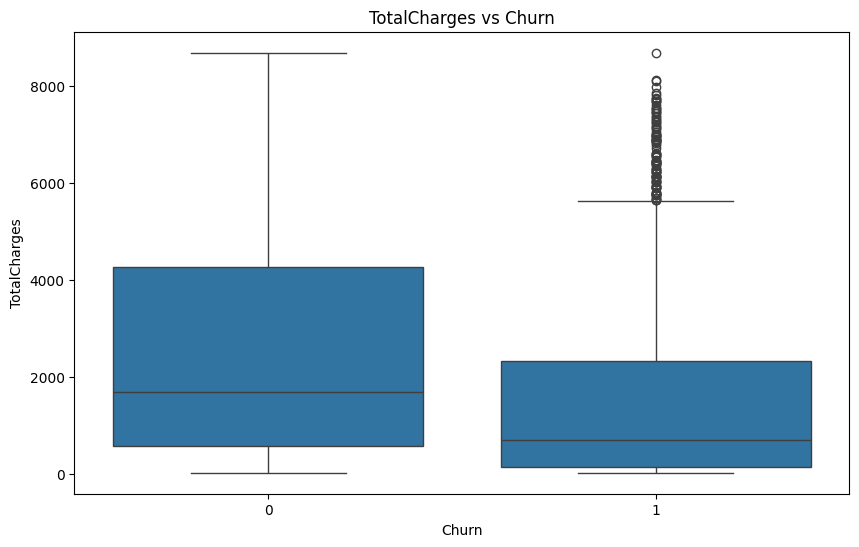

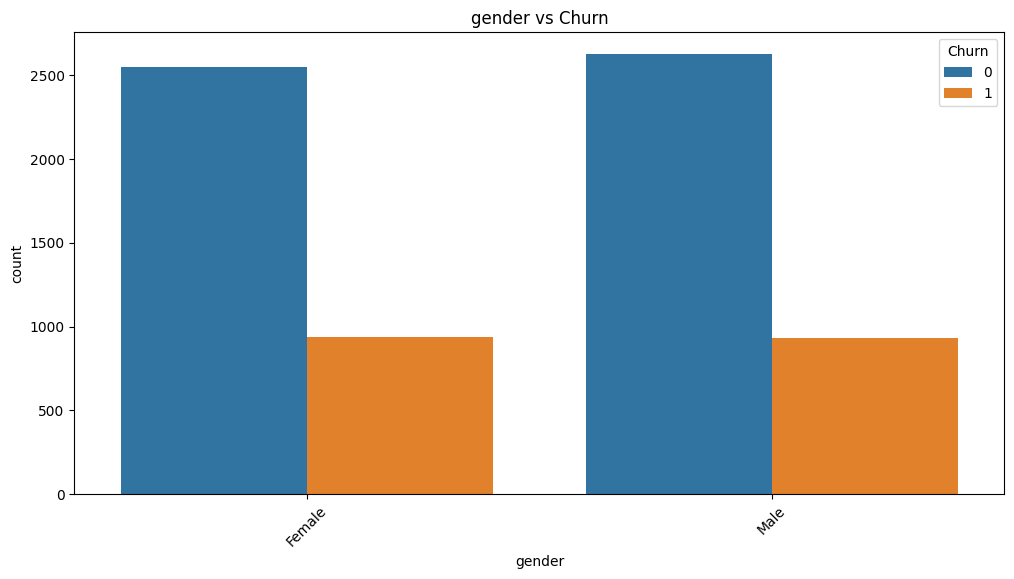

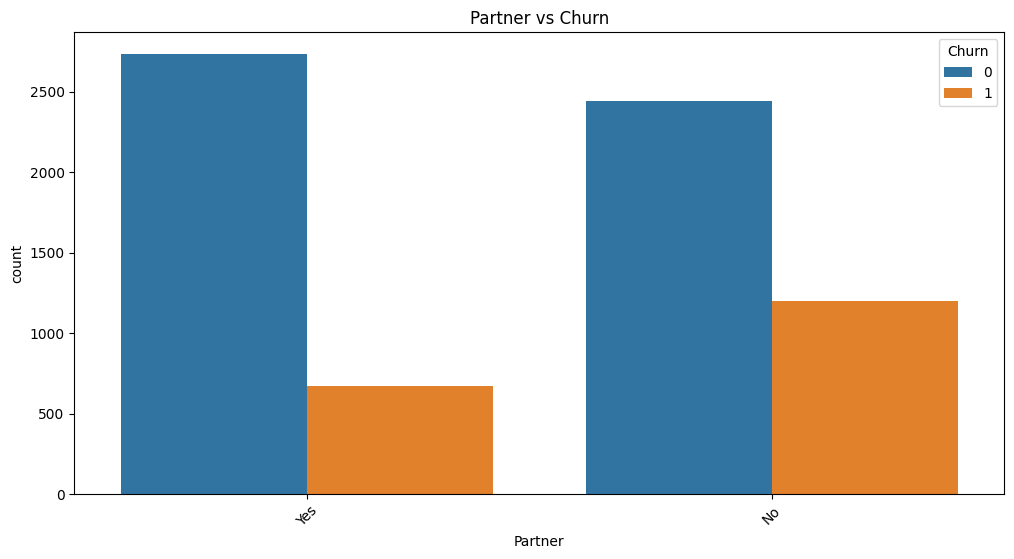

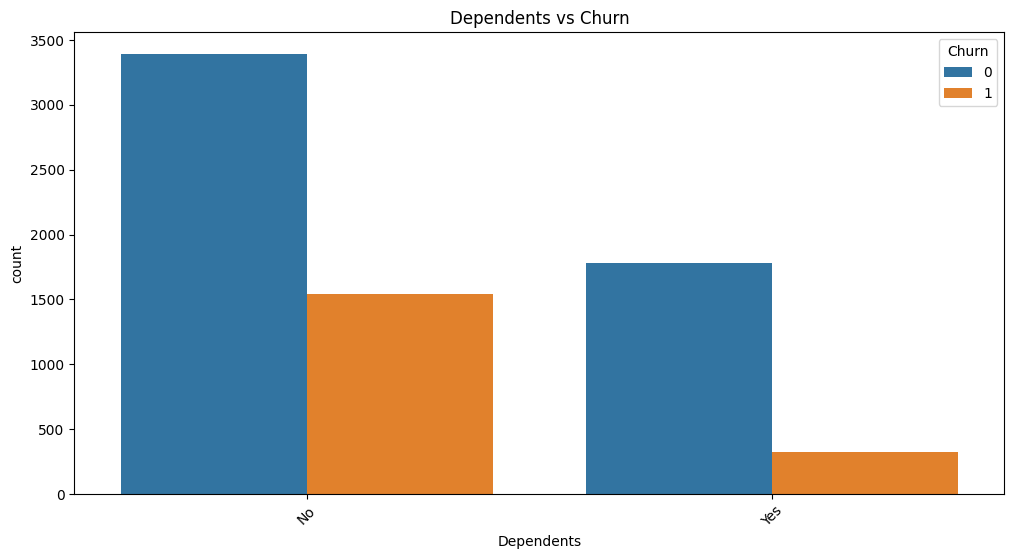

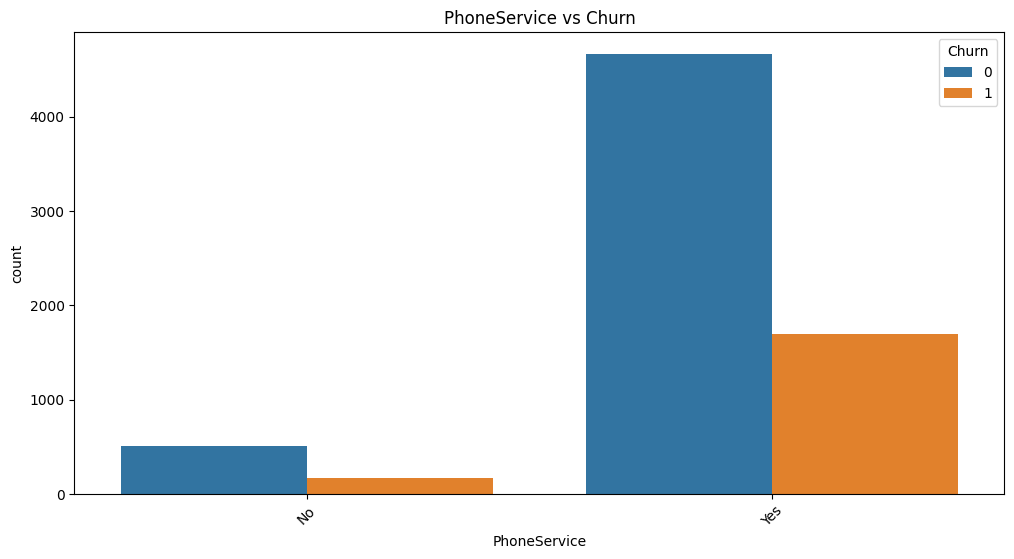

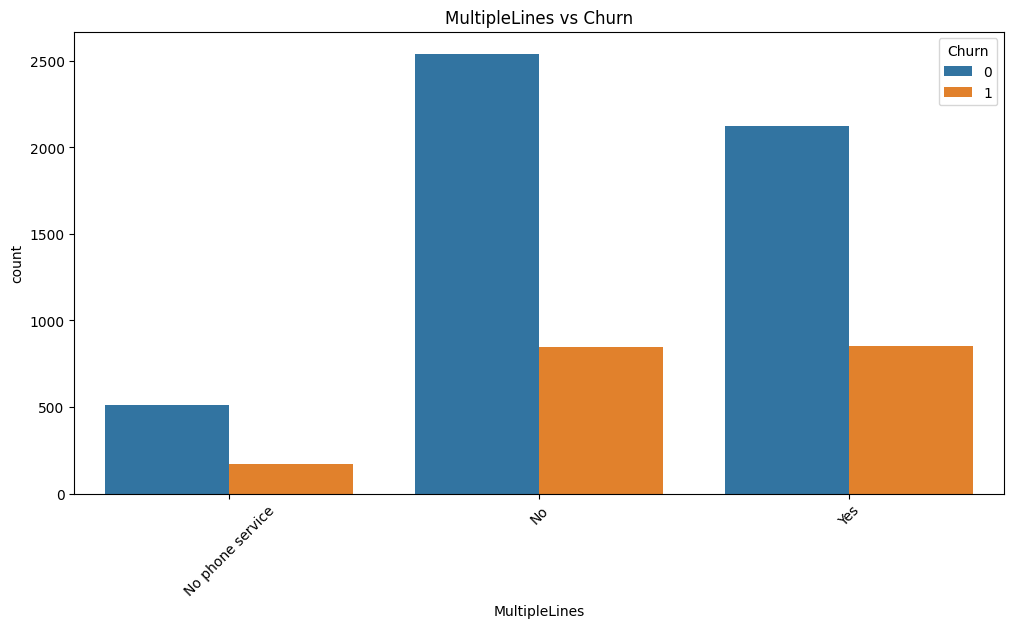

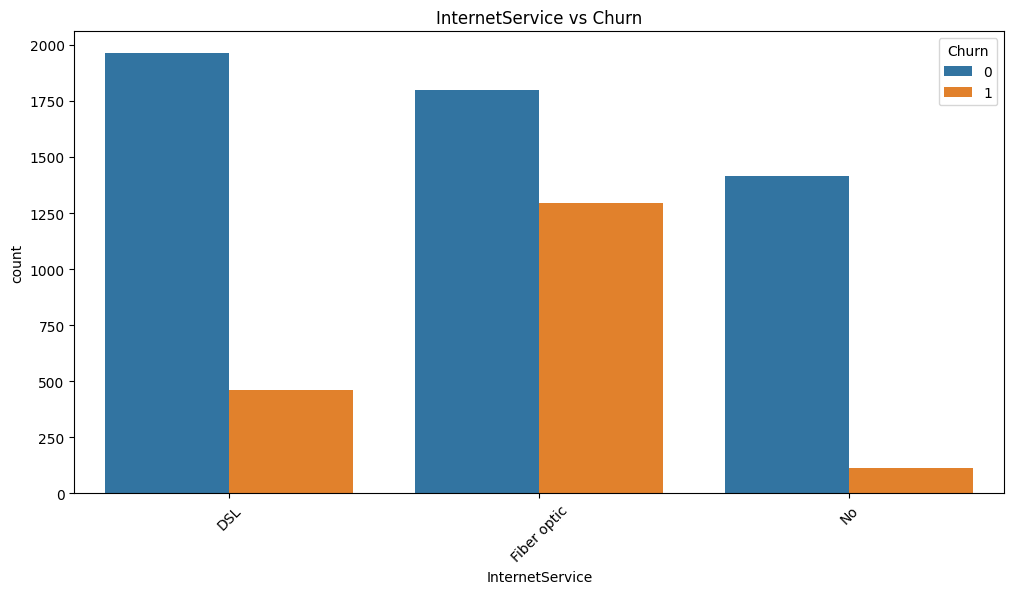

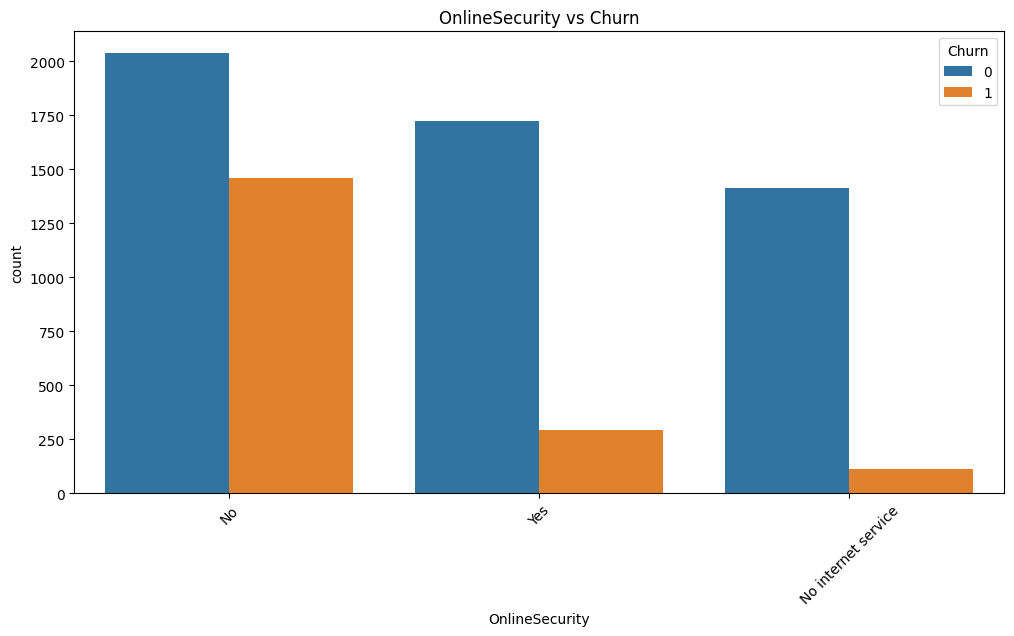

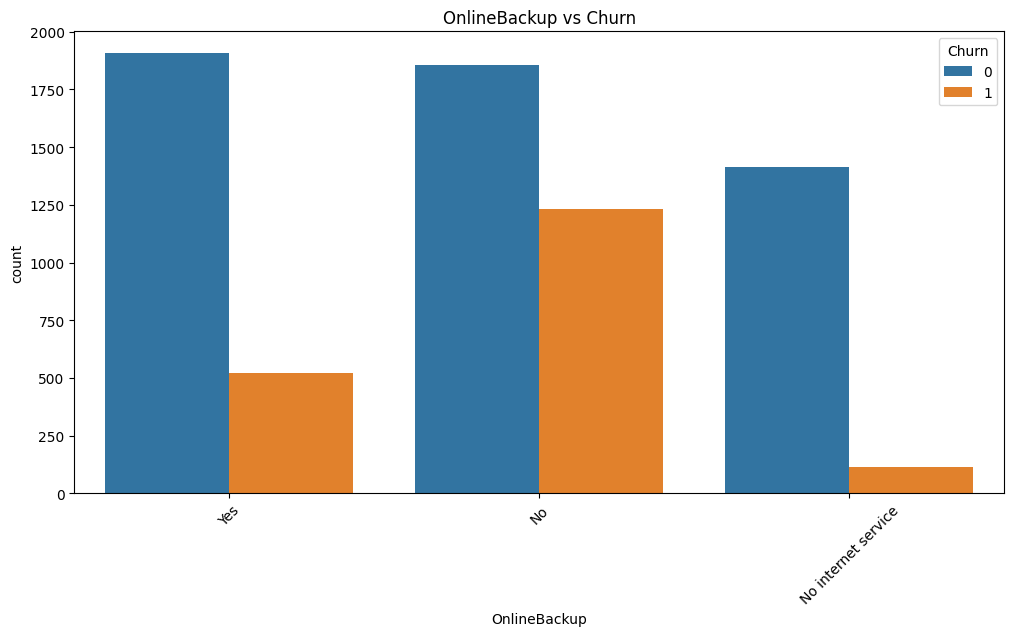

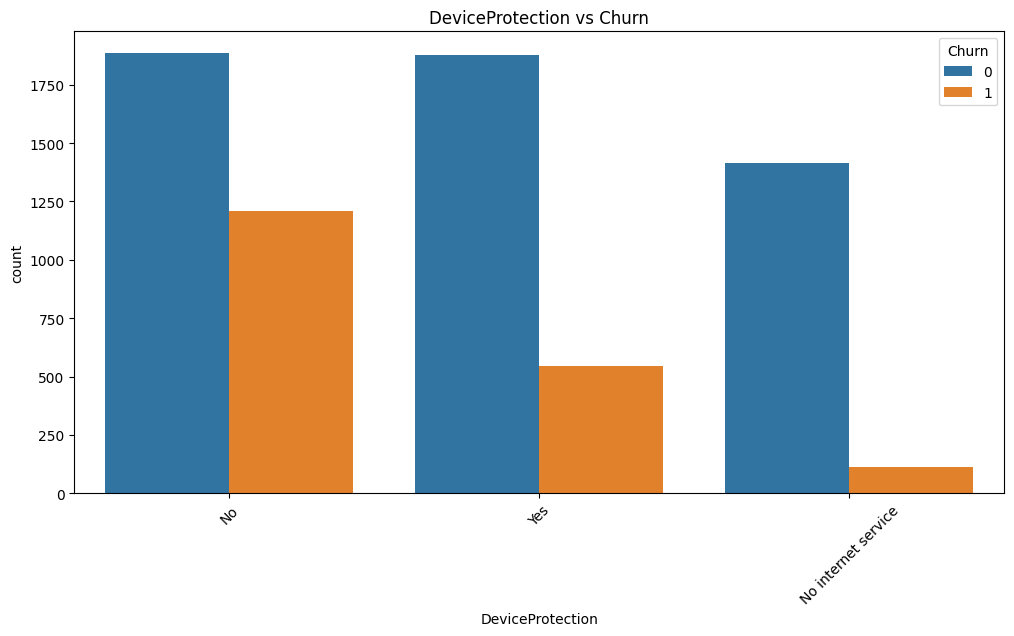

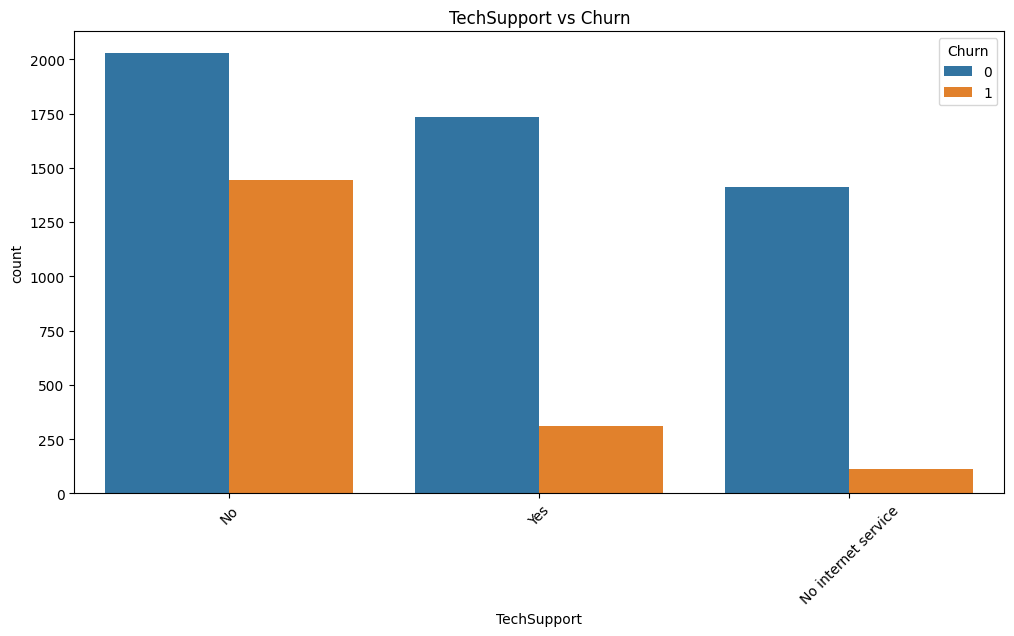

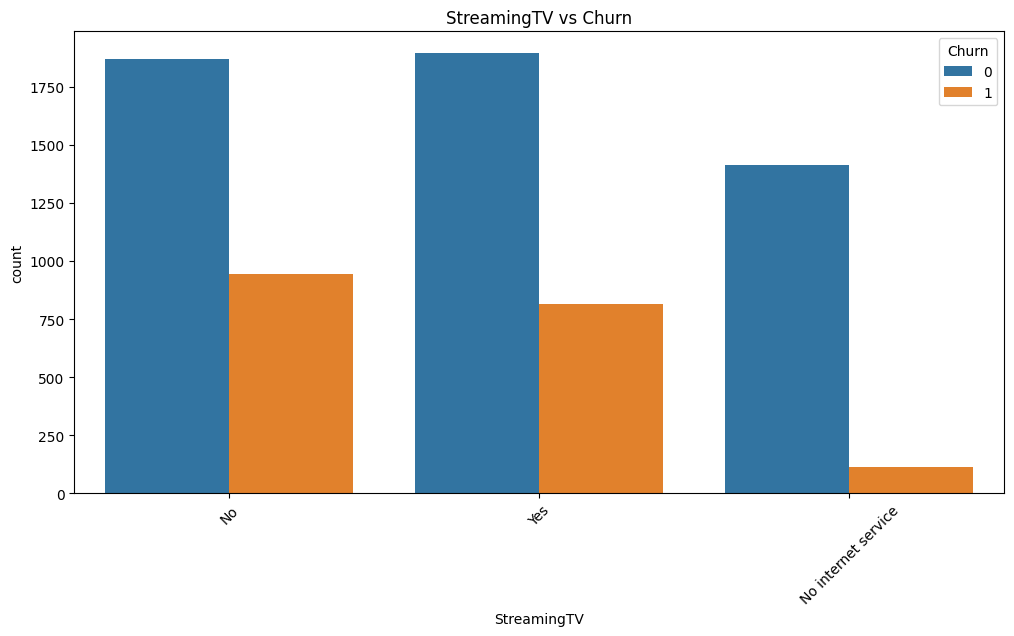

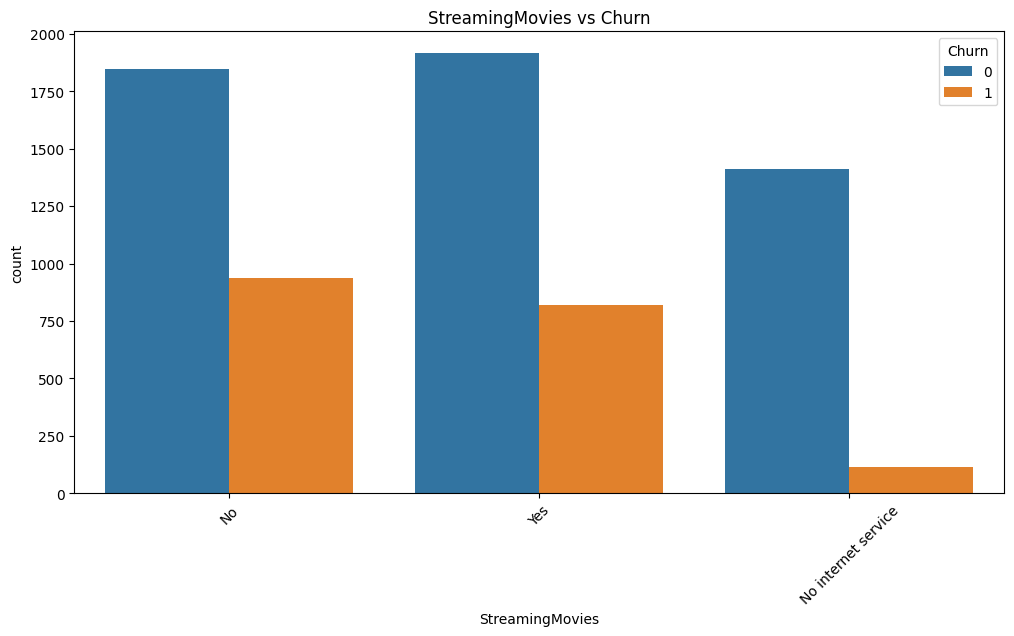

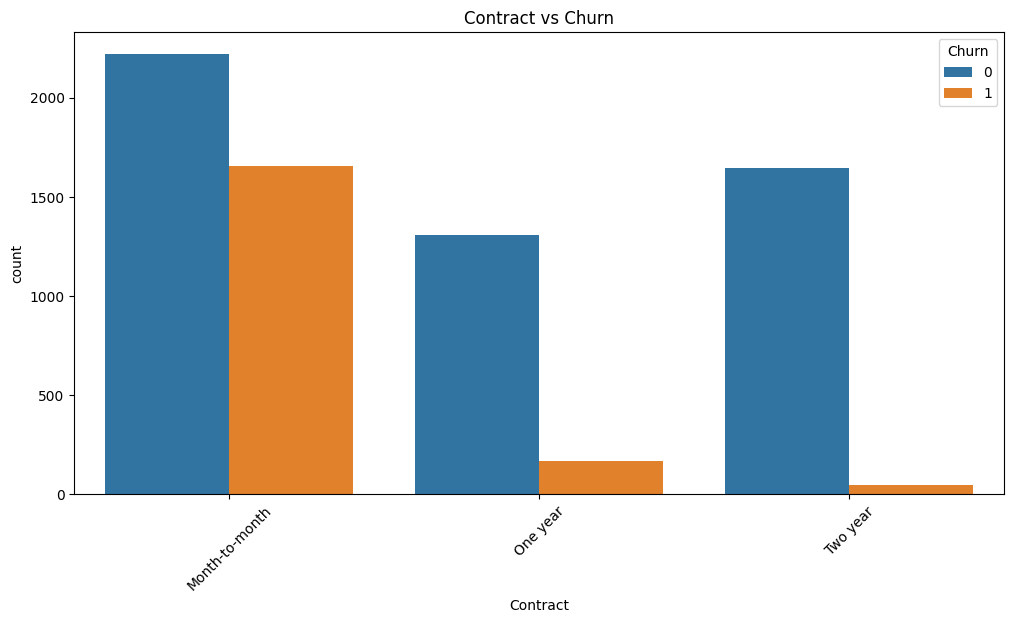

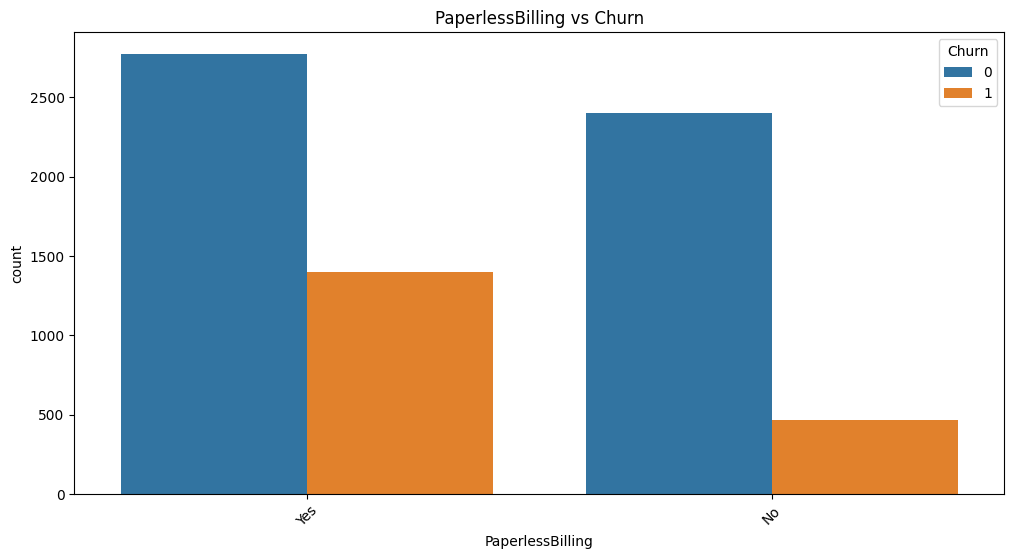

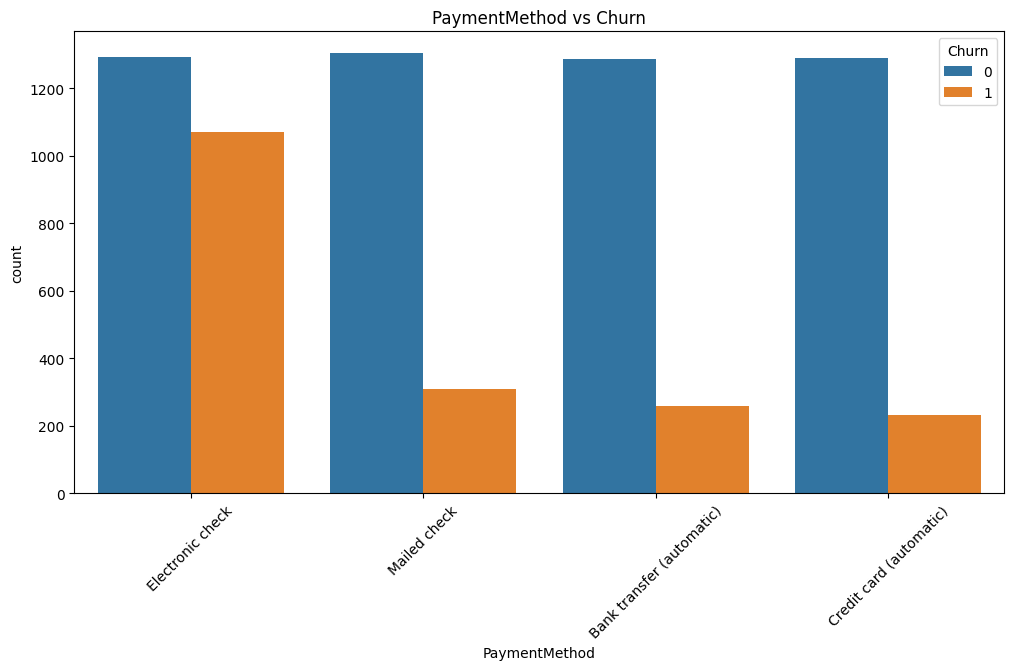

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


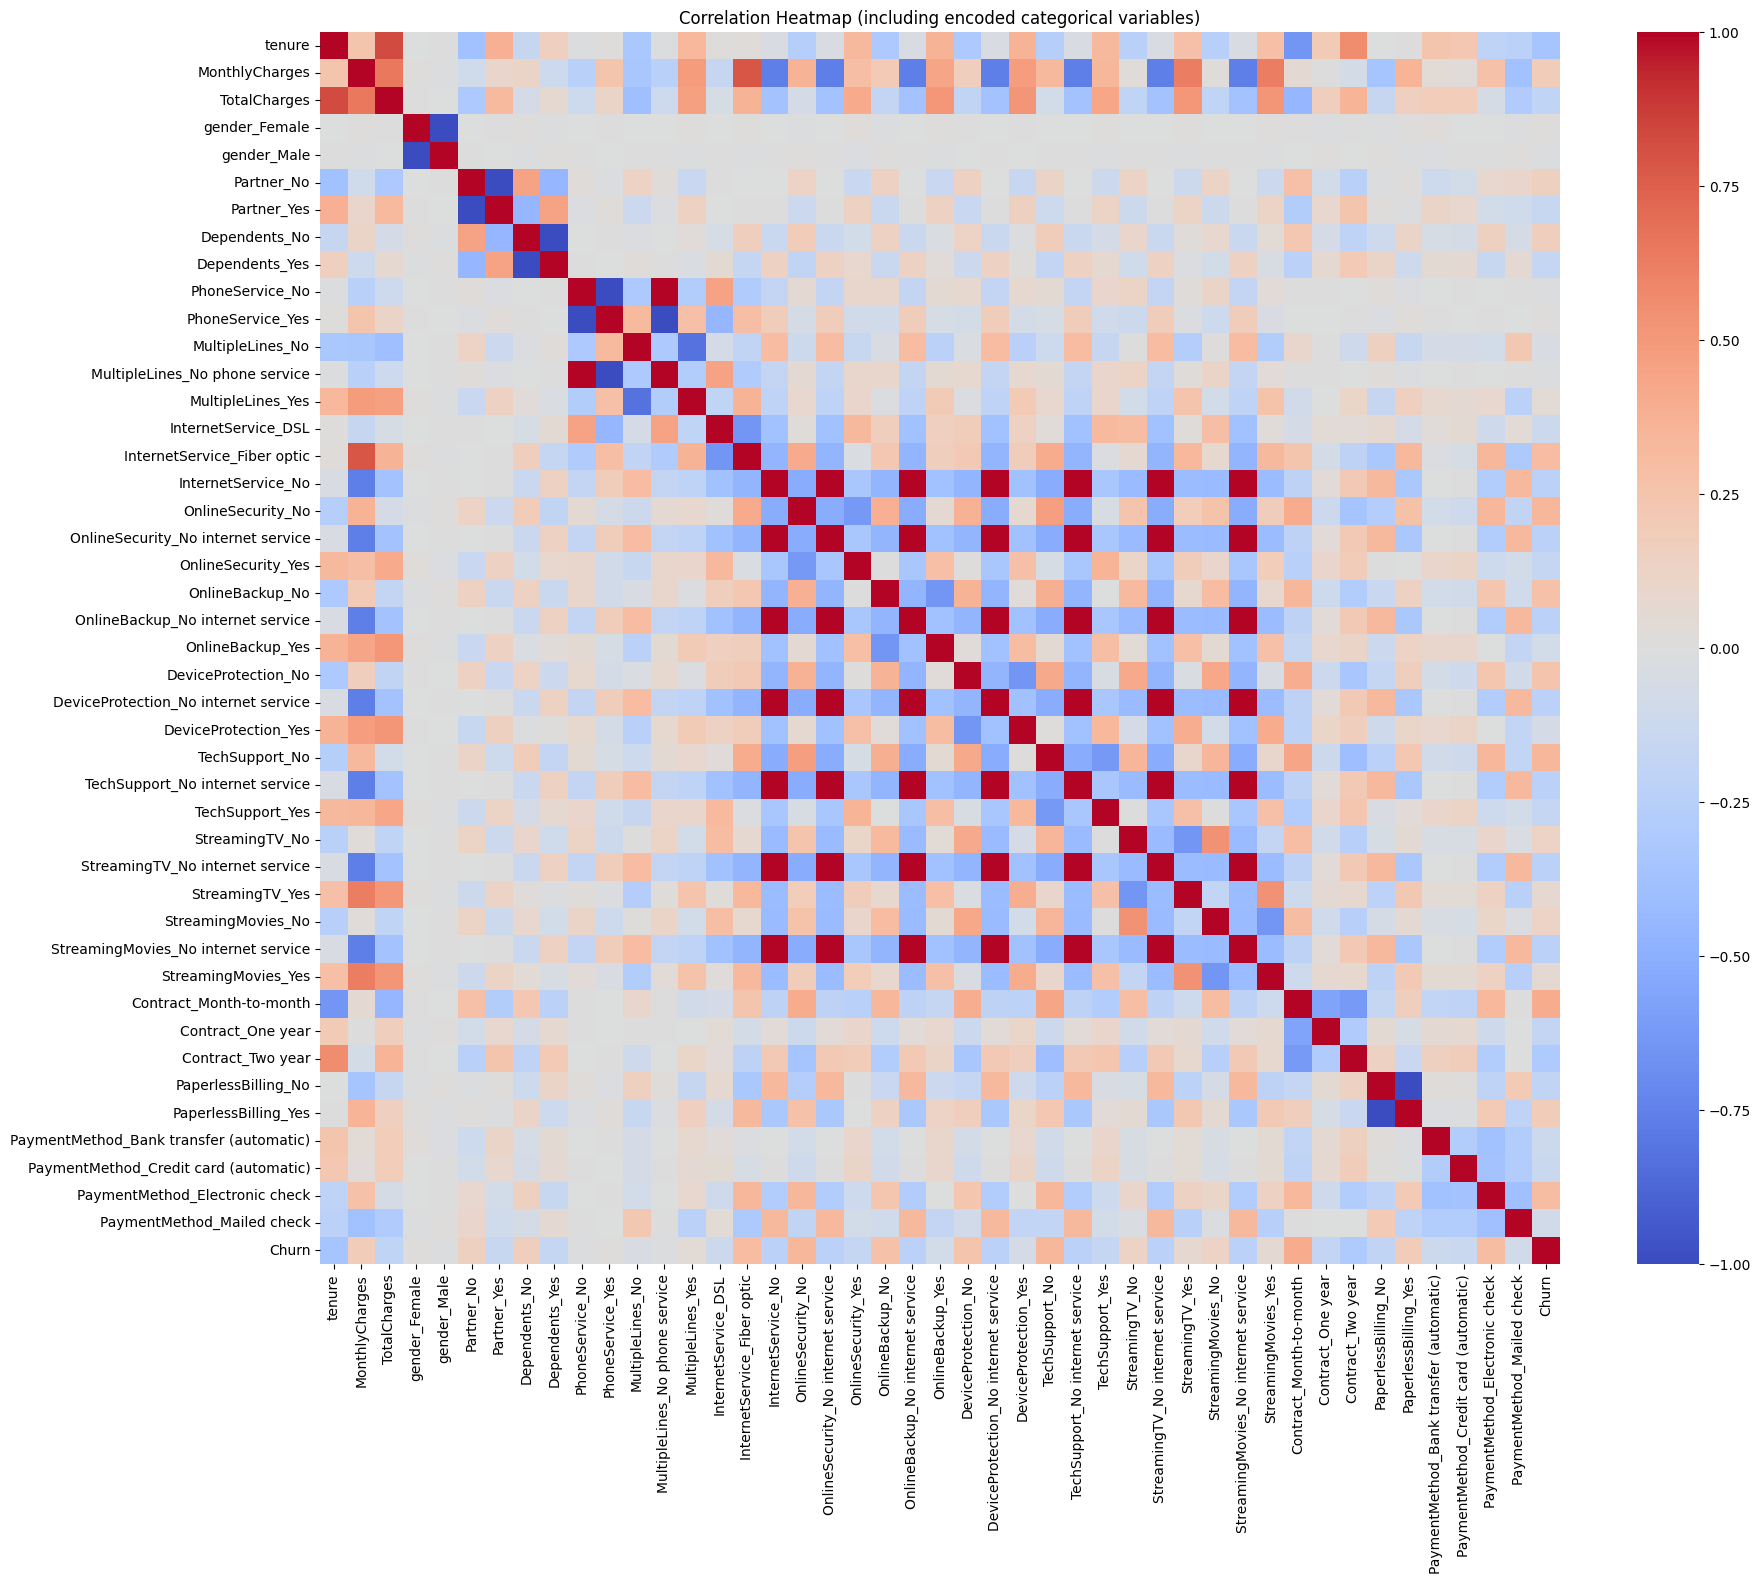

Top 10 correlations with Churn:
Churn                             1.000000
Contract_Month-to-month           0.405103
tenure                           -0.352229
OnlineSecurity_No                 0.342637
TechSupport_No                    0.337281
InternetService_Fiber optic       0.308020
Contract_Two year                -0.302253
PaymentMethod_Electronic check    0.301919
OnlineBackup_No                   0.268005
DeviceProtection_No               0.252481
Name: Churn, dtype: float64

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.81      1409


Confusion Matrix:
[[928 108]
 [148 225]]


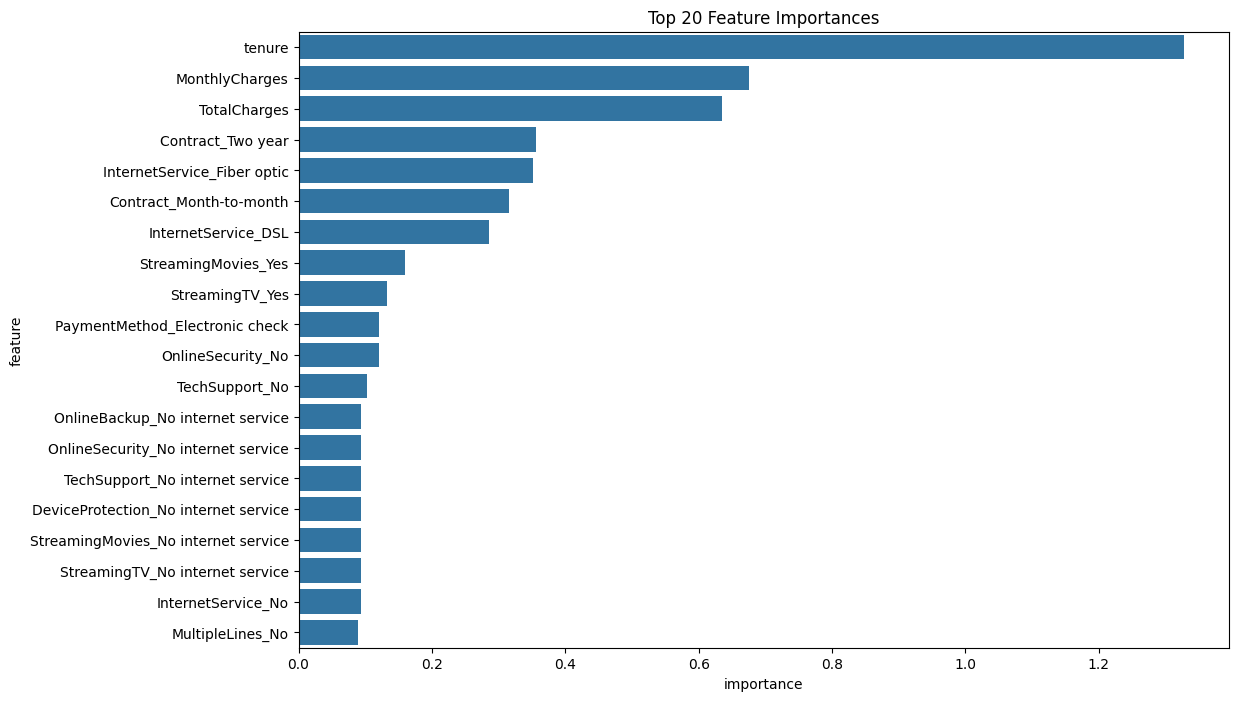


Variance Inflation Factors:
          feature       VIF
0          tenure  6.321802
1  MonthlyCharges  3.360371
2    TotalCharges  8.073814


In [4]:


# GitHub raw content URL
url = "https://raw.githubusercontent.com/xazhu9/AIPI-590/main/Assignment%203/WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Load from github
df = pd.read_csv(url)

# Checking for missing values
print("Missing Values:")
print(df.isnull().sum())

# Transform TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Transform Churn to Binary
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

# Identify numerical and categorical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'customerID']

# Impute missing values
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify that all missing values have been handled
print("\nMissing Values after imputation:")
print(df.isnull().sum())

# Numerical variables analysis
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

    # Box plot grouped by Churn
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} vs Churn')
    plt.show()

# Categorical variables analysis
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)
    plt.show()

# One-hot encoding for categorical variables
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Create a new dataframe with encoded variables
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names, index=df.index)

# Combine encoded categorical variables with numerical variables
combined_df = pd.concat([df[numerical_cols], encoded_df, df['Churn']], axis=1)

# Correlation analysis
correlation_matrix = combined_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (including encoded categorical variables)')
plt.show()

# Display top correlations with Churn
top_correlations = correlation_matrix['Churn'].sort_values(key=abs, ascending=False).head(10)
print("Top 10 correlations with Churn:")
print(top_correlations)

# Prepare data for machine learning
X = combined_df.drop('Churn', axis=1)
y = combined_df['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': abs(pipeline.named_steps['classifier'].coef_[0])
})

# Sort features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

# Calculate VIF for numerical variables
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_cols
vif_data["VIF"] = [variance_inflation_factor(df[numerical_cols].values, i) for i in range(len(numerical_cols))]

print("\nVariance Inflation Factors:")
print(vif_data)

Model Assumption Check

Clean NaN

Check for Linearity

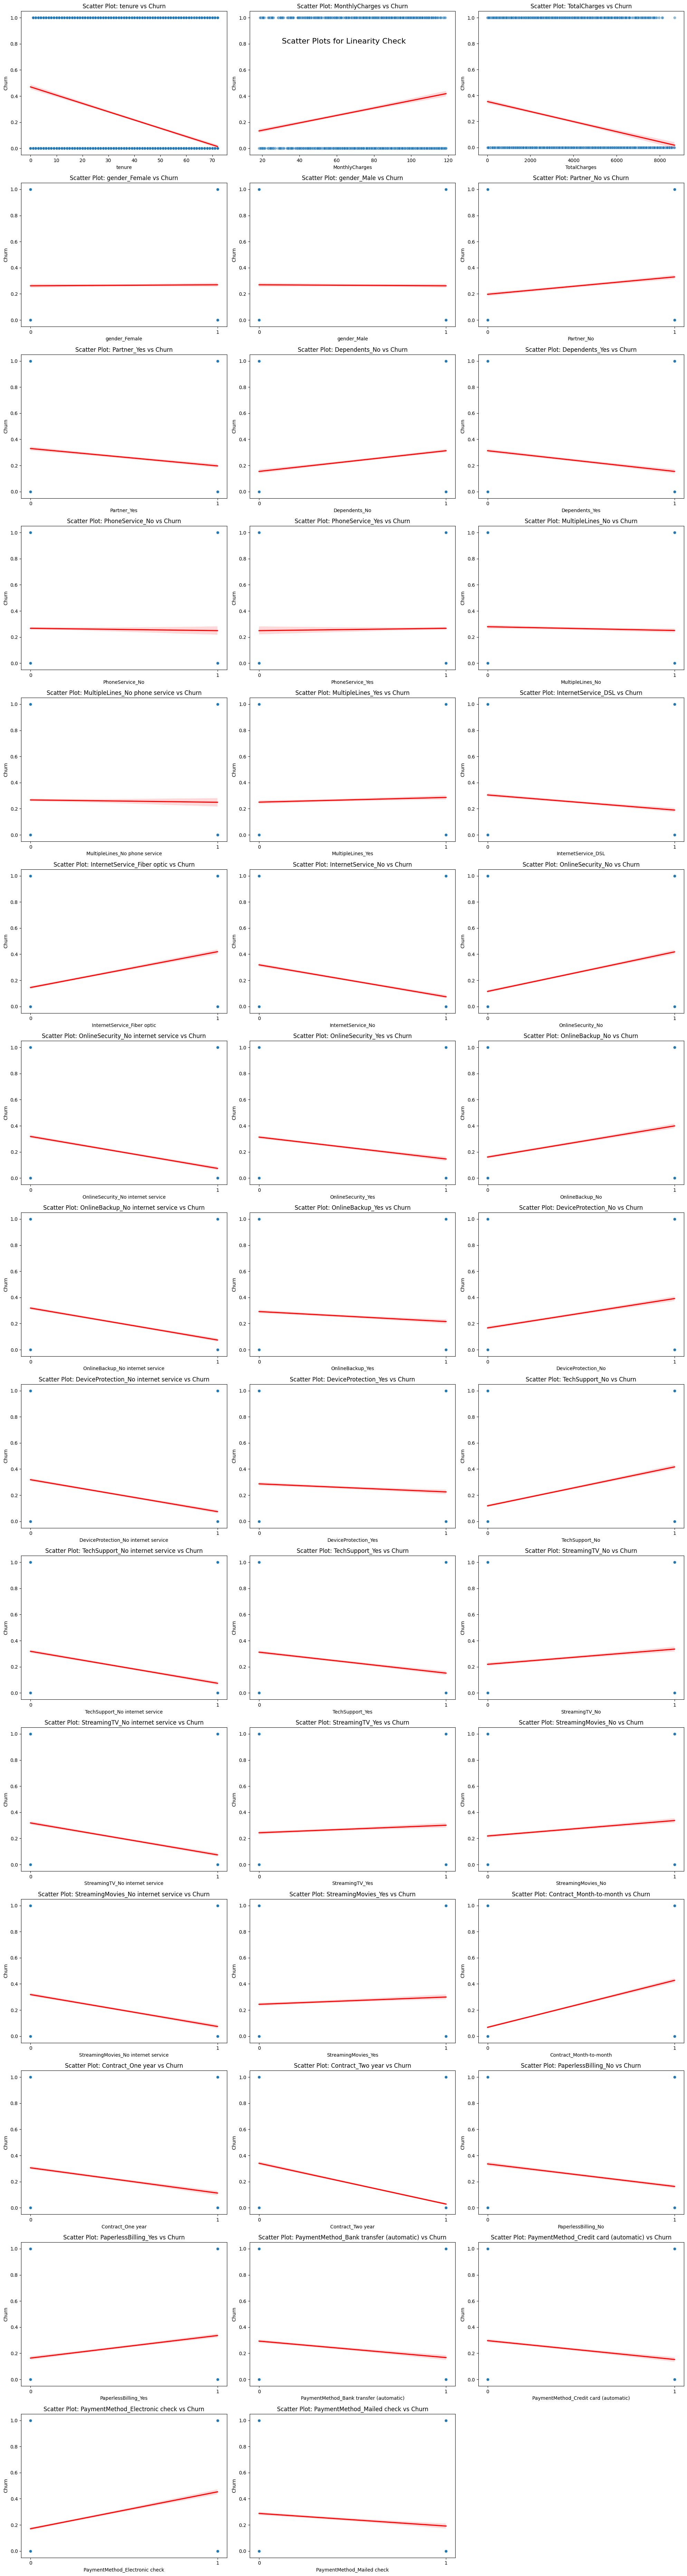


Correlations with Churn:
Contract_Month-to-month                    0.405103
tenure                                    -0.352229
OnlineSecurity_No                          0.342637
TechSupport_No                             0.337281
InternetService_Fiber optic                0.308020
Contract_Two year                         -0.302253
PaymentMethod_Electronic check             0.301919
OnlineBackup_No                            0.268005
DeviceProtection_No                        0.252481
StreamingTV_No internet service           -0.227890
TechSupport_No internet service           -0.227890
DeviceProtection_No internet service      -0.227890
OnlineBackup_No internet service          -0.227890
OnlineSecurity_No internet service        -0.227890
InternetService_No                        -0.227890
StreamingMovies_No internet service       -0.227890
TotalCharges                              -0.199037
MonthlyCharges                             0.193356
PaperlessBilling_Yes                  

In [5]:
# Ensure X contains all numerical variables and encoded categorical variables
X = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Churn']

# Calculate the required number of rows and columns
n_features = X.shape[1]
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create a figure large enough to accommodate all subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Scatter Plots for Linearity Check', fontsize=16)

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, column in enumerate(X.columns):
    sns.scatterplot(x=X[column], y=y, ax=axes[i], alpha=0.5)
    sns.regplot(x=X[column], y=y, ax=axes[i], scatter=False, color='red')
    axes[i].set_title(f'Scatter Plot: {column} vs Churn')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Churn')

    # Adjust x-axis ticks for binary variables
    if X[column].nunique() == 2:
        axes[i].set_xticks([0, 1])

# Hide any excess subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Calculate correlations with Churn for all features
correlations = X.apply(lambda x: x.corr(y))
print("\nCorrelations with Churn:")
print(correlations.sort_values(key=abs, ascending=False))

Doesn't fit linearity

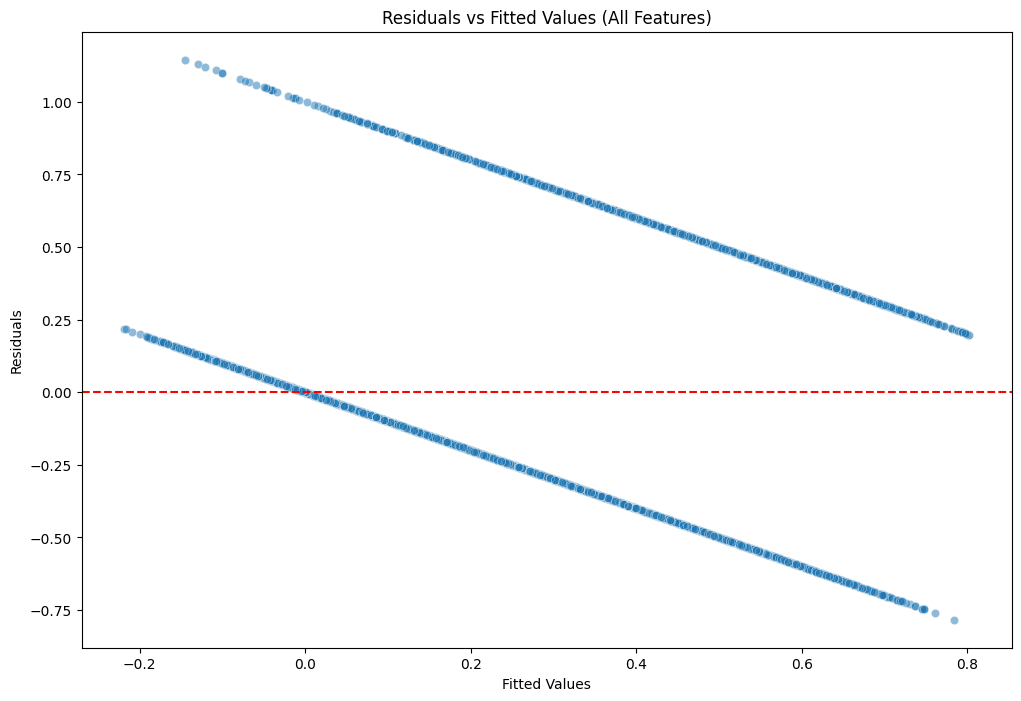

Durbin-Watson statistic: 2.0061120810412274


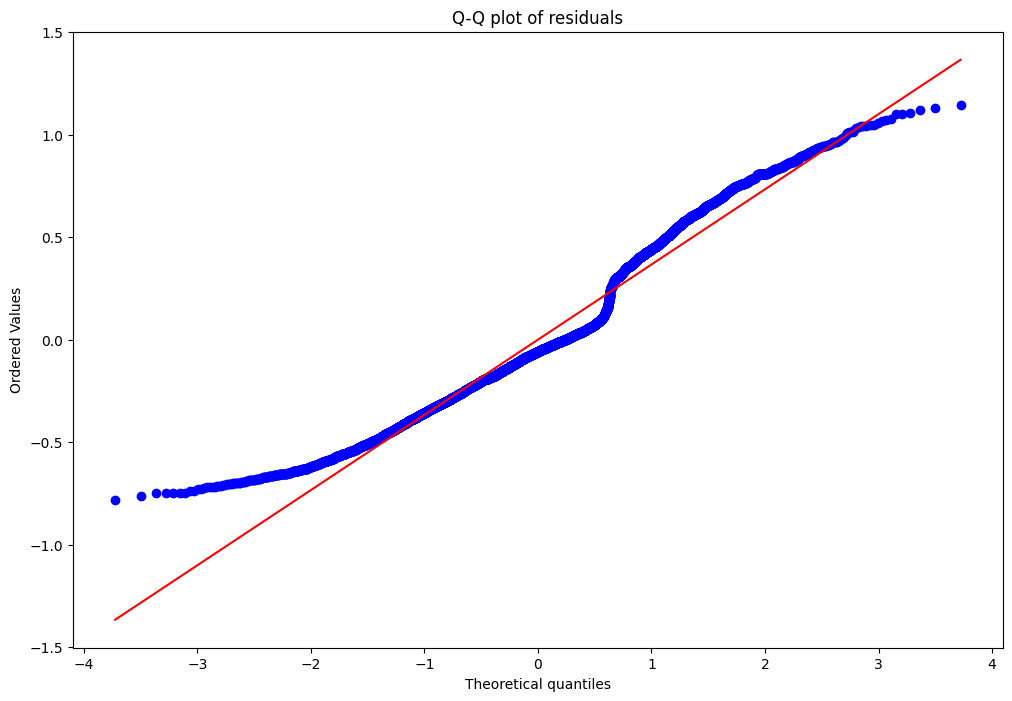

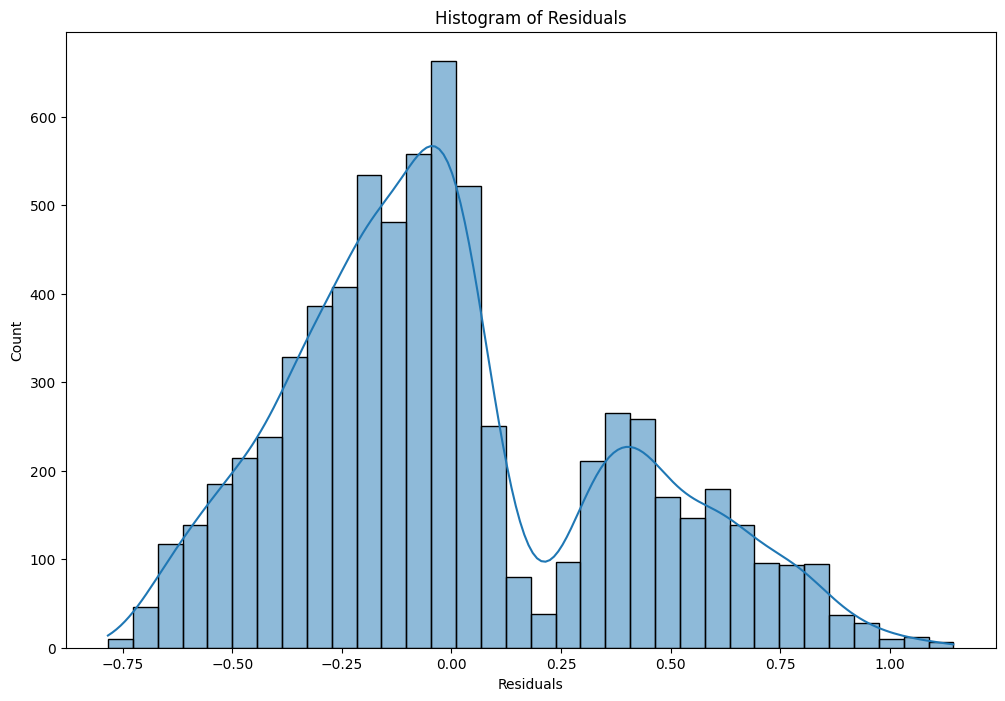

Skewness of residuals: 0.5512068257757001
Kurtosis of residuals: -0.32914652985649395


In [6]:
X_all = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Churn']

# fit model
model = LinearRegression()
model.fit(X_all, y)

# get prediction and residuals
y_pred = model.predict(X_all)
residuals = y - y_pred

# plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values (All Features)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# print
dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_statistic}")

# Q-Q plot
fig, ax = plt.subplots(figsize=(12, 8))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Q-Q plot of residuals")
plt.show()

# histplot
plt.figure(figsize=(12, 8))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.show()

# output
print(f"Skewness of residuals: {skew(residuals)}")
print(f"Kurtosis of residuals: {kurtosis(residuals)}")

Doesn't fit independence and normality

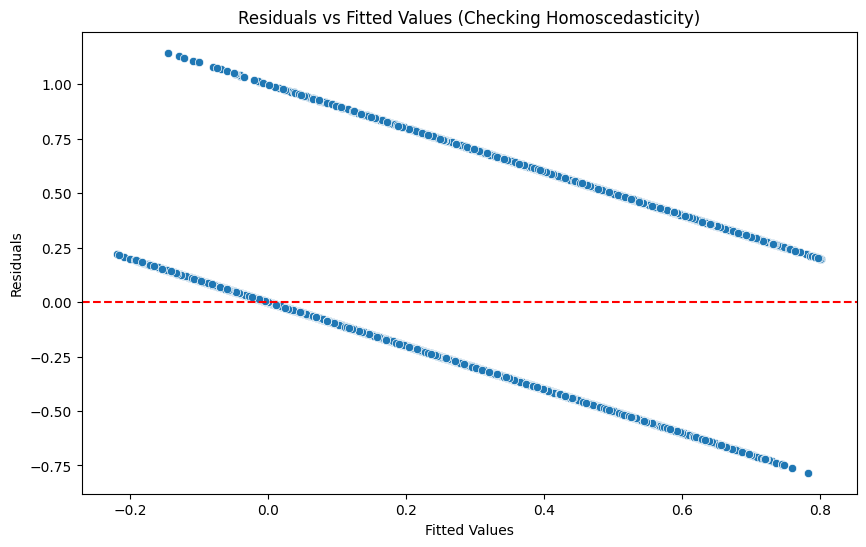

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values (Checking Homoscedasticity)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Doesn't fit Homoscedasticity

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factors:
                                   Variable         VIF
22         OnlineBackup_No internet service         inf
23                         OnlineBackup_Yes         inf
25     DeviceProtection_No internet service         inf
26                     DeviceProtection_Yes         inf
27                           TechSupport_No         inf
28          TechSupport_No internet service         inf
29                          TechSupport_Yes         inf
30                           StreamingTV_No         inf
31          StreamingTV_No internet service         inf
32                          StreamingTV_Yes         inf
33                       StreamingMovies_No         inf
34      StreamingMovies_No internet service         inf
35                      StreamingMovies_Yes         inf
36                  Contract_Month-to-month         inf
37                        Contract_One year         inf
38                        Contract_Two year         inf
39                  

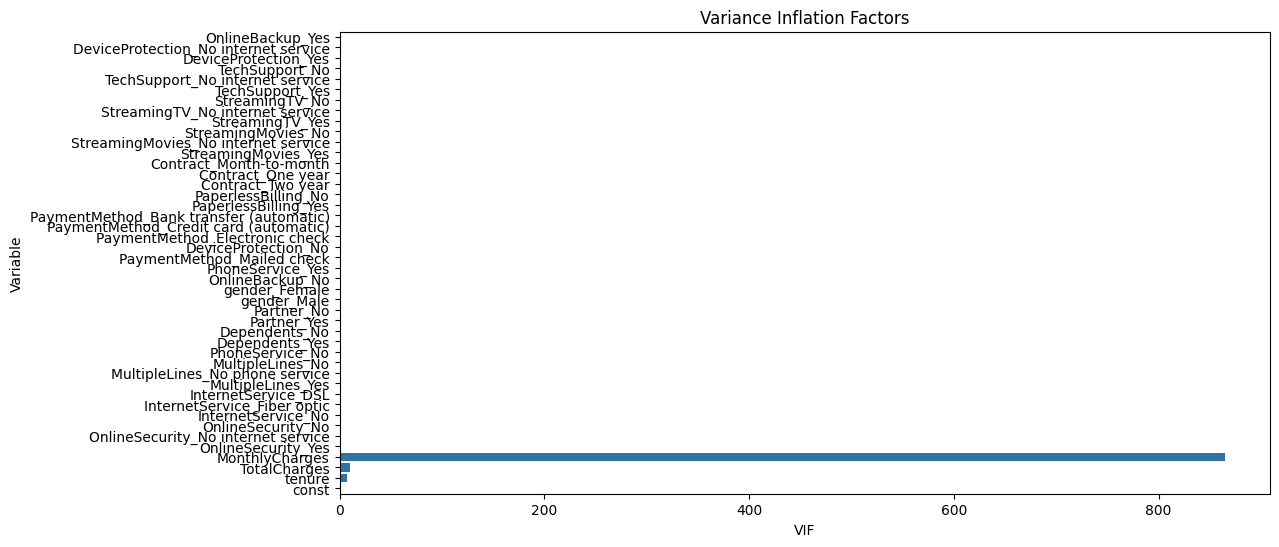

In [8]:


X_all = pd.concat([df[numerical_cols], encoded_df], axis=1)

# add const
X_with_const = sm.add_constant(X_all)

# calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# output VIF
vif_data = vif_data.sort_values('VIF', ascending=False)
print("Variance Inflation Factors:")
print(vif_data)

# identify high VIF
high_vif = vif_data[vif_data['VIF'] > 5].sort_values('VIF', ascending=False)
print("\nVariables with high VIF (>5):")
print(high_vif)

plt.figure(figsize=(12, 6))
sns.barplot(x='VIF', y='Variable', data=vif_data.iloc[1:])
plt.title('Variance Inflation Factors')
plt.show()

Doesn't fit No Multicollinearity.

Logistic Assumption Check

<ipython-input-3-be050181905e>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_mean = df.groupby('bin')[target].mean()
<ipython-input-3-be050181905e>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby('bin')[col].mean()


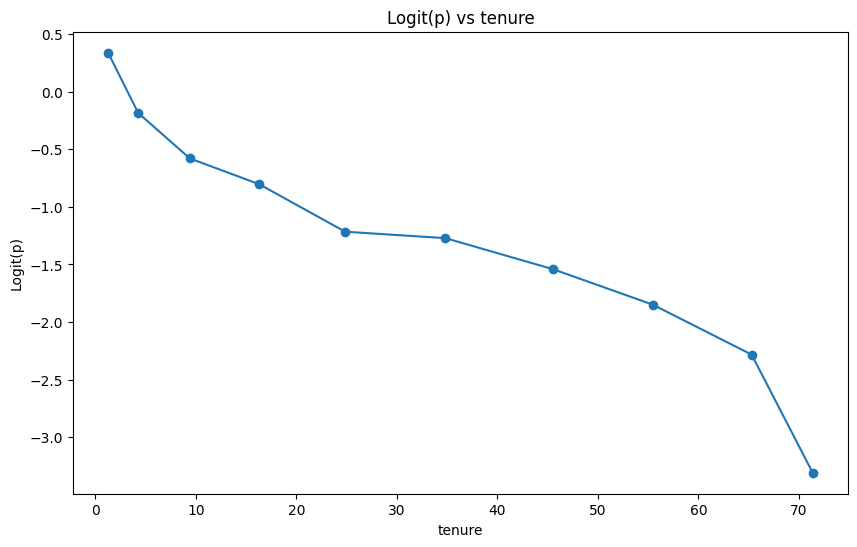

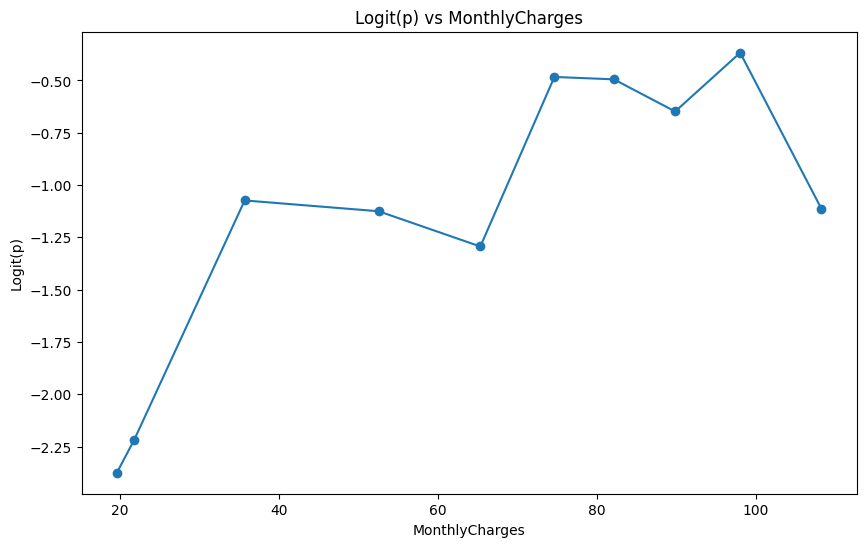

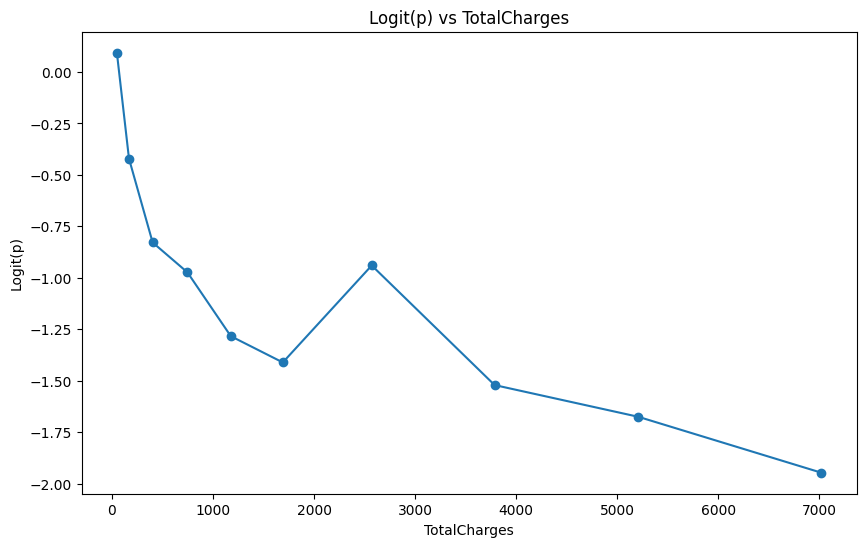

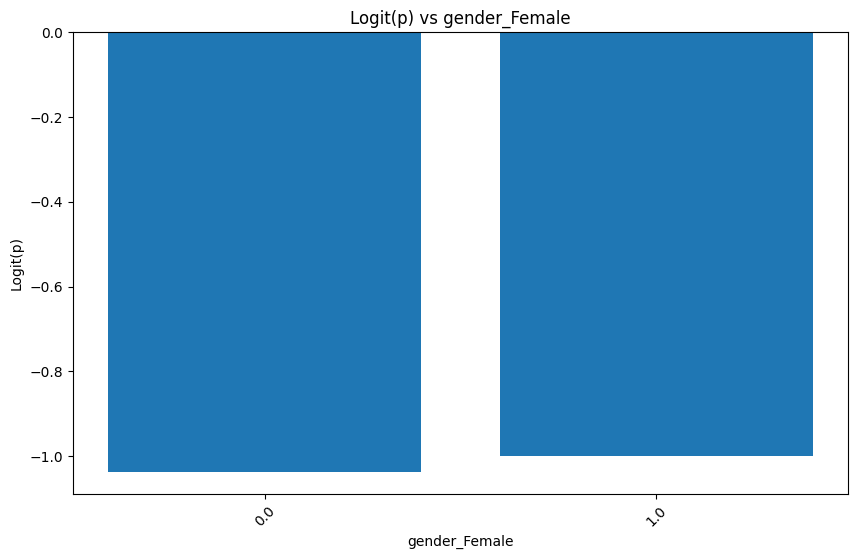

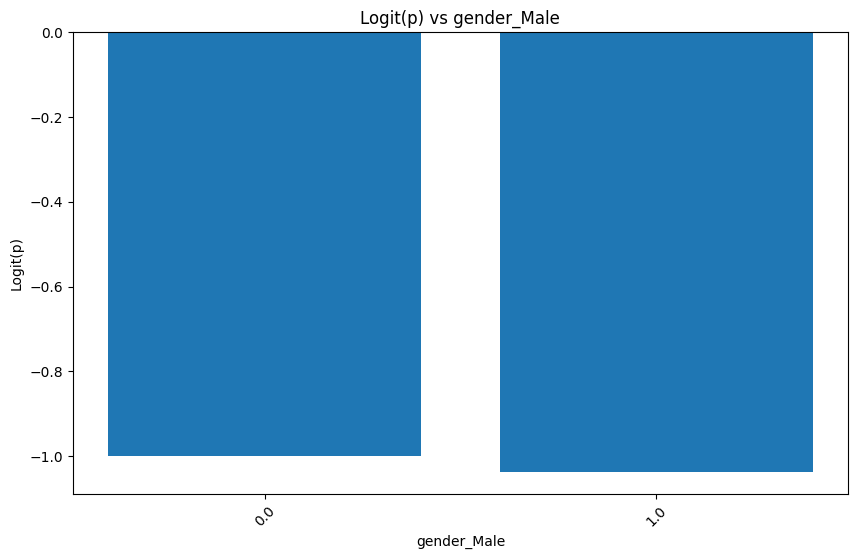

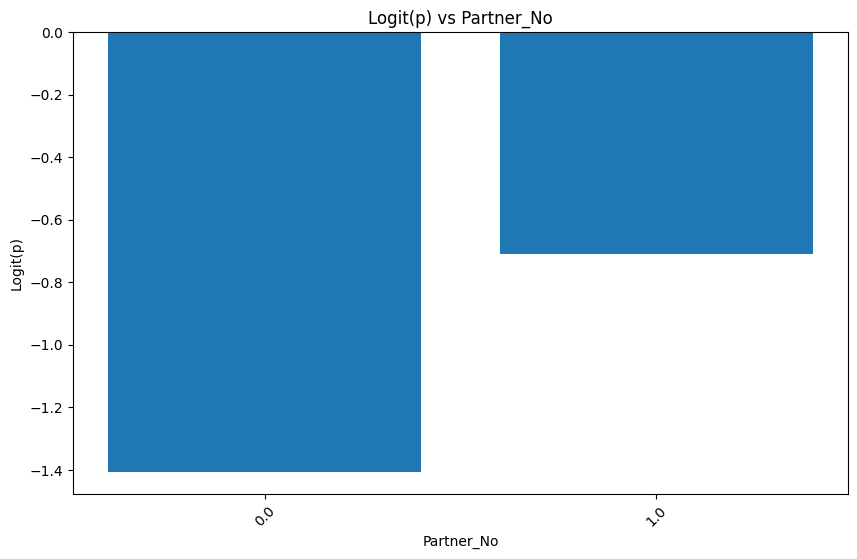

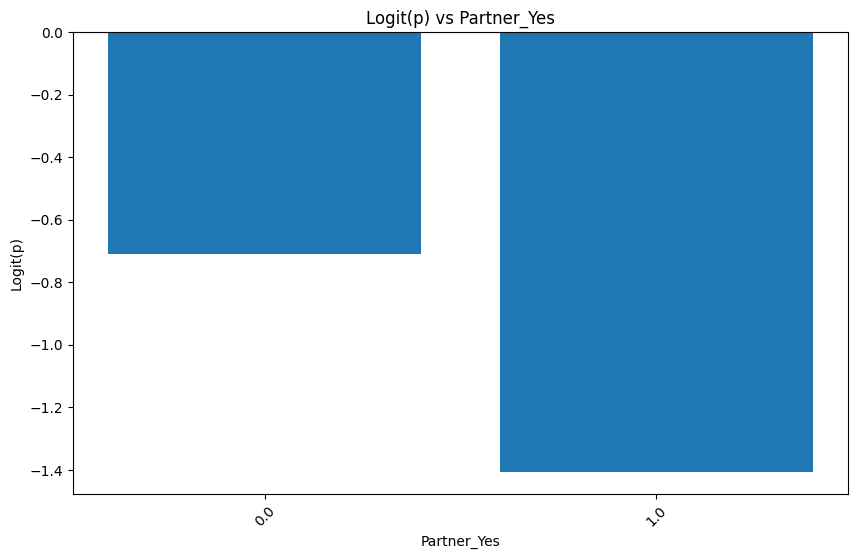

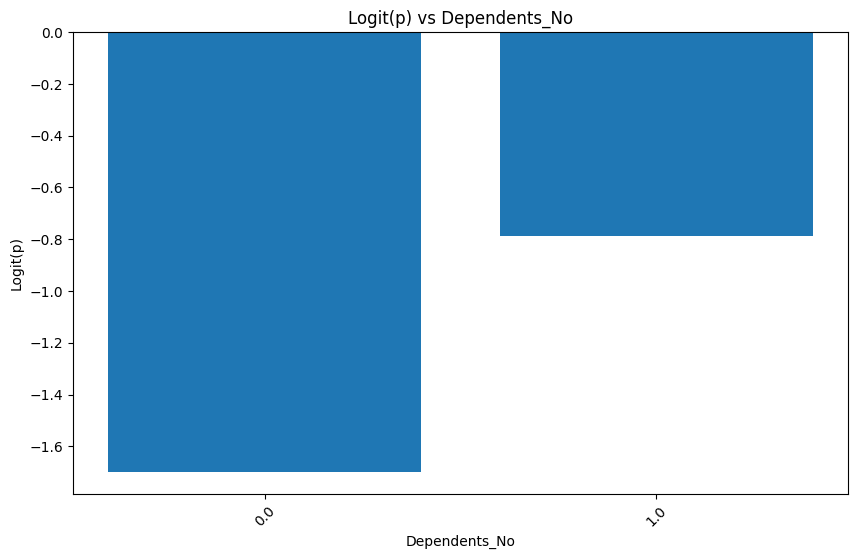

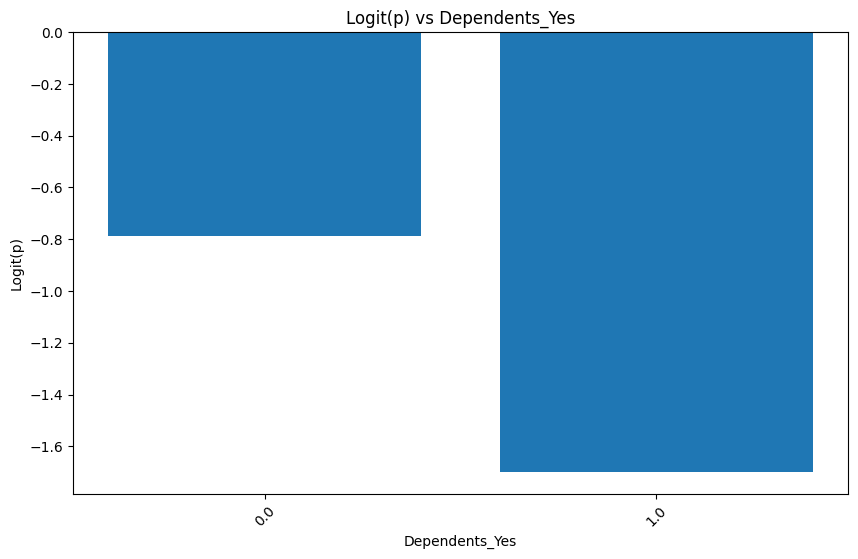

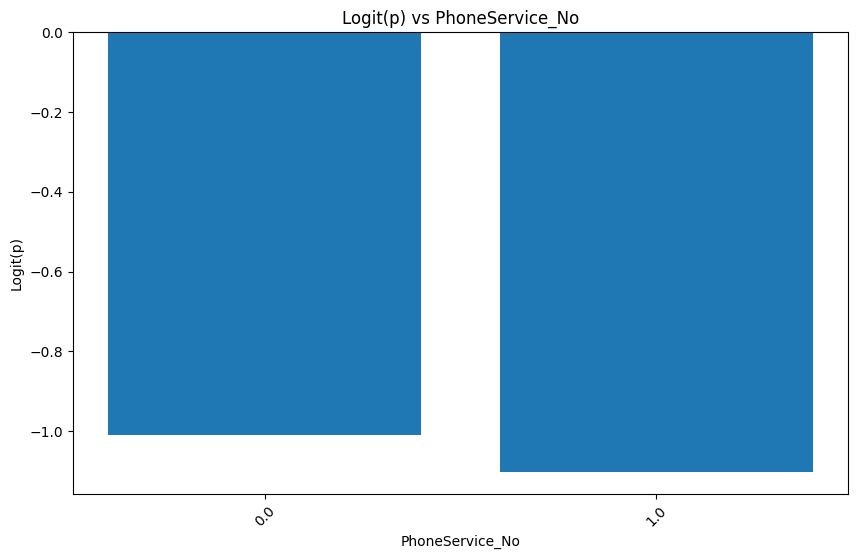

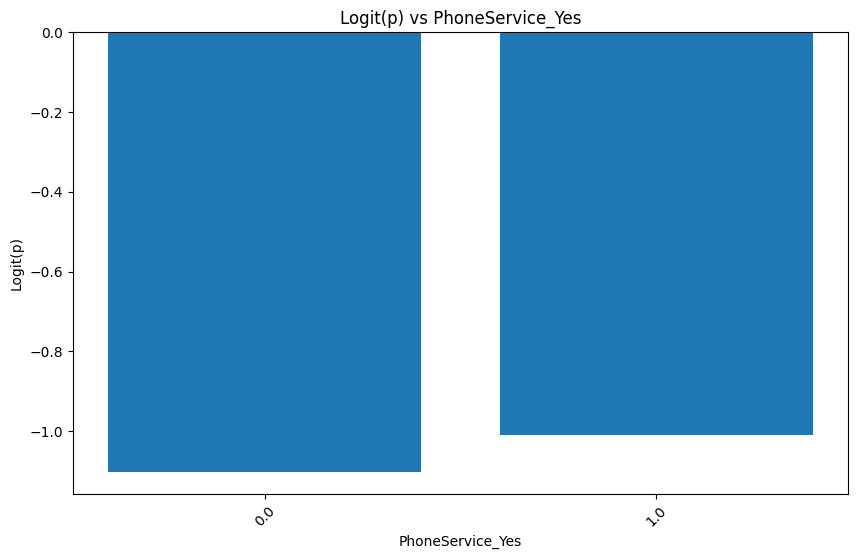

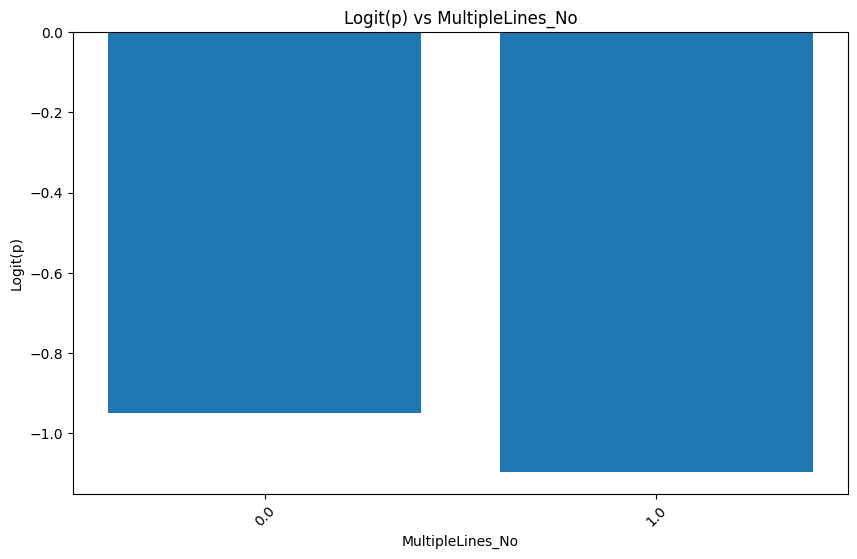

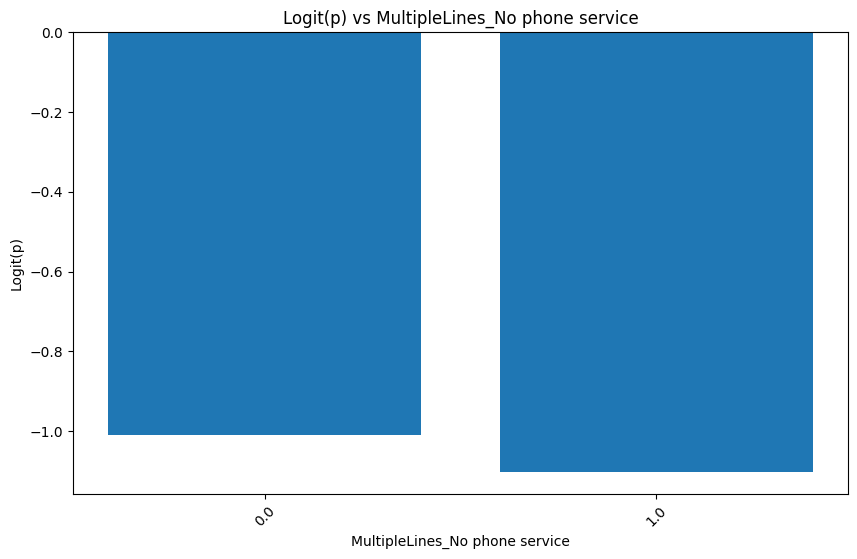

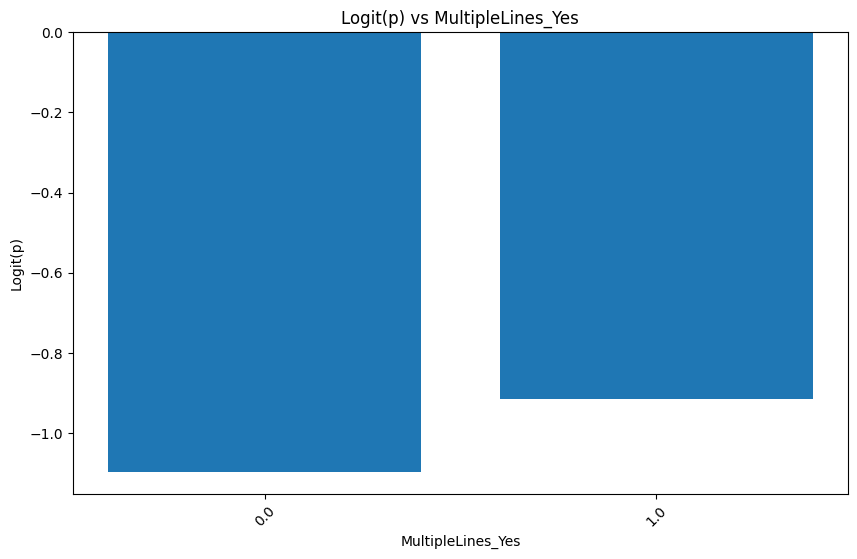

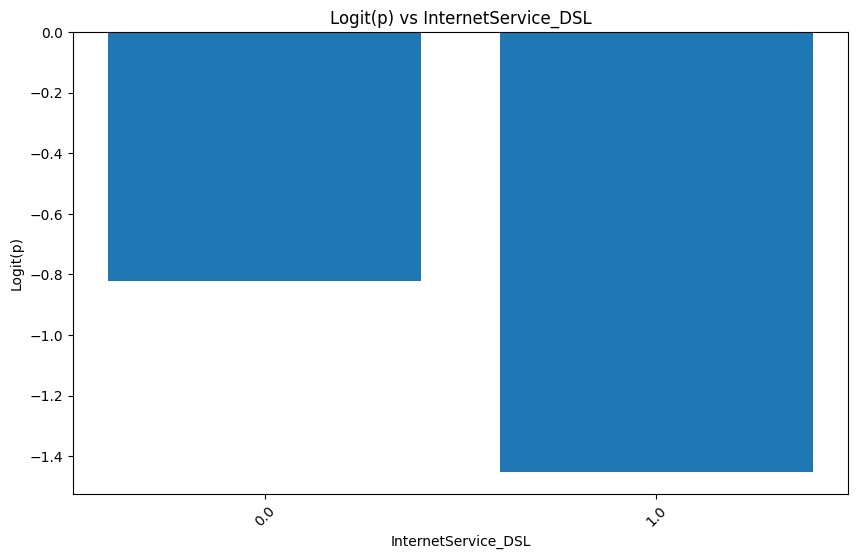

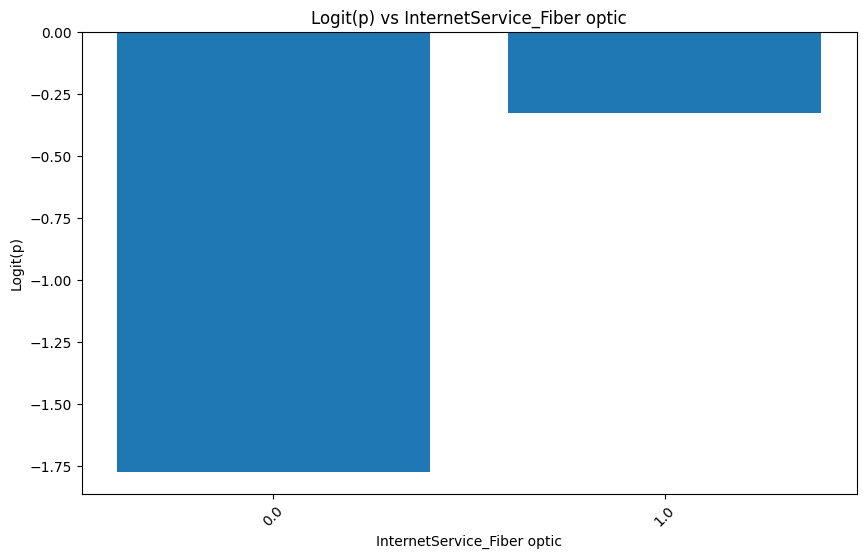

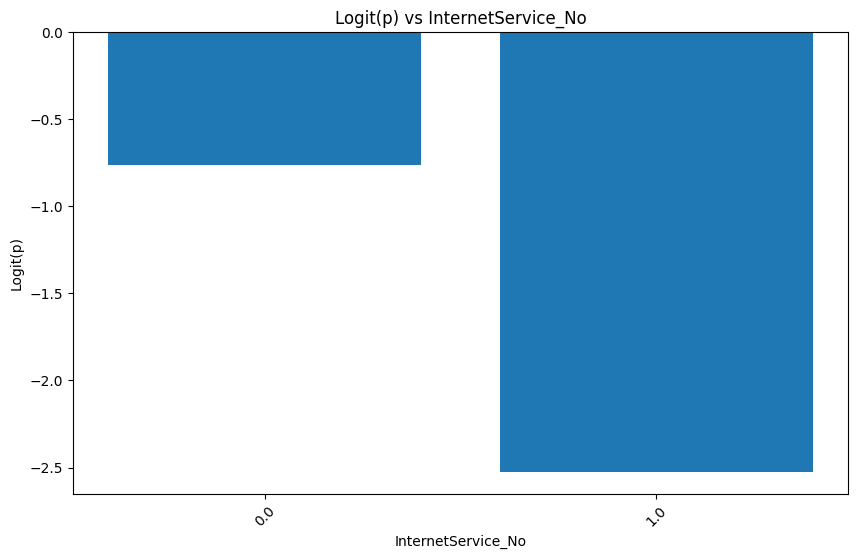

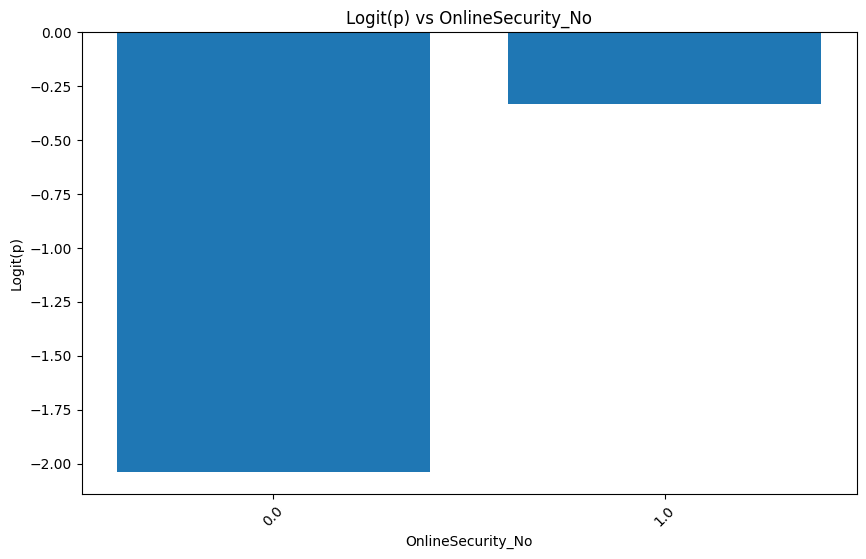

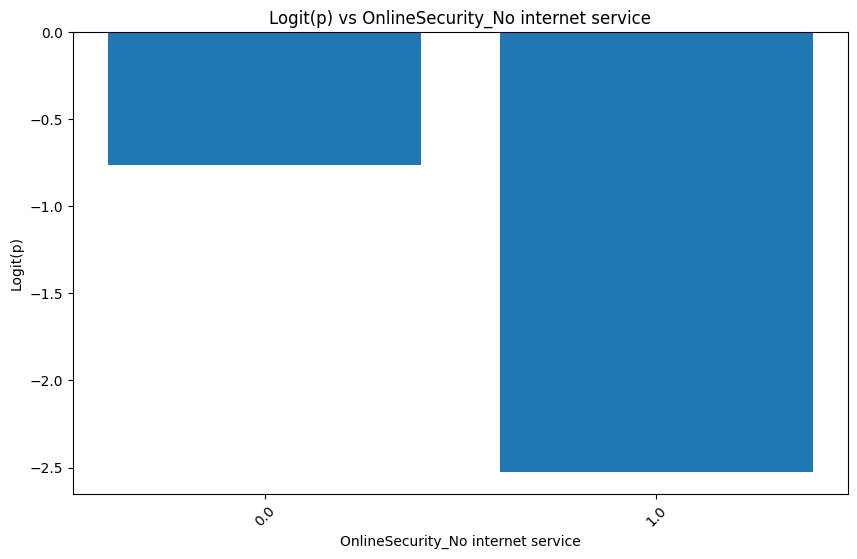

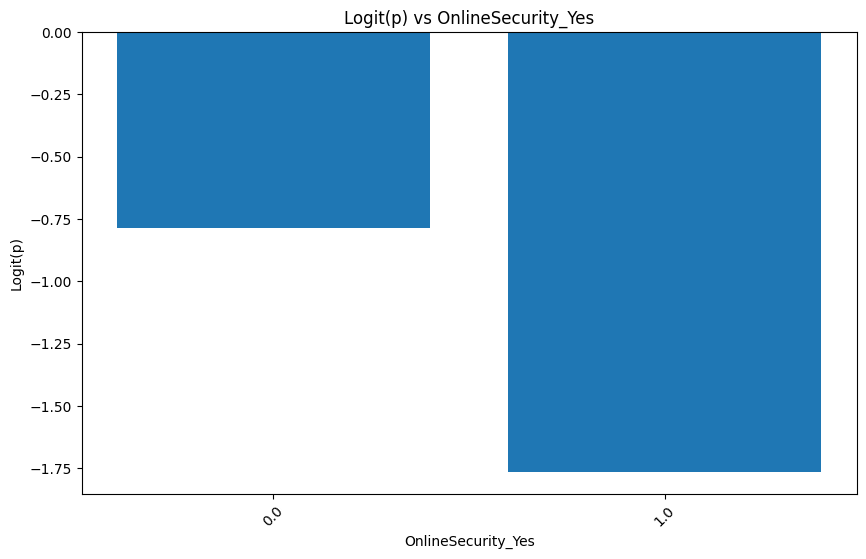

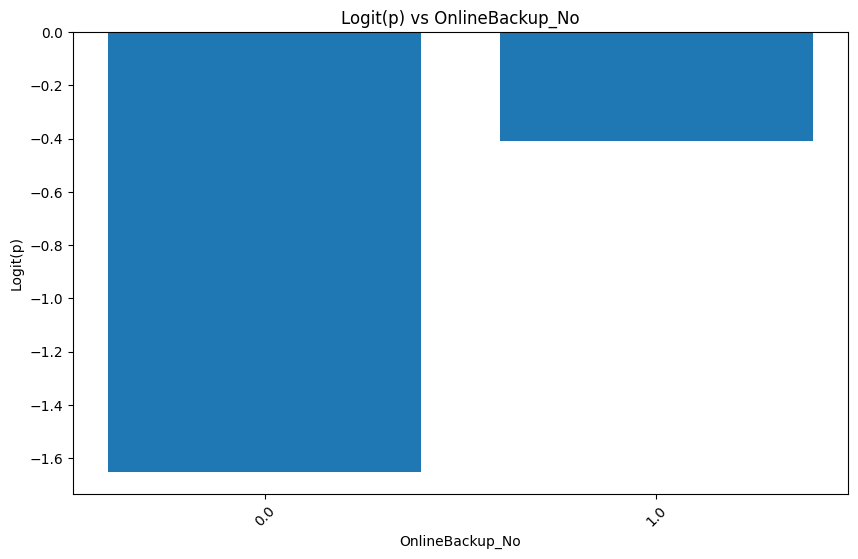

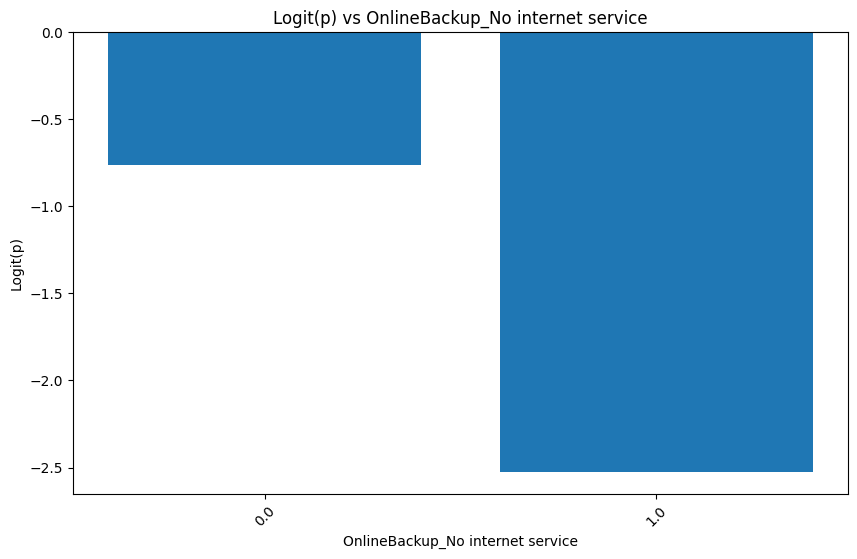

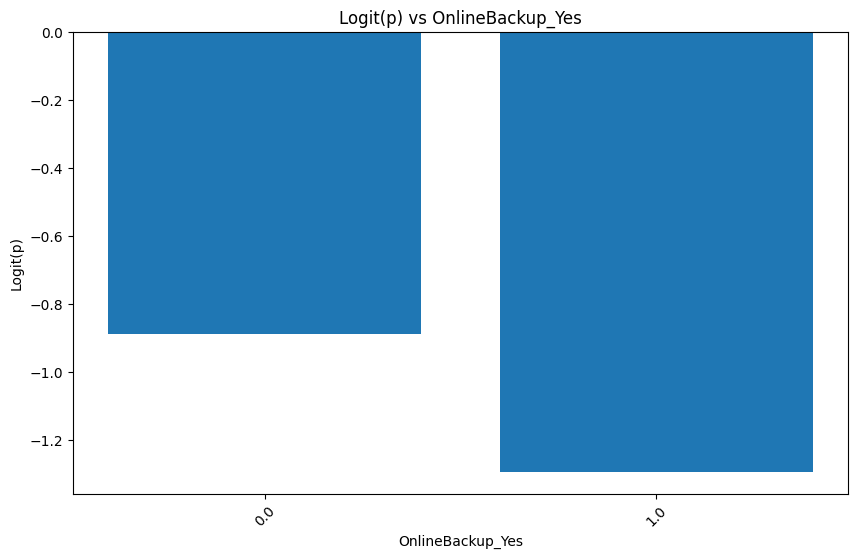

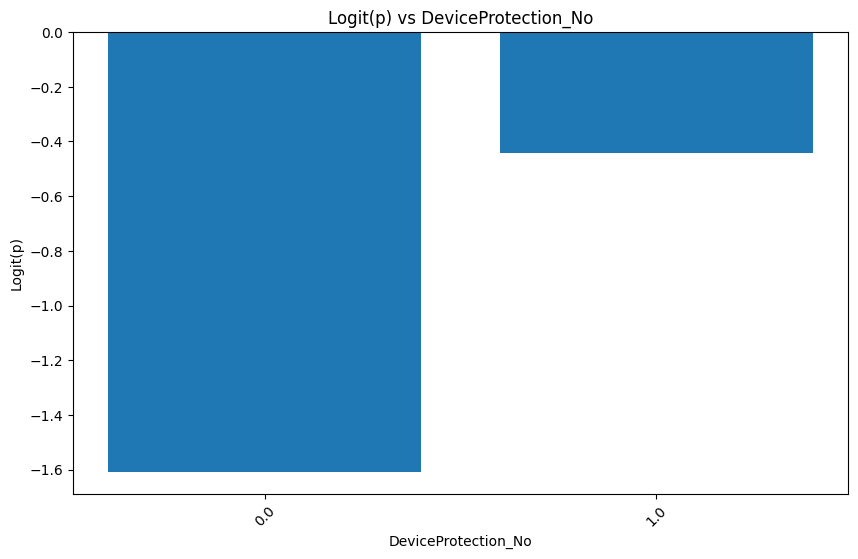

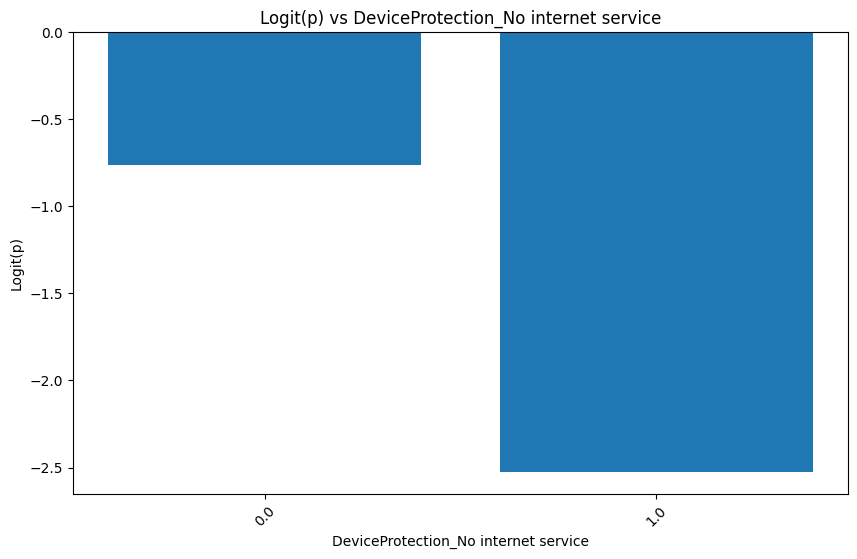

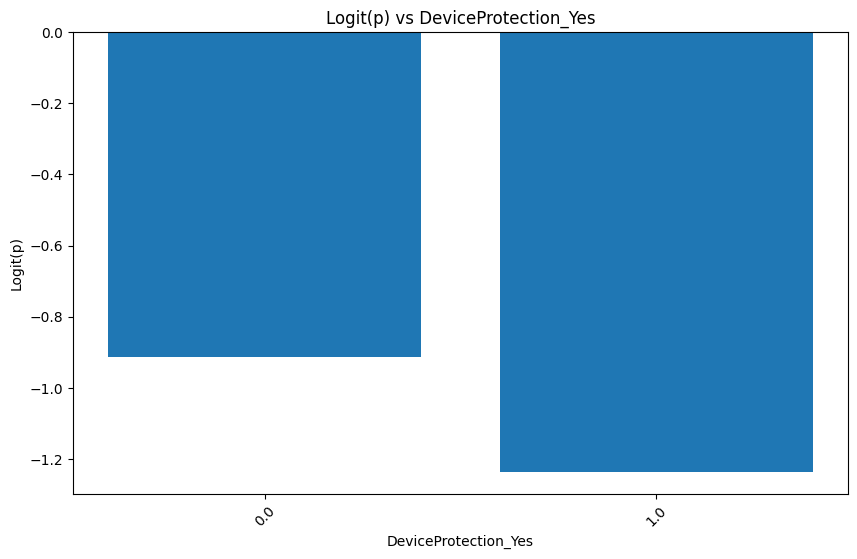

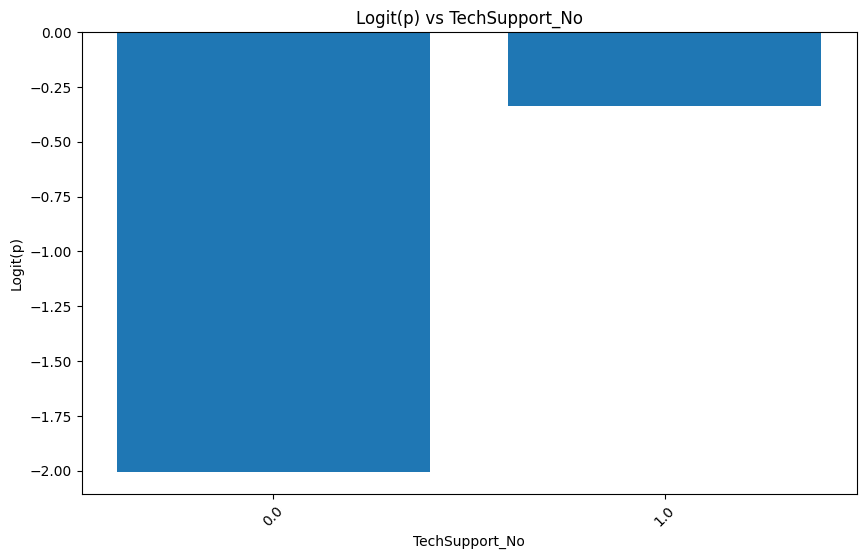

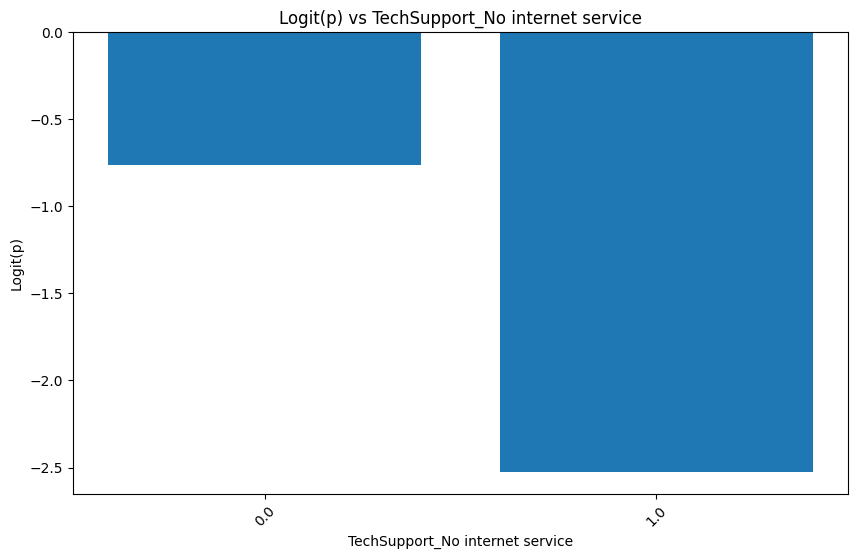

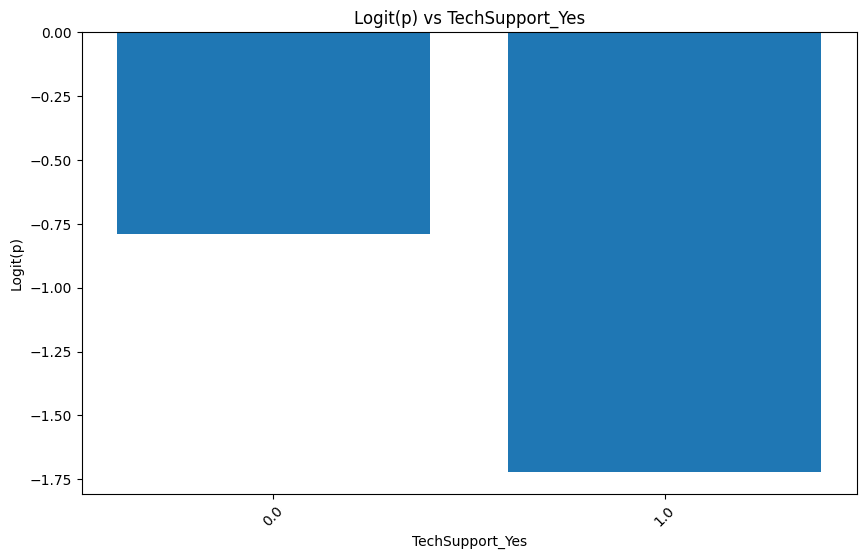

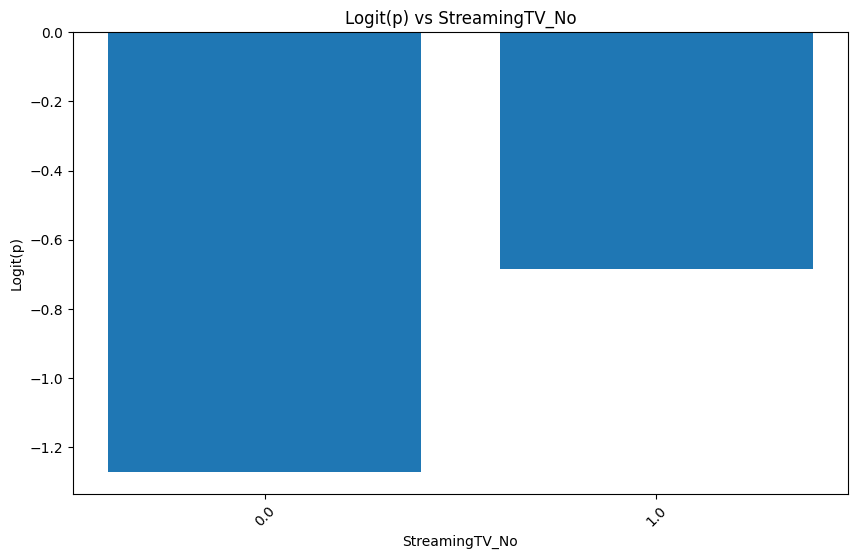

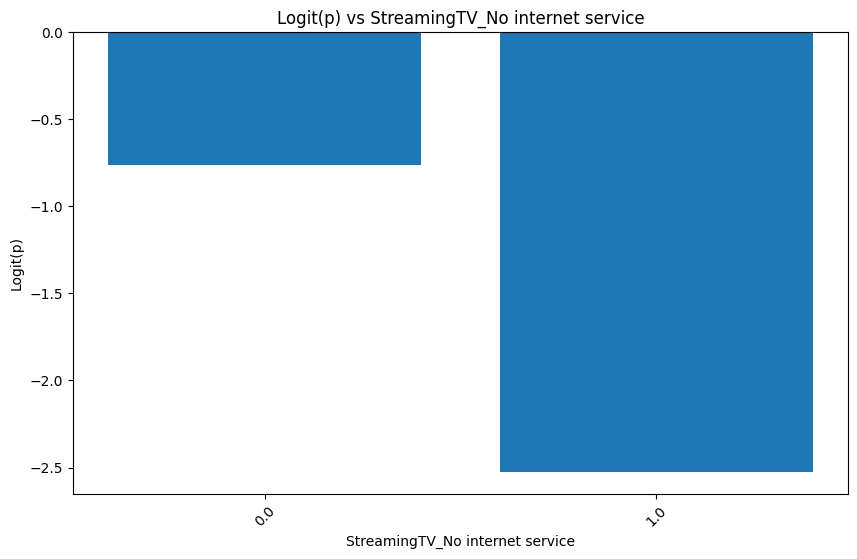

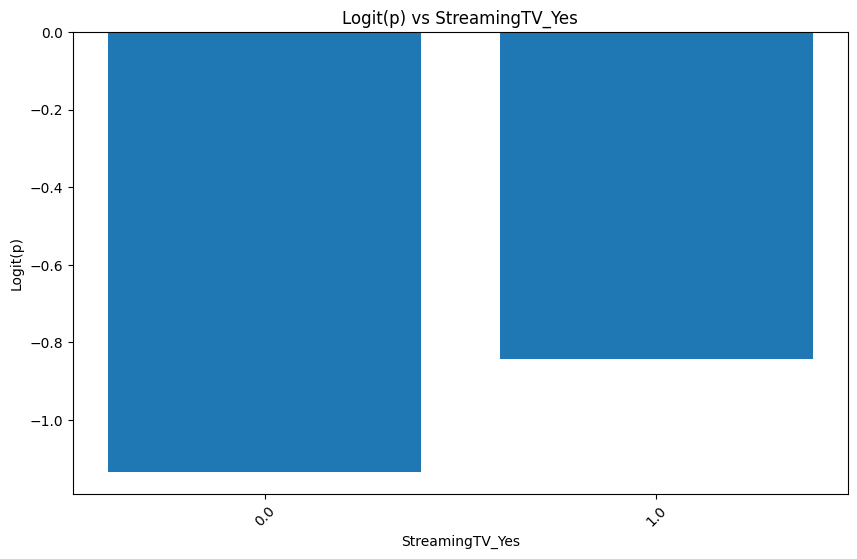

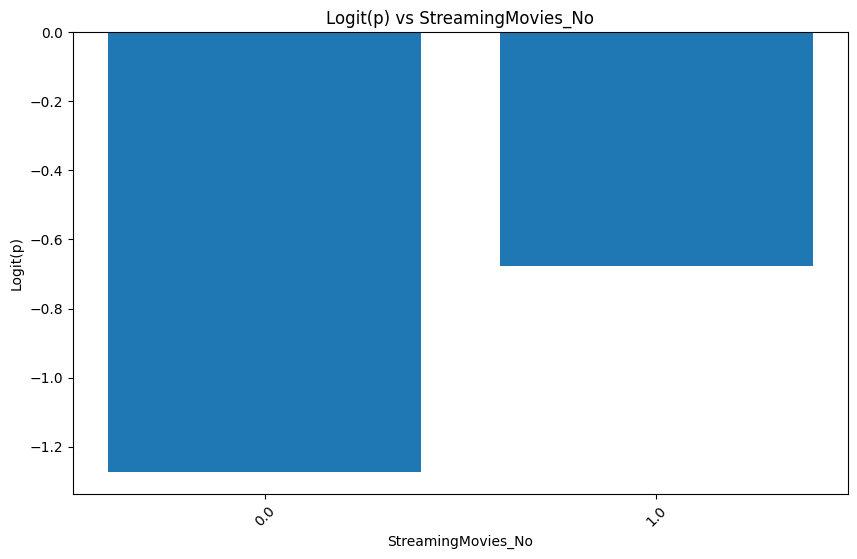

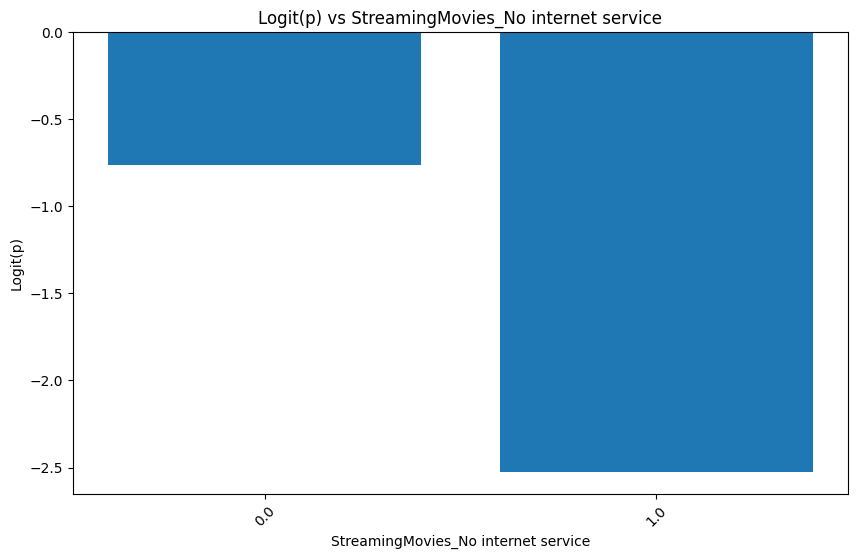

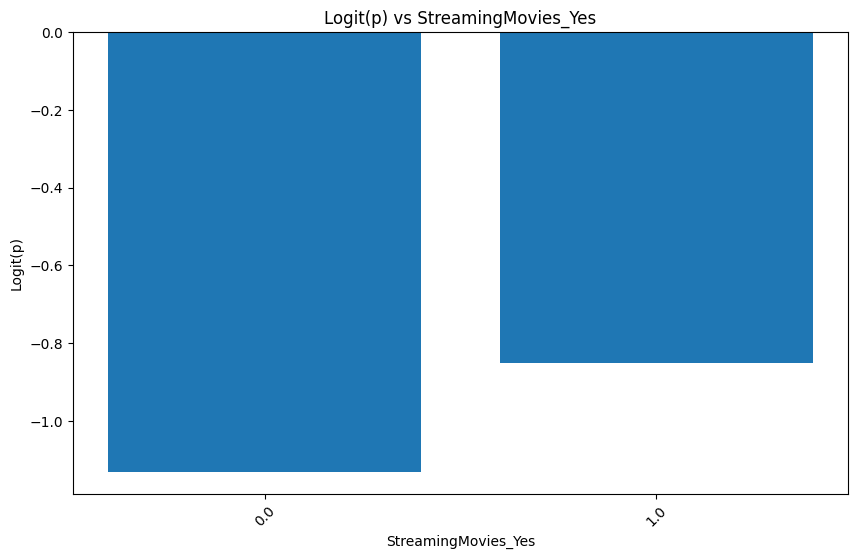

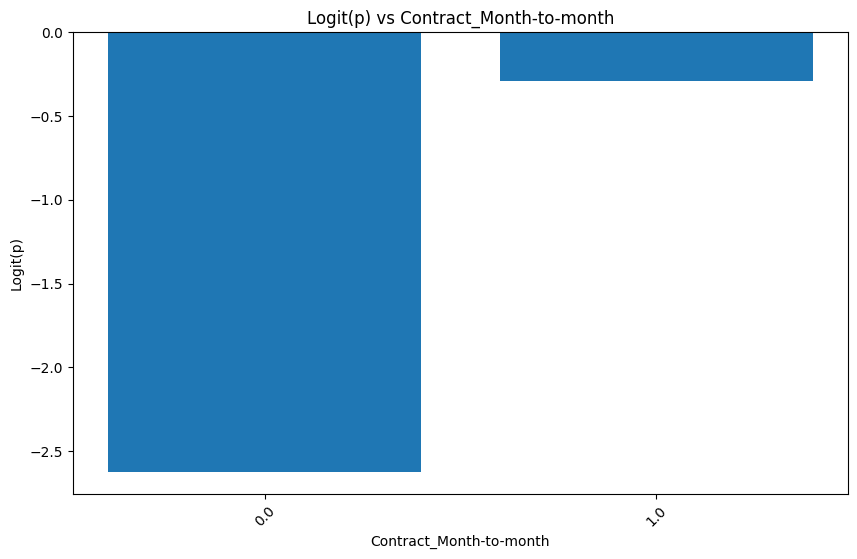

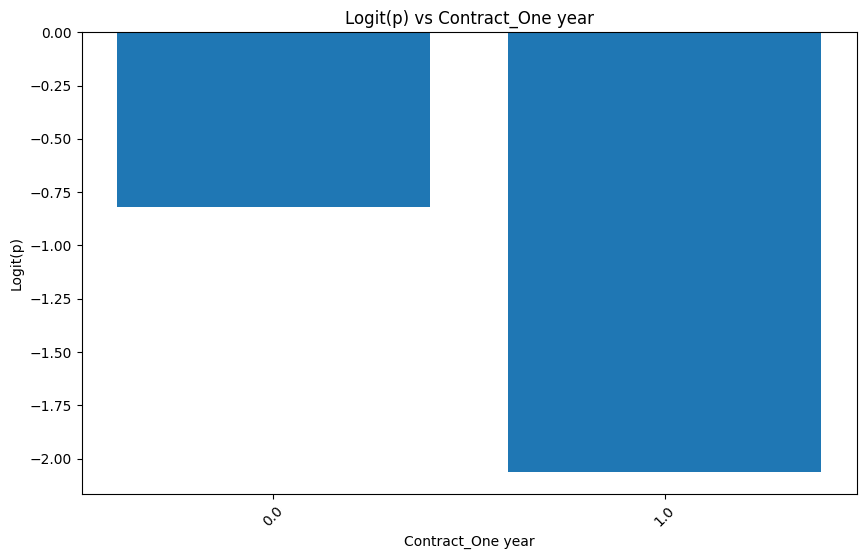

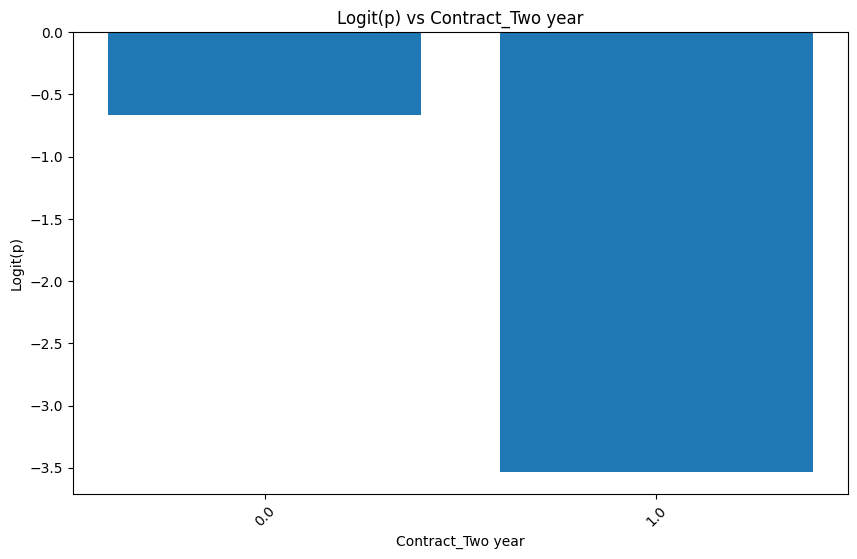

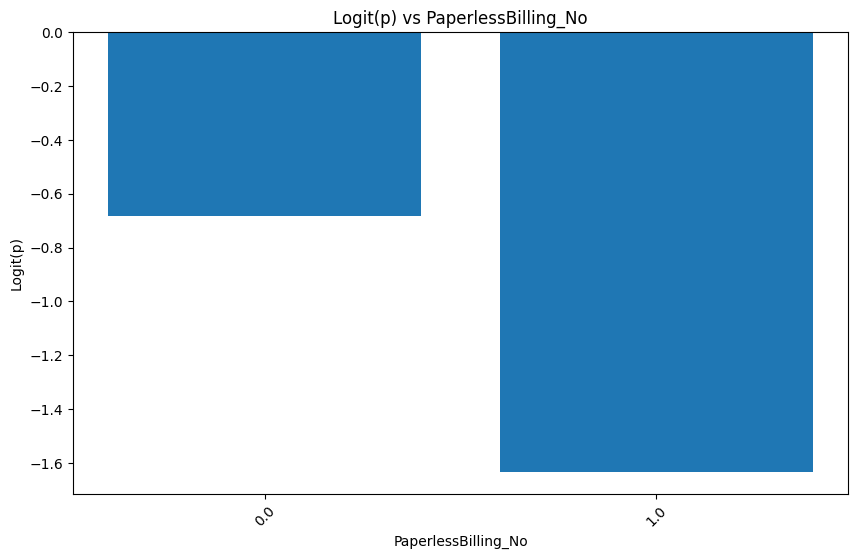

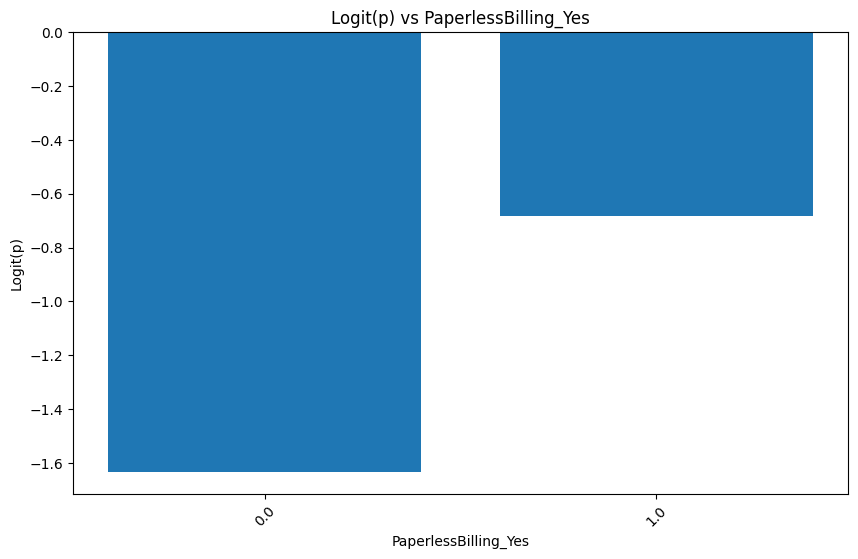

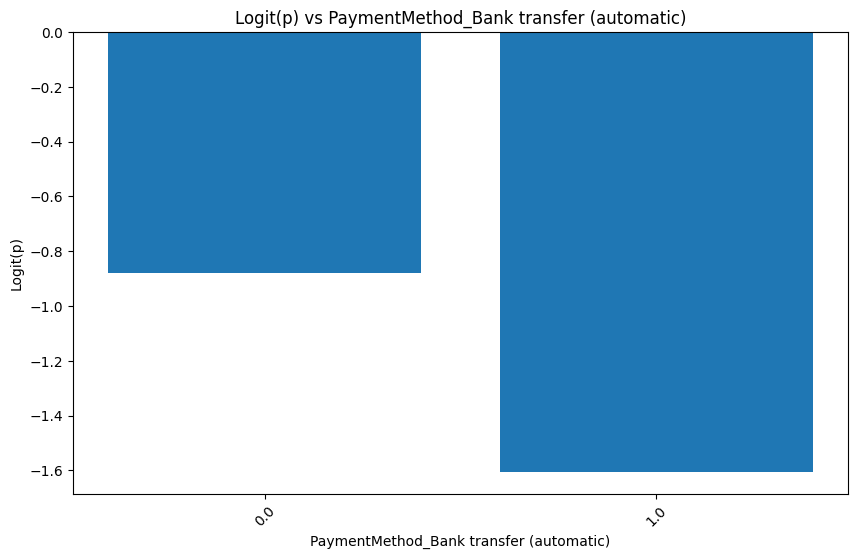

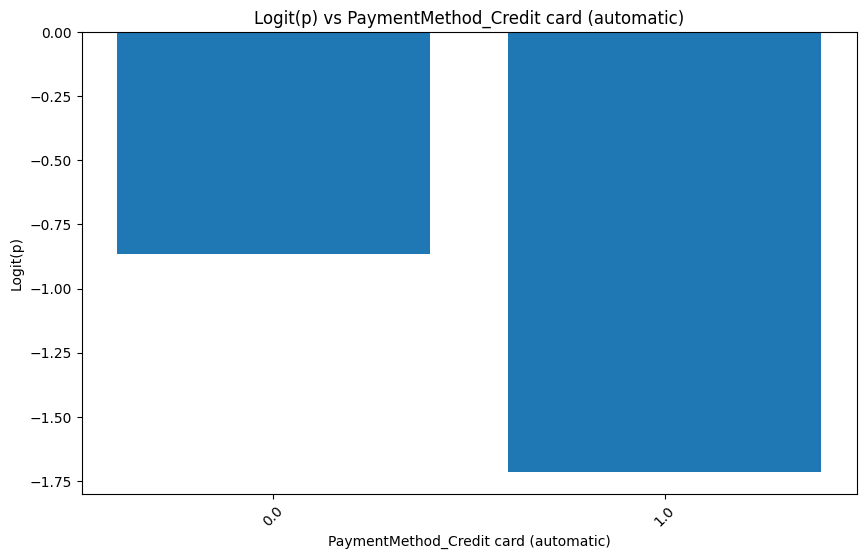

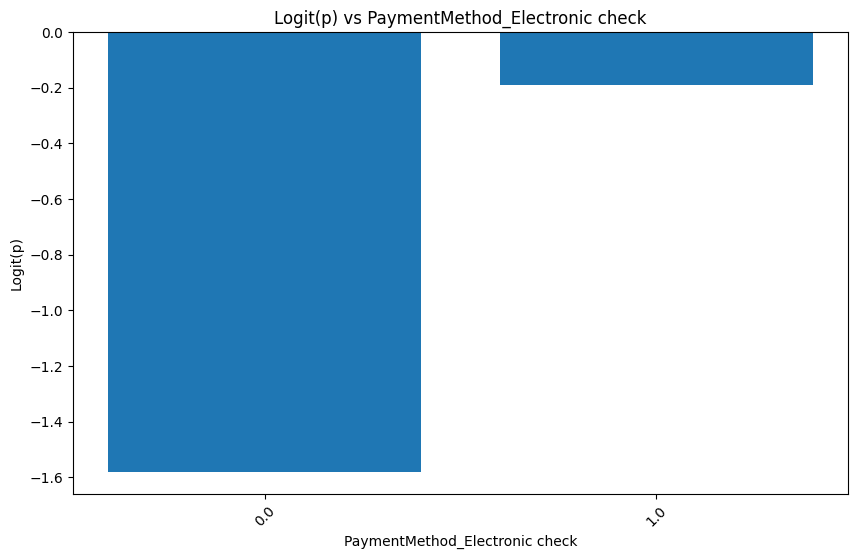

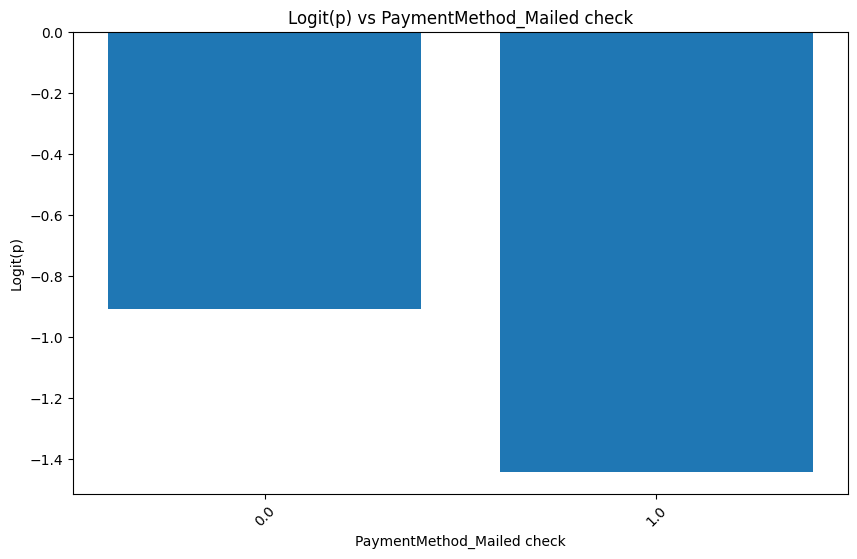

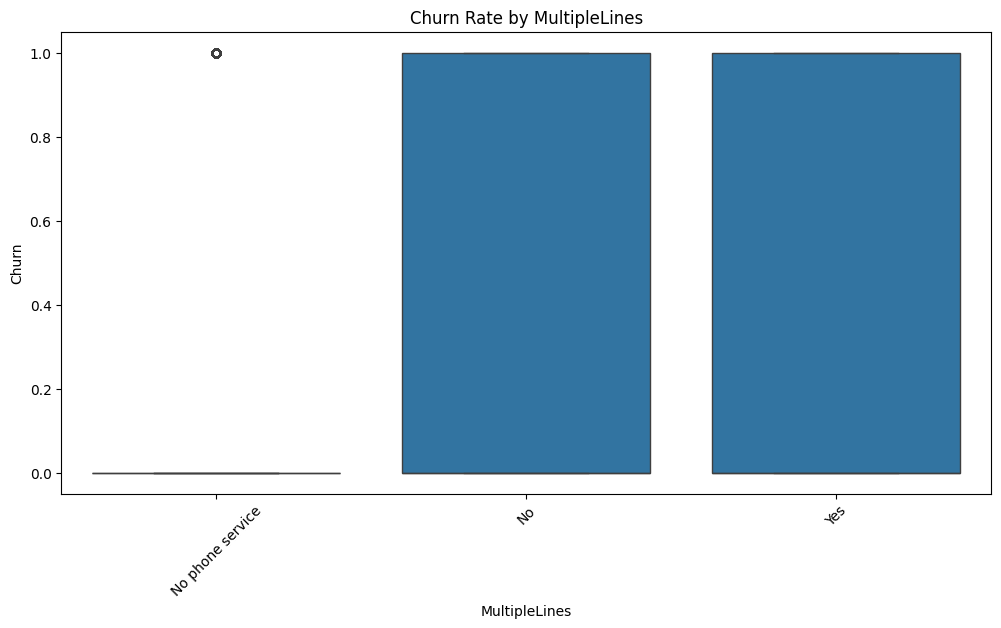

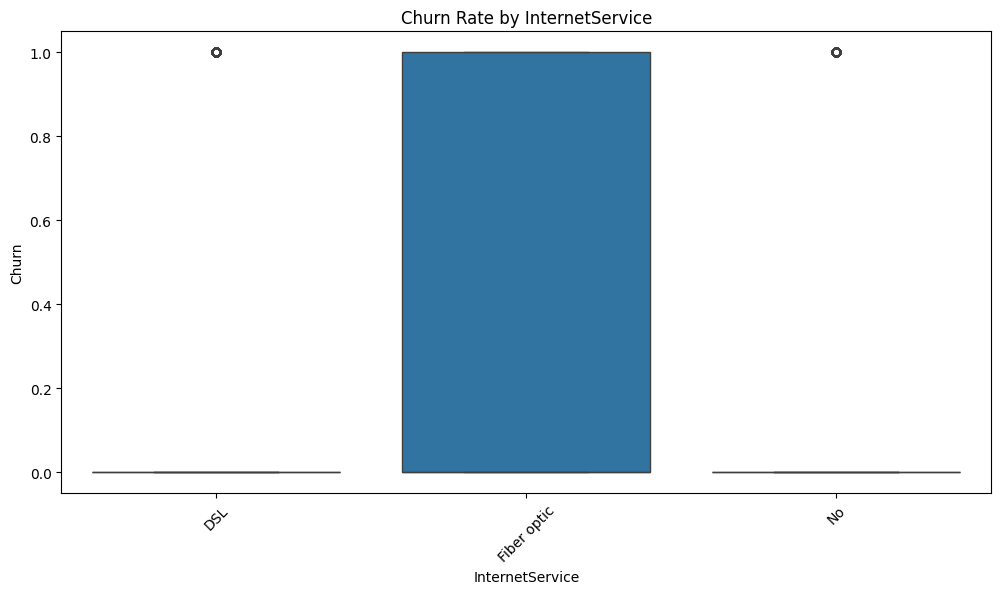

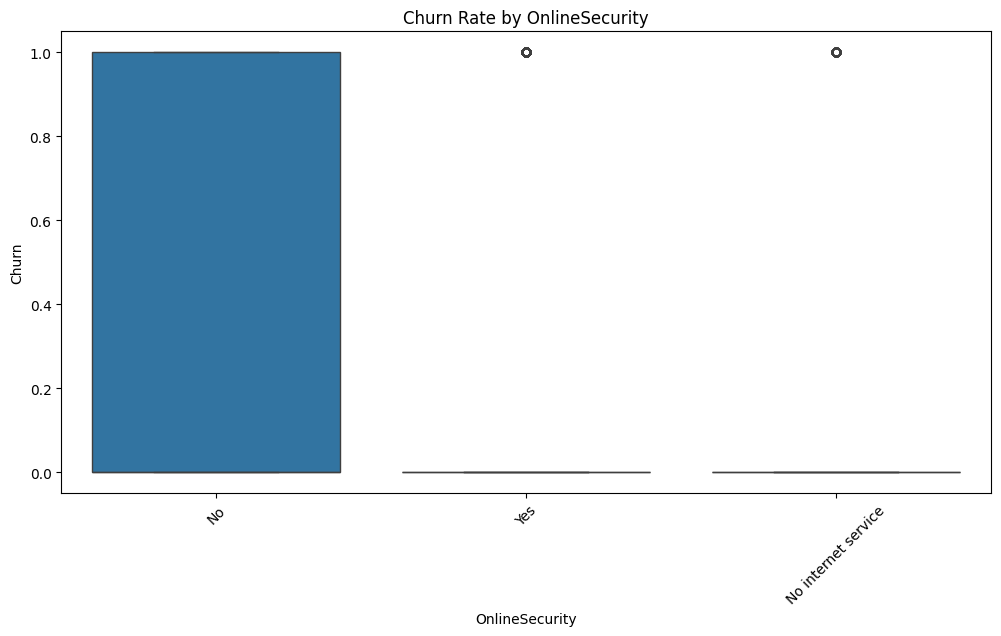

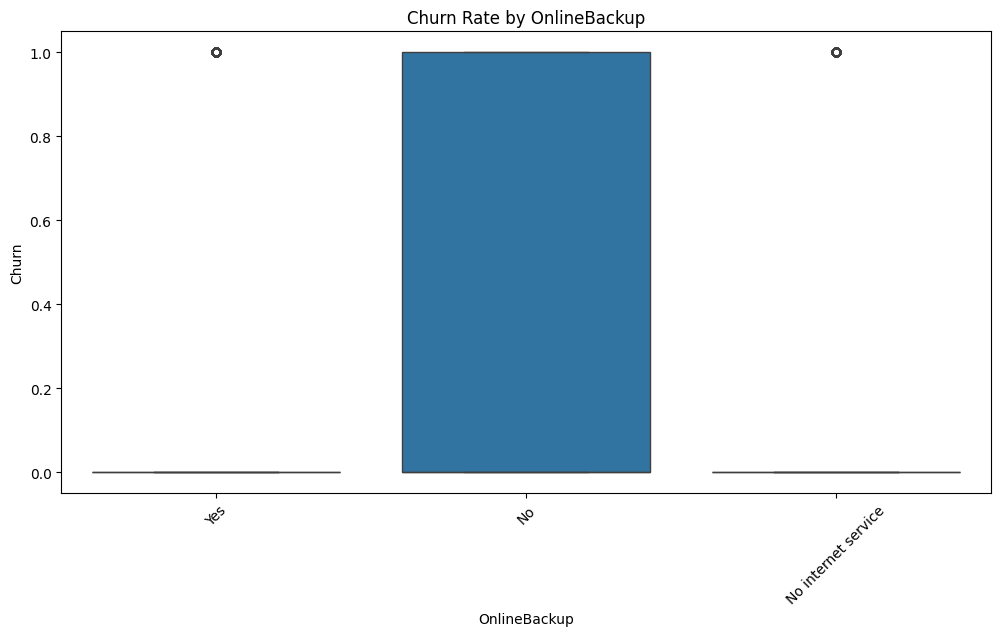

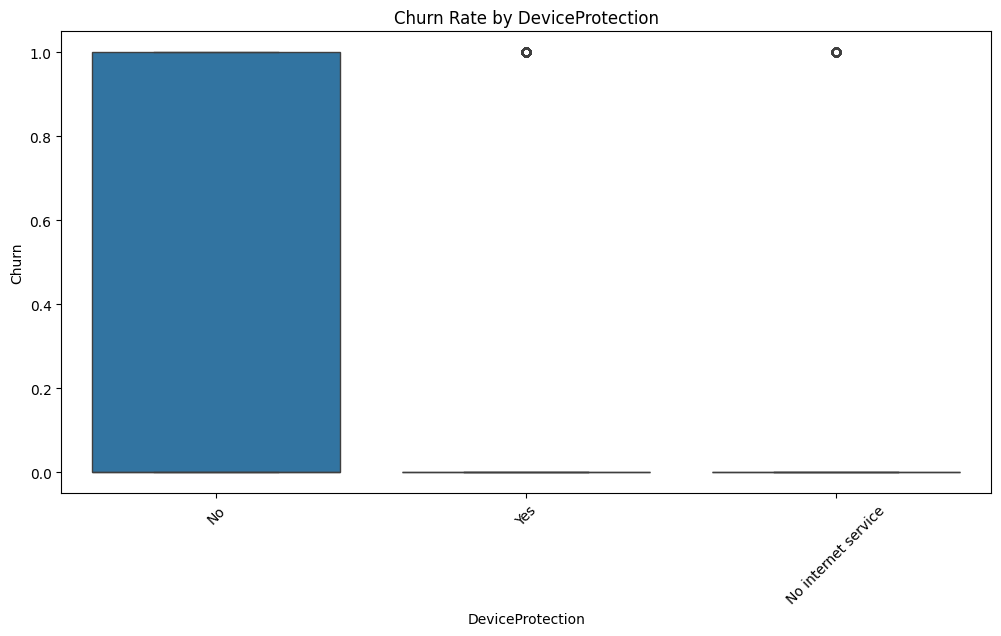

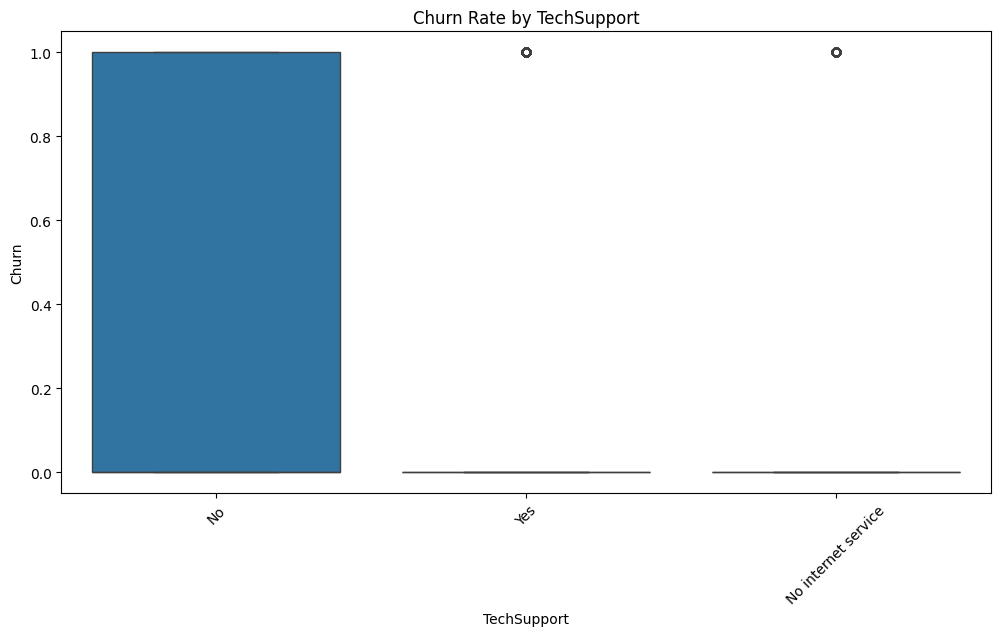

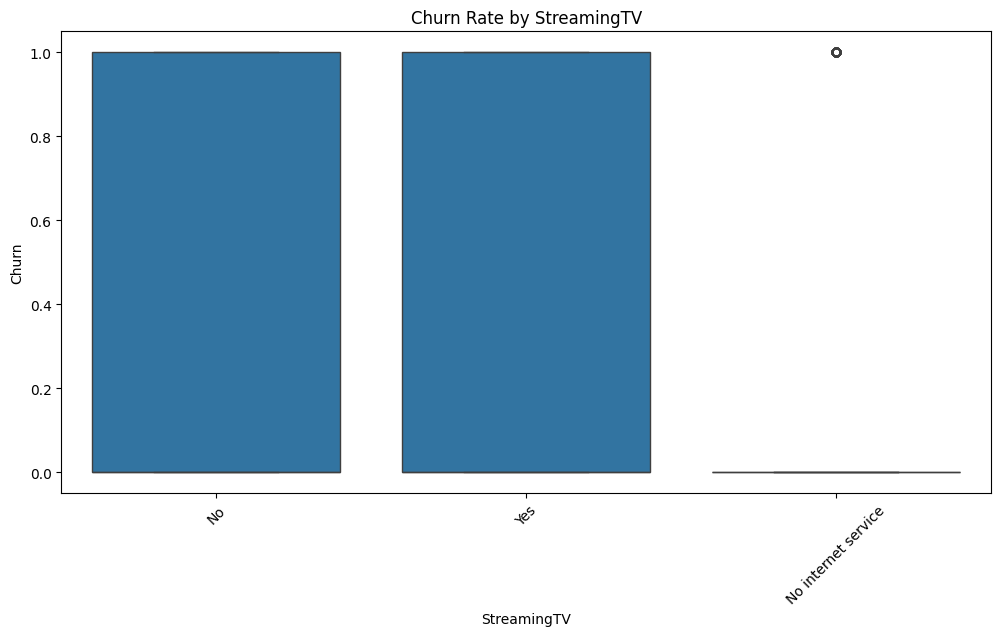

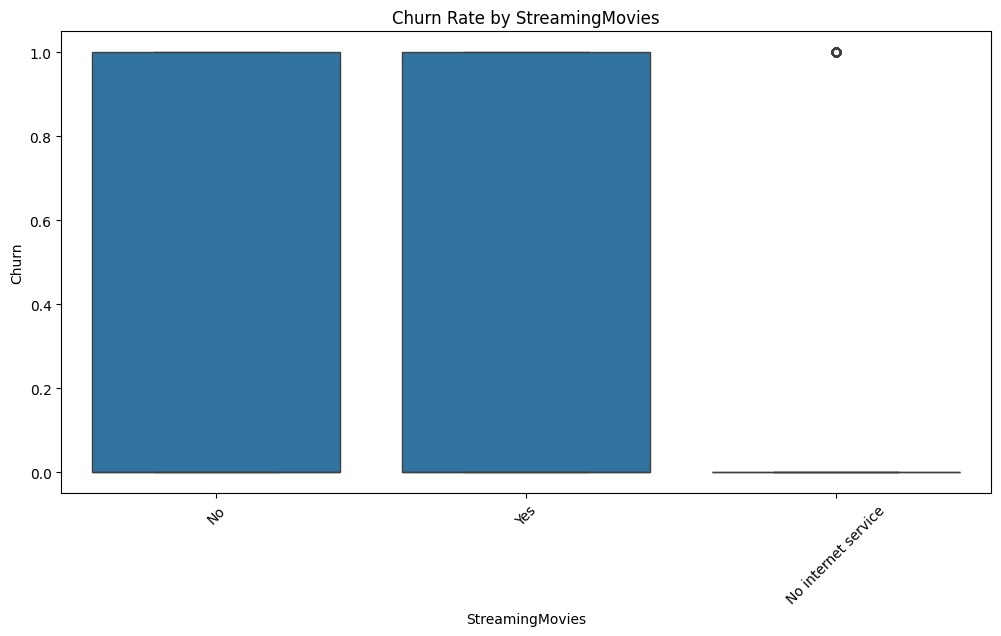

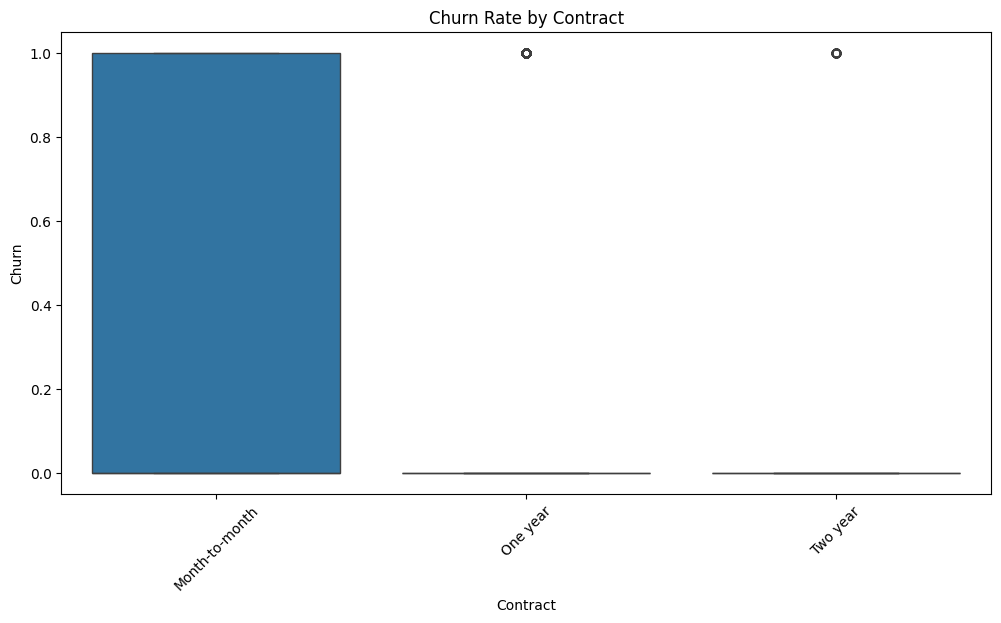

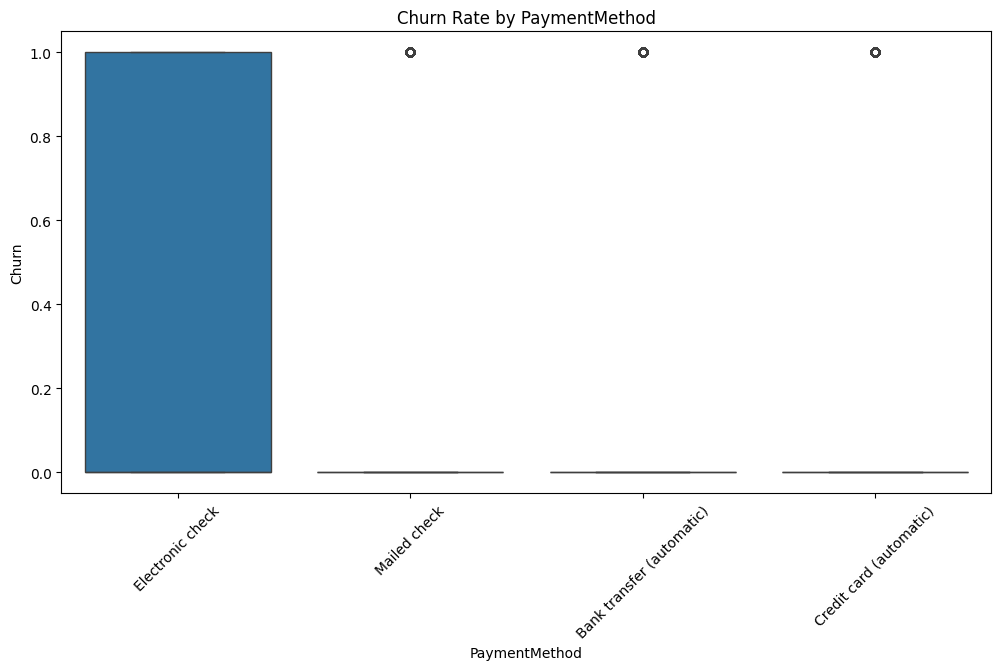

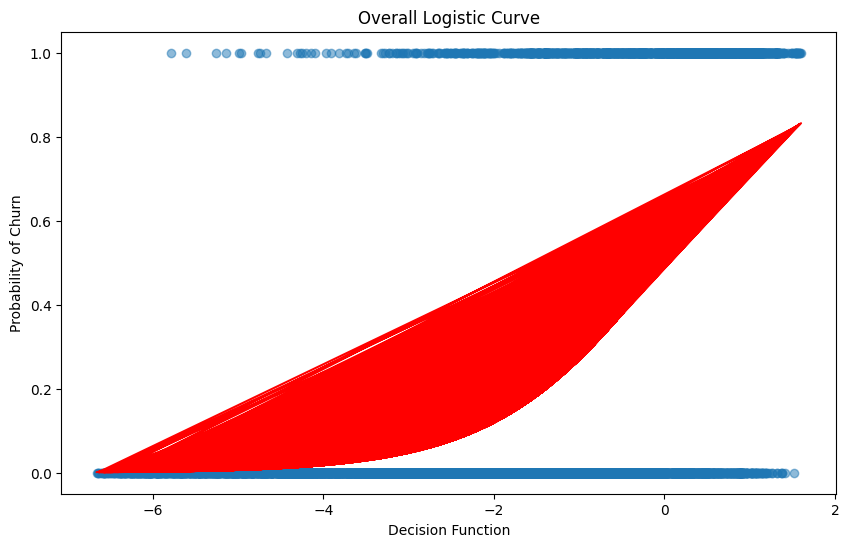

In [9]:
# Check linearity for numerical features
for col in numerical_cols:
    check_linearity_numerical(df, col)

# Check linearity for encoded categorical features
for col in encoded_df.columns:
    unique_values = encoded_df[col].nunique()
    if unique_values == 2:
        check_linearity_categorical(pd.concat([encoded_df, df['Churn']], axis=1), col)
    else:
        print(f"Skipping multi-category variable: {col}")

# Optional: Visualize relationship for multi-category variables
for col in categorical_cols:
    if df[col].nunique() > 2:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=col, y='Churn', data=df)
        plt.title(f'Churn Rate by {col}')
        plt.xticks(rotation=45)
        plt.show()

# Overall logistic curve
X = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression()
model.fit(X_scaled, y)

plt.figure(figsize=(10, 6))
plt.scatter(model.decision_function(X_scaled), y, alpha=0.5)
plt.plot(model.decision_function(X_scaled), model.predict_proba(X_scaled)[:, 1], color='red')
plt.title('Overall Logistic Curve')
plt.xlabel('Decision Function')
plt.ylabel('Probability of Churn')
plt.show()

Only Tenure shows linearity

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factors:
                                   Variable         VIF
22         OnlineBackup_No internet service         inf
23                         OnlineBackup_Yes         inf
25     DeviceProtection_No internet service         inf
26                     DeviceProtection_Yes         inf
27                           TechSupport_No         inf
28          TechSupport_No internet service         inf
29                          TechSupport_Yes         inf
30                           StreamingTV_No         inf
31          StreamingTV_No internet service         inf
32                          StreamingTV_Yes         inf
33                       StreamingMovies_No         inf
34      StreamingMovies_No internet service         inf
35                      StreamingMovies_Yes         inf
36                  Contract_Month-to-month         inf
37                        Contract_One year         inf
38                        Contract_Two year         inf
39                  

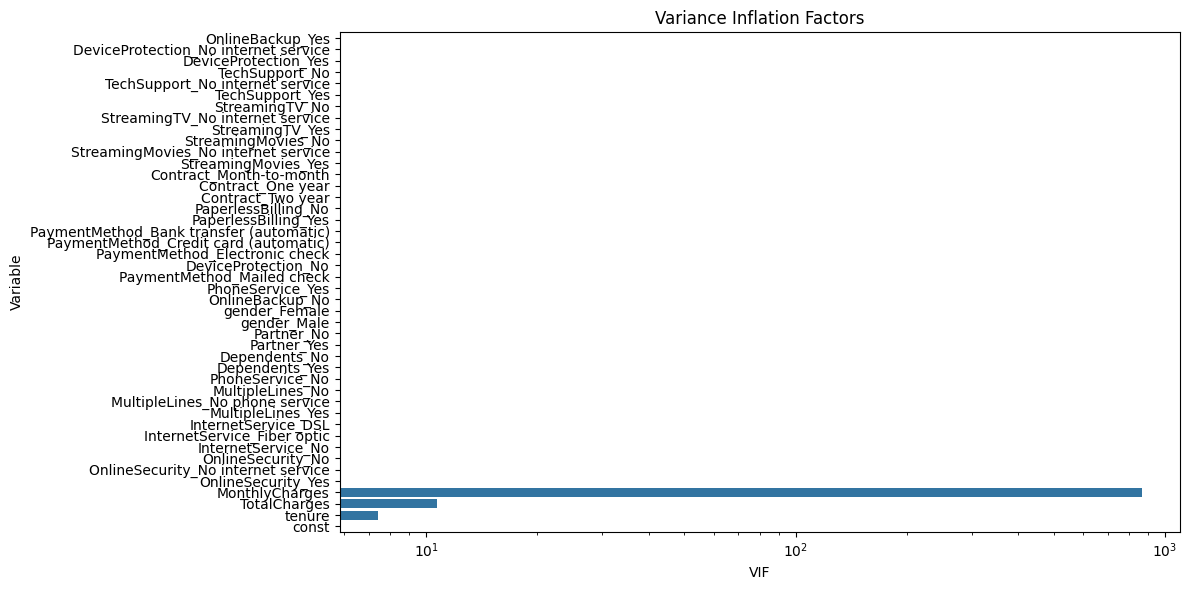

In [10]:
# Combine numerical and encoded categorical variables
X = pd.concat([df[numerical_cols], encoded_df], axis=1)

# Add constant term
X_with_const = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Sort by VIF value
vif_data = vif_data.sort_values('VIF', ascending=False)

# Print result
print("Variance Inflation Factors:")
print(vif_data)

# Identify high VIF values
high_vif = vif_data[vif_data['VIF'] > 5].sort_values('VIF', ascending=False)
print("\nVariables with high VIF (>5):")
print(high_vif)

# Visualize VIF
plt.figure(figsize=(12, 6))
sns.barplot(x='VIF', y='Variable', data=vif_data.iloc[1:])  # Exclude constant
plt.title('Variance Inflation Factors')
plt.xscale('log')  # Use log scale for better visualization
plt.tight_layout()
plt.show()

Doesn't fit No Multicollinearity.

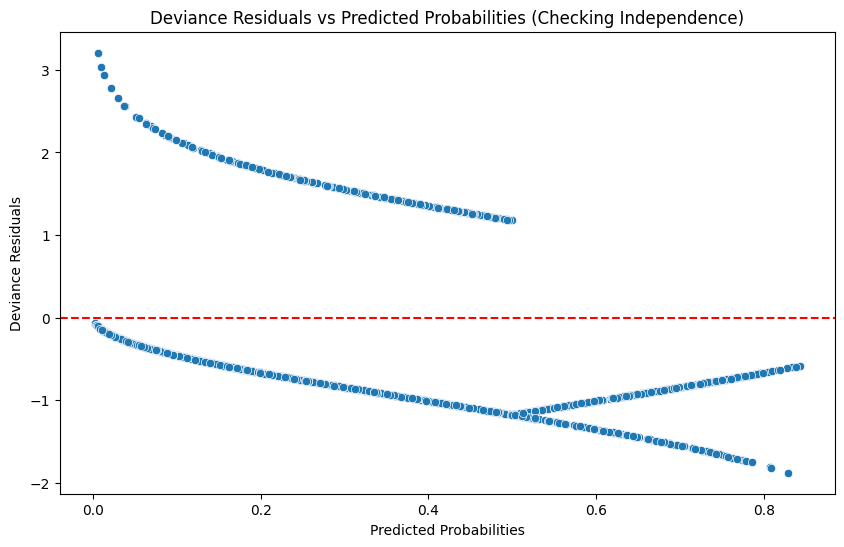

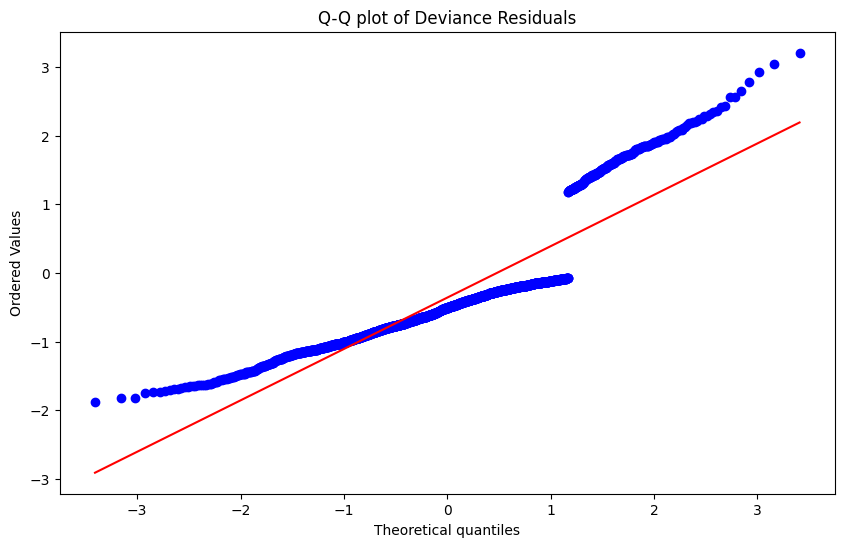

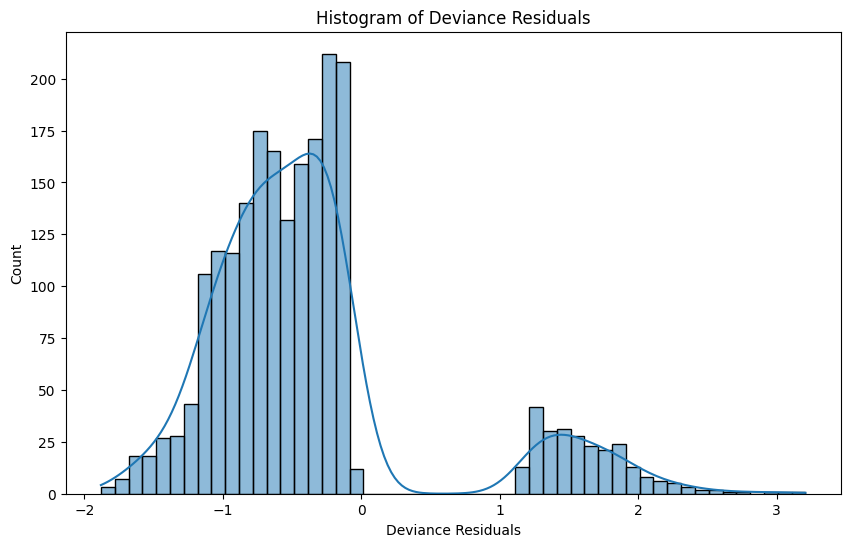

Durbin-Watson statistic: 1.6129528448776158


In [11]:
# Combine numerical and encoded categorical variables
X = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Get the predicted probabilities
y_pred_probs = log_reg.predict_proba(X_test)[:, 1]  # Get probabilities of class 1 (Churn=1)

# Calculate residuals
# For logistic regression, we use deviance residuals
y_pred = log_reg.predict(X_test)
deviance_residuals = np.sqrt(-2 * (y_test * np.log(y_pred_probs) + (1 - y_test) * np.log(1 - y_pred_probs)))
deviance_residuals *= np.where(y_test > y_pred, 1, -1)

# Plot residuals vs predicted probabilities to check for independence
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_probs, y=deviance_residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Deviance Residuals vs Predicted Probabilities (Checking Independence)')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Deviance Residuals')
plt.show()

# Additional diagnostic plots

# Q-Q plot of residuals
plt.figure(figsize=(10, 6))
stats.probplot(deviance_residuals, dist="norm", plot=plt)
plt.title("Q-Q plot of Deviance Residuals")
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(deviance_residuals, kde=True)
plt.title('Histogram of Deviance Residuals')
plt.xlabel('Deviance Residuals')
plt.show()

# Calculate and print Durbin-Watson statistic
from statsmodels.stats.stattools import durbin_watson
dw_statistic = durbin_watson(deviance_residuals)
print(f"Durbin-Watson statistic: {dw_statistic}")


Doesn't fit independence

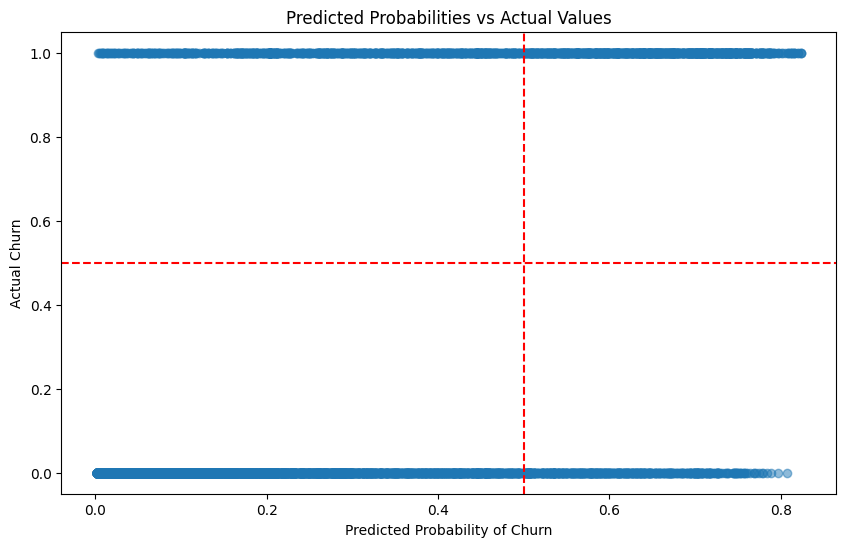

Number of potential outliers: 94
Indices of potential outliers: [ 268  317  320  335  430  658  811  842  975 1306 1494 1612 1780 1840
 1856 1928 1967 2029 2070 2127 2244 2287 2412 2529 2536 2614 2752 2775
 2780 2822 2894 3040 3326 3517 3577 3672 3694 3779 3788 3790 3799 3803
 3834 3844 3971 4078 4082 4149 4266 4272 4386 4418 4513 4539 4642 4698
 4734 4795 4819 4910 5086 5216 5270 5441 5475 5482 5579 5581 5589 5684
 5841 5900 5946 5947 5992 6038 6202 6289 6312 6321 6357 6424 6537 6608
 6680 6724 6757 6772 6785 6792 6813 6869 6945 6996]


In [12]:
# Combine numerical and encoded categorical variables
X = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X)[:, 1]

# Create a scatter plot of predicted probabilities vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_proba, y, alpha=0.5)
plt.title('Predicted Probabilities vs Actual Values')
plt.xlabel('Predicted Probability of Churn')
plt.ylabel('Actual Churn')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(x=0.5, color='r', linestyle='--')
plt.show()

# Identify potential outliers or influential points
threshold = 0.9  # You can adjust this threshold
potential_outliers = np.where((y == 0) & (y_pred_proba > threshold) |
                              (y == 1) & (y_pred_proba < (1 - threshold)))[0]

print(f"Number of potential outliers: {len(potential_outliers)}")
print("Indices of potential outliers:", potential_outliers)


No influential outliers

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.8489
Link Function:                     IdentityLink Log Likelihood:                                -17227.6646
Number of Samples:                         7043 AIC:                                            34555.0271
                                                AICc:                                           34555.7521
                                                GCV:                                                0.1448
                                                Scale:                                               0.143
                                                Pseudo R-Squared:                                   0.2715
Feature Function                  Lam

<ipython-input-13-73cddac957ba>:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


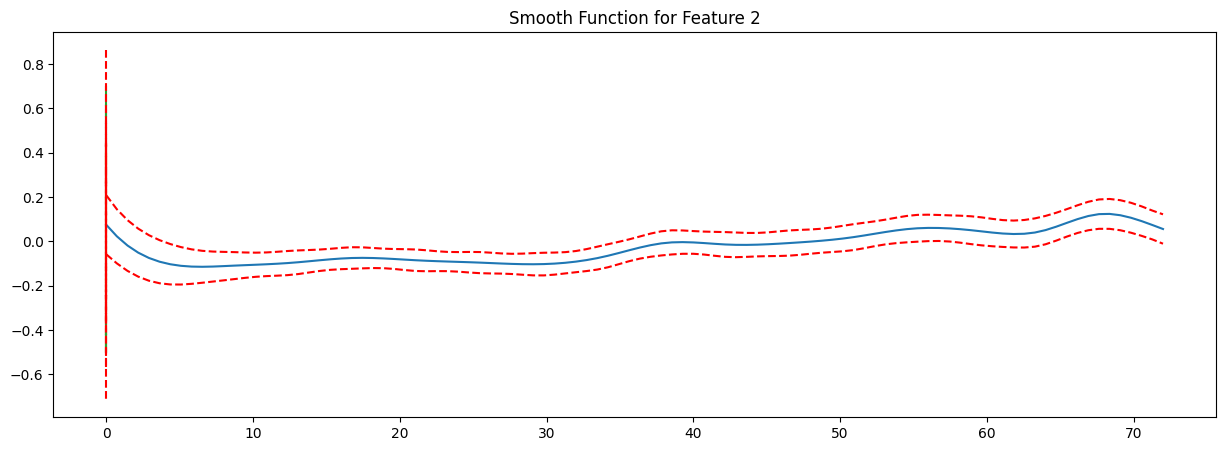

In [13]:
# Fit a GAM model with splines for each feature
gam = LinearGAM(s(0) + s(1) + s(2)).fit(X, y)

# Print summary of the model
print(gam.summary())

# Plot the smooth functions for each feature (excluding intercept term)
plt.figure(figsize=(15, 5))

# Loop through each term and check if it's an intercept before plotting
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue  # Skip the intercept term
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, 0], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, 0], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    plt.title(f"Smooth Function for Feature {i}")
plt.show()


fit smooth

2. Linear Regression

Linear Regression - Mean Squared Error (MSE) on Test Set: 0.13456685337282115
Linear Regression - R-squared on Test Set: 0.30866030093355634
Lasso Regression - Mean Squared Error (MSE) on Test Set: 0.1343108733074498
Lasso Regression - R-squared on Test Set: 0.30997540325574946
Ridge Regression - Mean Squared Error (MSE) on Test Set: 0.13442289541115646
Ridge Regression - R-squared on Test Set: 0.30939988762523407


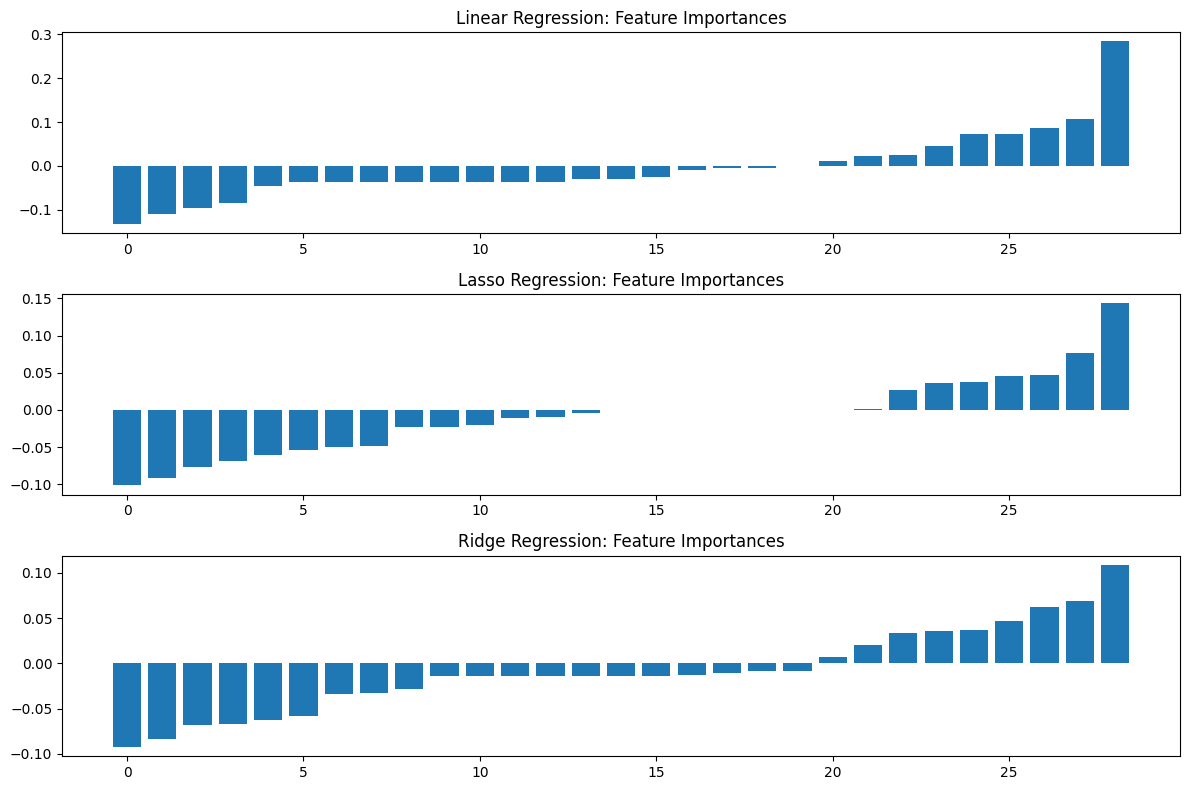


Linear Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     97.34
Date:                Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:29:10   Log-Likelihood:                -2478.8
No. Observations:                5634   AIC:                             5004.
Df Residuals:                    5611   BIC:                             5156.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.405e-01, tolerance: 1.119e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.282e-01, tolerance: 1.109e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-01, tolerance: 1.111e


Coefficients and p-values from Lasso Regression:
                                  Feature   Coefficient  P-value
9             InternetService_Fiber optic  1.435472e-01    0.000
27         PaymentMethod_Electronic check  7.615550e-02    0.000
22                    StreamingMovies_Yes  4.686615e-02    0.000
25                   PaperlessBilling_Yes  4.616163e-02    0.000
8                       MultipleLines_Yes  3.801625e-02    0.000
1                          MonthlyCharges  3.608926e-02    0.000
20                        StreamingTV_Yes  2.721051e-02    0.000
4                             Partner_Yes  1.367629e-03    0.268
7          MultipleLines_No phone service  1.371733e-15    0.000
26  PaymentMethod_Credit card (automatic) -0.000000e+00    0.932
21    StreamingMovies_No internet service -0.000000e+00    0.880
16                   DeviceProtection_Yes -0.000000e+00    0.980
28             PaymentMethod_Mailed check -0.000000e+00    0.960
17        TechSupport_No internet servic

In [42]:
# Step 1: Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale the numerical features (important for regression models)
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Step 3: Fit linear regression model on the training set
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Step 4: Fit Lasso regression model
lasso_model = Lasso(random_state=42)
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso_model, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_

# Step 5: Fit Ridge regression model
ridge_model = Ridge(random_state=42)
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_

# Step 6: Evaluate models on the test set
y_test_pred_linear = linear_model.predict(X_test)
y_test_pred_lasso = best_lasso.predict(X_test)
y_test_pred_ridge = best_ridge.predict(X_test)

# Step 7: Assess model performance on the test set
def print_model_performance(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - Mean Squared Error (MSE) on Test Set: {mse}")
    print(f"{model_name} - R-squared on Test Set: {r2}")

print_model_performance("Linear Regression", y_test, y_test_pred_linear)
print_model_performance("Lasso Regression", y_test, y_test_pred_lasso)
print_model_performance("Ridge Regression", y_test, y_test_pred_ridge)

# Step 8: Use statsmodels for more detailed output and coefficient interpretation (for Linear Regression)
X_train_with_const = sm.add_constant(X_train)  # Add constant for intercept
sm_model = sm.OLS(y_train, X_train_with_const).fit()  # Fit using statsmodels

# Step 10: Plot feature importance for each model
plt.figure(figsize=(12, 8))
plt.subplot(311)
linear_model.coef_.argsort()
plt.bar(range(len(linear_model.coef_)), linear_model.coef_[linear_model.coef_.argsort()])
plt.title("Linear Regression: Feature Importances")

plt.subplot(312)
best_lasso.coef_.argsort()
plt.bar(range(len(best_lasso.coef_)), best_lasso.coef_[best_lasso.coef_.argsort()])
plt.title("Lasso Regression: Feature Importances")

plt.subplot(313)
best_ridge.coef_.argsort()
plt.bar(range(len(best_ridge.coef_)), best_ridge.coef_[best_ridge.coef_.argsort()])
plt.title("Ridge Regression: Feature Importances")

plt.tight_layout()
plt.show()

# New function to calculate p-values using bootstrap
def calculate_pvalues(X, y, model, n_iterations=1000):
    n_samples, n_features = X.shape
    coef_bootstrap = np.zeros((n_iterations, n_features))

    for i in range(n_iterations):
        # Bootstrap resample
        indices = np.random.randint(0, n_samples, n_samples)
        X_resampled = X.iloc[indices]
        y_resampled = y.iloc[indices]

        # Fit the model
        model.fit(X_resampled, y_resampled)
        coef_bootstrap[i, :] = model.coef_

    # Calculate p-values
    p_values = np.sum(coef_bootstrap < 0, axis=0) / n_iterations
    p_values = np.minimum(p_values, 1 - p_values) * 2  # Two-tailed test

    return p_values

# Calculate and print p-values for each model
def print_coefficients_with_pvalues(model, model_name, X, y):
    coefficients = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    })

    p_values = calculate_pvalues(X, y, model)
    coefficients['P-value'] = p_values

    coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
    print(f"\nCoefficients and p-values from {model_name}:")
    print(coefficients)

# Linear Regression (using statsmodels for p-values)
X_train_with_const = sm.add_constant(X_train)
sm_model = sm.OLS(y_train, X_train_with_const).fit()
print("\nLinear Regression Summary:")
print(sm_model.summary())

# Lasso Regression
print_coefficients_with_pvalues(best_lasso, "Lasso Regression", X_train, y_train)

# Ridge Regression
print_coefficients_with_pvalues(best_ridge, "Ridge Regression", X_train, y_train)

The coefficient in this regression represent 1 unit increase for the variable or the condition fit for the situation (for categorical variables), it's expected to cause amount change equals to the coefficient to the churn.

Due to the multicolinearity, the P value in linear regression doesn't make sense. Lasso and ridge could be better reference.

3. Logistic Regression (Asked ChatGPT for model evaluation)

In [59]:
# Step 1: Identify numerical and categorical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'customerID']

# Step 2: One-hot encoding for categorical variables, dropping the first category to avoid multicollinearity
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Step 3: Create a new DataFrame with encoded variables
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names, index=df.index)

# Step 4: Combine encoded categorical variables with numerical variables
X = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Churn']

# Step 5: Split the data into training and testing sets (80% training, 20% testing)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Check for multicollinearity using VIF (Variance Inflation Factor) on training set only
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
print(vif)

# Optionally, drop columns with high VIF values (e.g., VIF > 10) from training and testing sets
high_vif_cols = vif[vif["VIF Factor"] > 10]["features"].tolist()
if high_vif_cols:
    print(f"\nDropping columns with high VIF to avoid multicollinearity: {high_vif_cols}")
    X_train.drop(columns=high_vif_cols, inplace=True)
    X_test.drop(columns=high_vif_cols, inplace=True)

# Step 7: Fit logistic model using sklearn on the training set
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Step 8: Use statsmodels for more detailed output and coefficient interpretation on training set
X_train_with_const = sm.add_constant(X_train)  # Add constant for intercept
sm_logit_model = sm.Logit(y_train, X_train_with_const).fit()  # Fit the logistic regression model using statsmodels
print(sm_logit_model.summary())  # Output detailed model summary

# Step 9: Predict probabilities and classes on the test set using sklearn logistic regression
y_test_pred_prob = log_model.predict_proba(X_test)[:, 1]  # Get probabilities of the positive class (Churn = 1)
y_test_pred_class = log_model.predict(X_test)  # Get predicted classes (0 or 1)

# Step 10: Confusion matrix and classification report on test set
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred_class))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_class))


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


     VIF Factor                               features
0      7.361048                                 tenure
1    874.602148                         MonthlyCharges
2     10.703696                           TotalCharges
3      1.002763                            gender_Male
4      1.444878                            Partner_Yes
5      1.333842                         Dependents_Yes
6   1785.087393                       PhoneService_Yes
7     62.063208         MultipleLines_No phone service
8      7.379239                      MultipleLines_Yes
9    149.979728            InternetService_Fiber optic
10          inf                     InternetService_No
11          inf     OnlineSecurity_No internet service
12     6.457061                     OnlineSecurity_Yes
13          inf       OnlineBackup_No internet service
14     6.879472                       OnlineBackup_Yes
15          inf   DeviceProtection_No internet service
16     6.988524                   DeviceProtection_Yes
17        

const = -0.5382: This suggests that when all other variables are held at zero, the log odds of churn is approximately -0.5382, which indicates a low probability of churn.

tenure = -0.0277: For each additional month of tenure, the log odds of churn decreases by 0.0277, implying that customers with longer tenure are less likely to churn.

gender_Male = -0.0614: Being male decreases the log odds of churn by 0.0614, but this effect is not statistically significant (p-value = 0.379).

Partner_Yes = 0.1227: Having a partner increases the log odds of churn by 0.1227, but this is not statistically significant (p-value = 0.142), so the relationship might not be reliable.

Dependents_Yes = -0.3477: Having dependents decreases the log odds of churn by 0.3477, indicating that customers with dependents are less likely to churn.

MultipleLines_Yes = 0.5323: Customers with multiple lines experience an increase in the log odds of churn by 0.5323, suggesting that they are more likely to churn.

OnlineSecurity_Yes = -0.3668: Using online security services decreases the log odds of churn by 0.3668, indicating that customers with online security are less likely to churn.

OnlineBackup_Yes = 0.0205: Having online backup services slightly increases the log odds of churn by 0.0205, but this effect is not statistically significant (p-value = 0.804).

DeviceProtection_Yes = 0.3328: Customers with device protection experience an increase in the log odds of churn by 0.3328, indicating a higher likelihood of churn.

TechSupport_Yes = -0.2143: Access to tech support decreases the log odds of churn by 0.2143, implying that tech support helps retain customers.

Contract_One year = -0.9137: Being on a one-year contract significantly decreases the log odds of churn by 0.9137, showing a strong negative association with churn.

Contract_Two year = -1.9268: Similarly, being on a two-year contract reduces the log odds of churn even more significantly by 1.9268, indicating a very strong negative association with churn.

PaperlessBilling_Yes = 0.6023: Opting for paperless billing increases the log odds of churn by 0.6023, suggesting that customers with paperless billing are more likely to churn.

PaymentMethod_Credit card (automatic) = -0.1137: Paying by credit card slightly decreases the log odds of churn by 0.1137, but this effect is not statistically significant (p-value = 0.352).

PaymentMethod_Electronic check = 0.5433: Using electronic checks for payments increases the log odds of churn by 0.5433, indicating a higher likelihood of churn.

PaymentMethod_Mailed check = -0.3238: Using mailed checks for payment decreases the log odds of churn by 0.3238, suggesting that mailed check users are less likely to churn.

4. GAM

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     55.1895
Link Function:                        LogitLink Log Likelihood:                                 -2278.4046
Number of Samples:                         5634 AIC:                                              4667.188
                                                AICc:                                            4668.3405
                                                UBRE:                                               2.8362
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3013
Feature Function                  Lam

<ipython-input-64-3f78cc770b93>:39: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())  # Show the usual summary


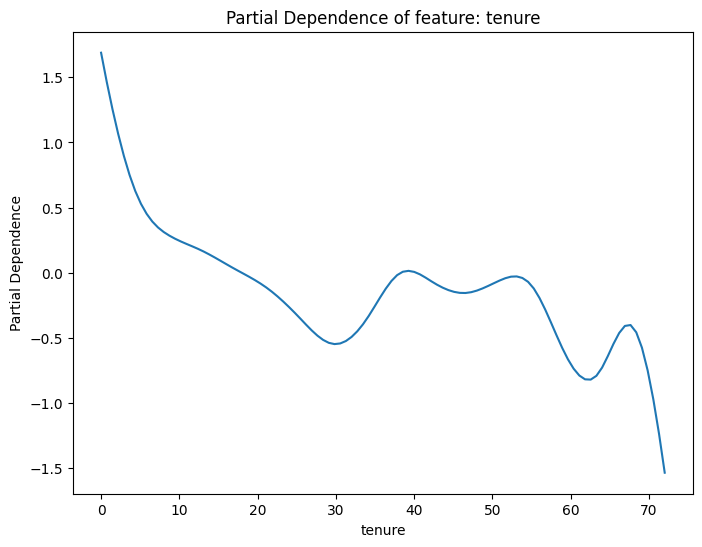

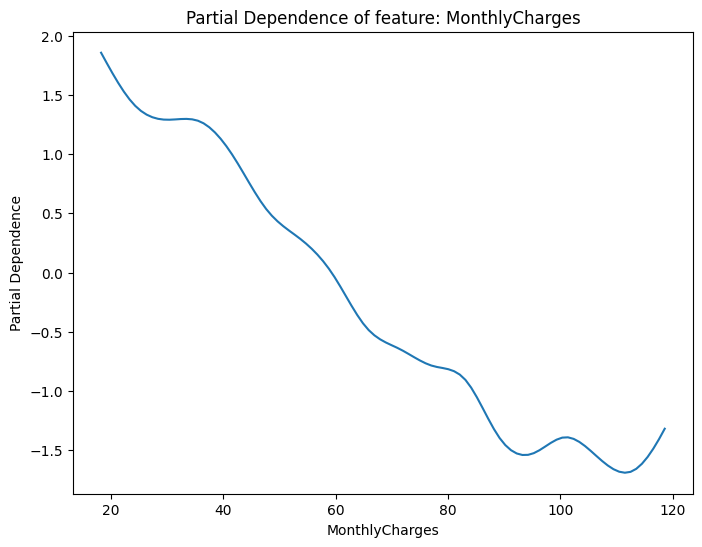

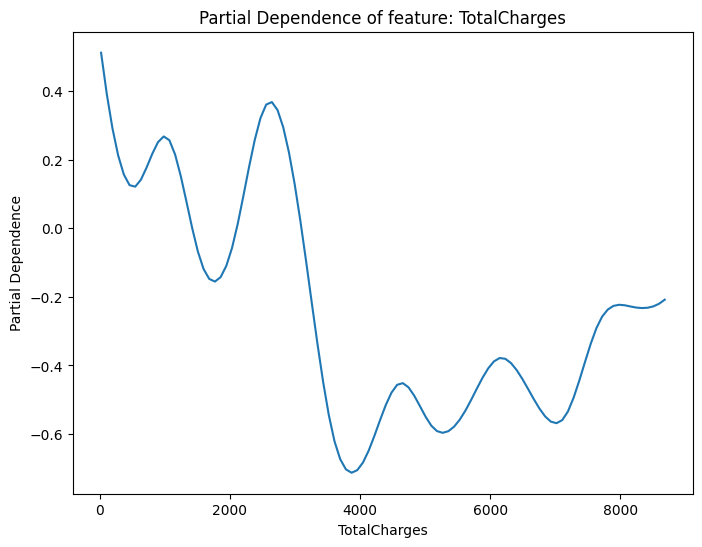

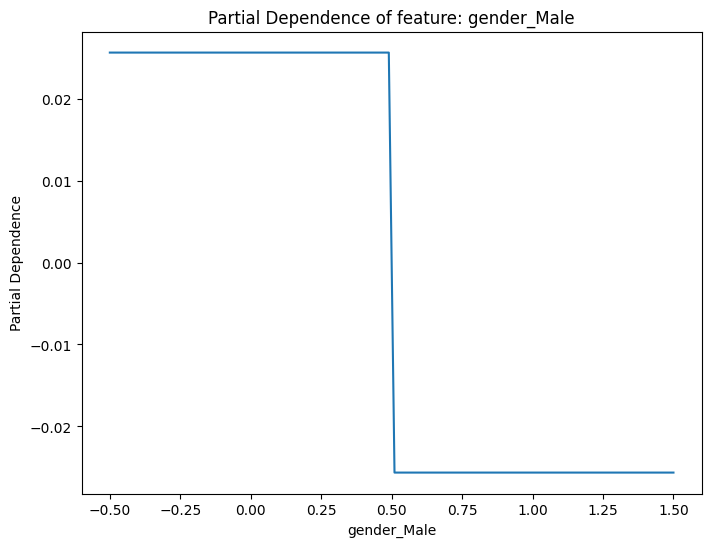

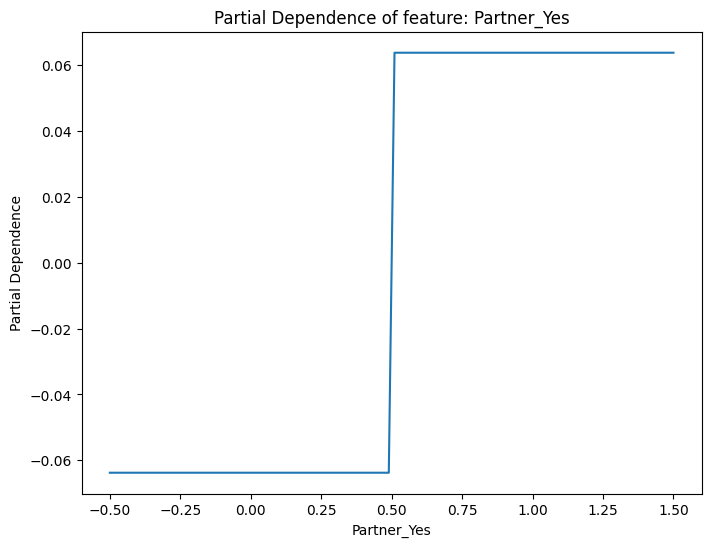

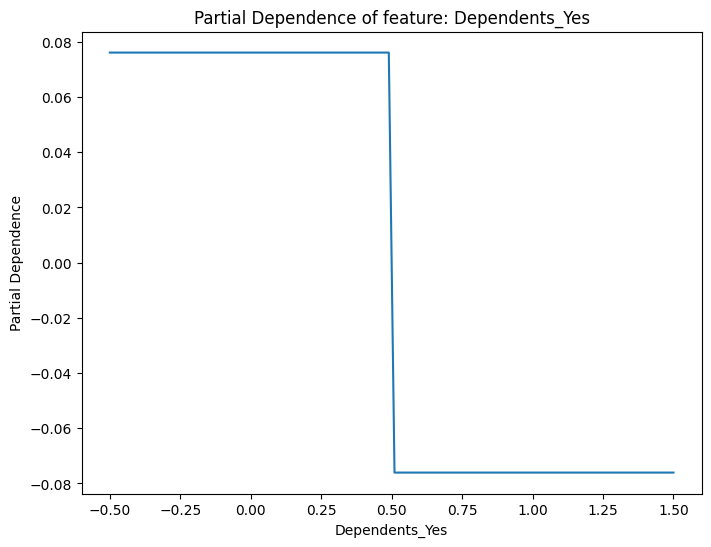

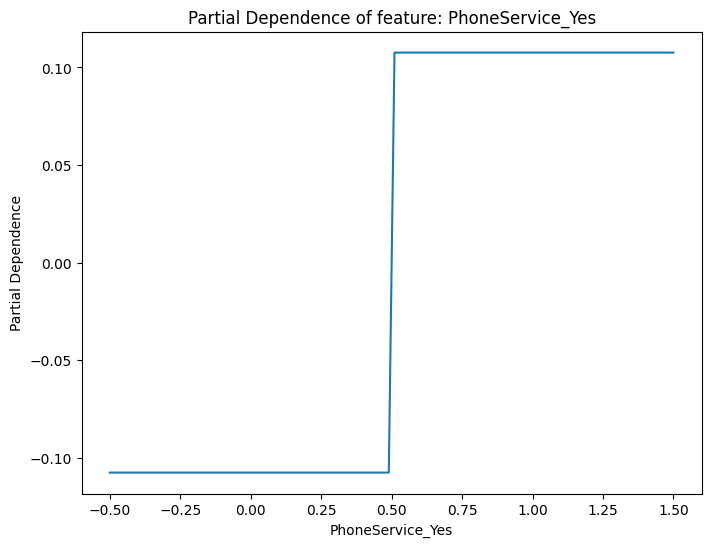

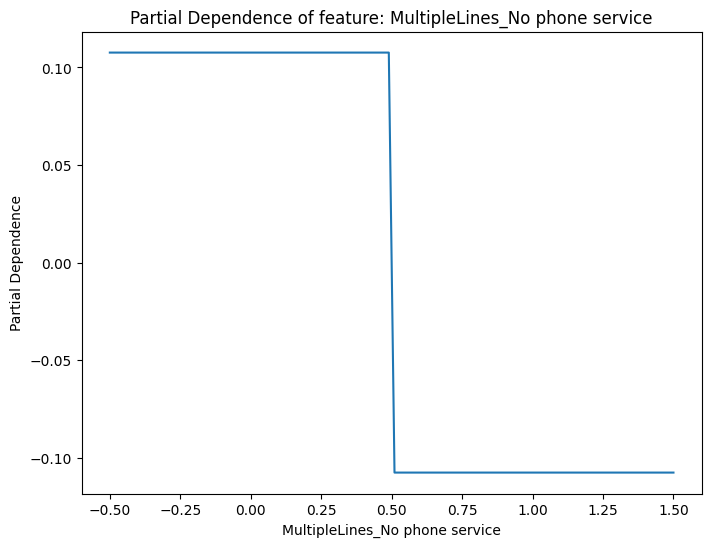

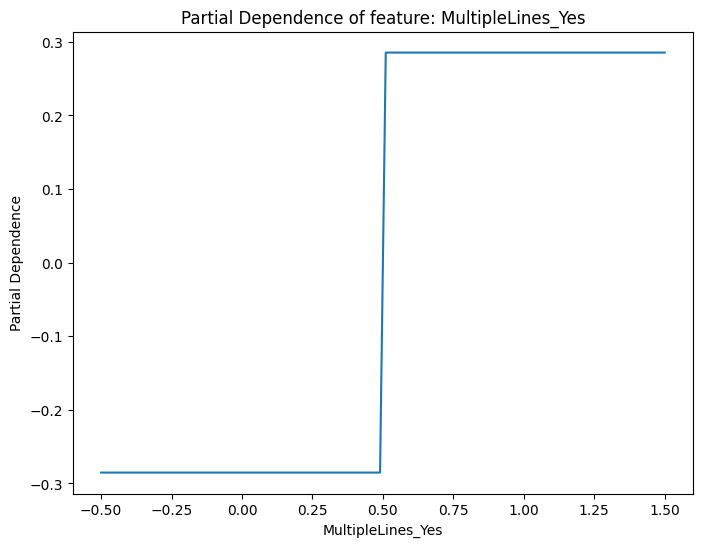

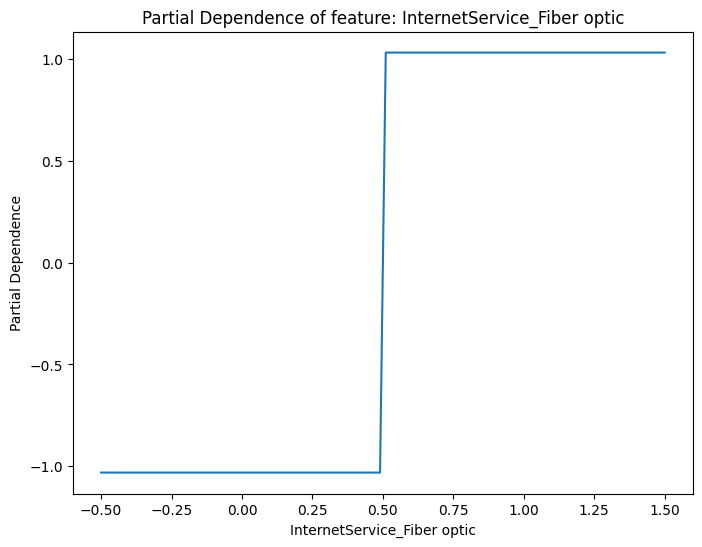

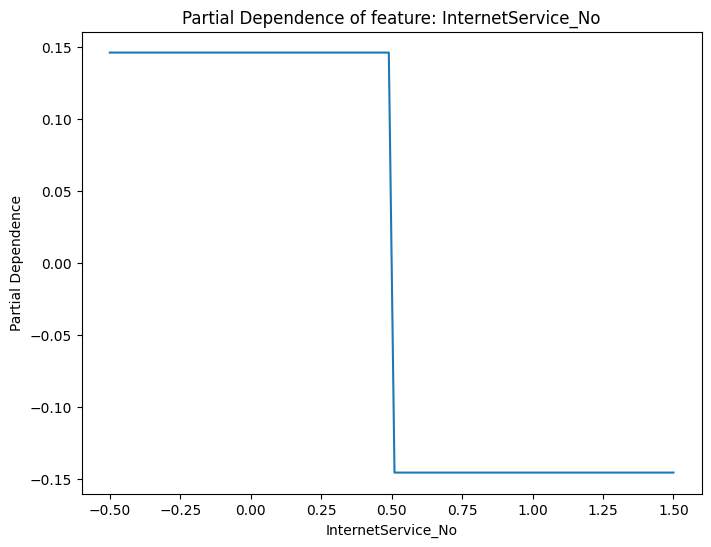

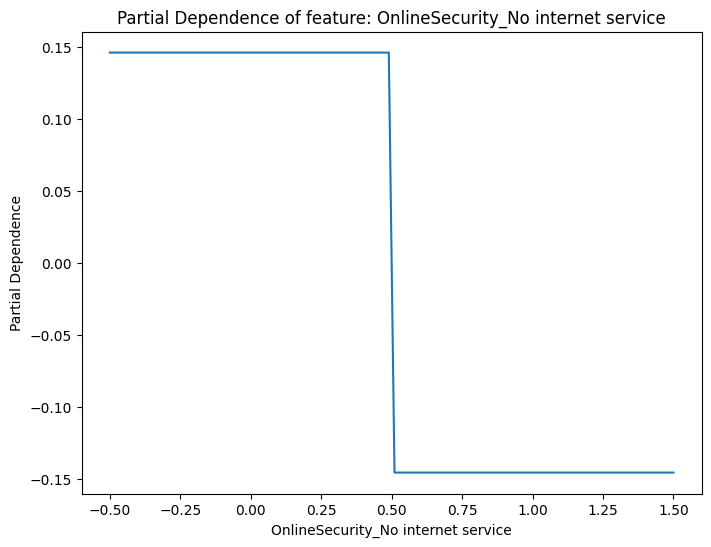

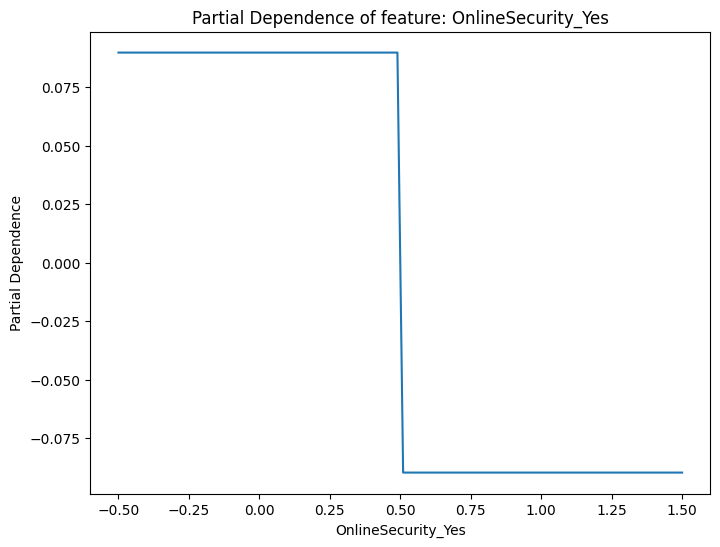

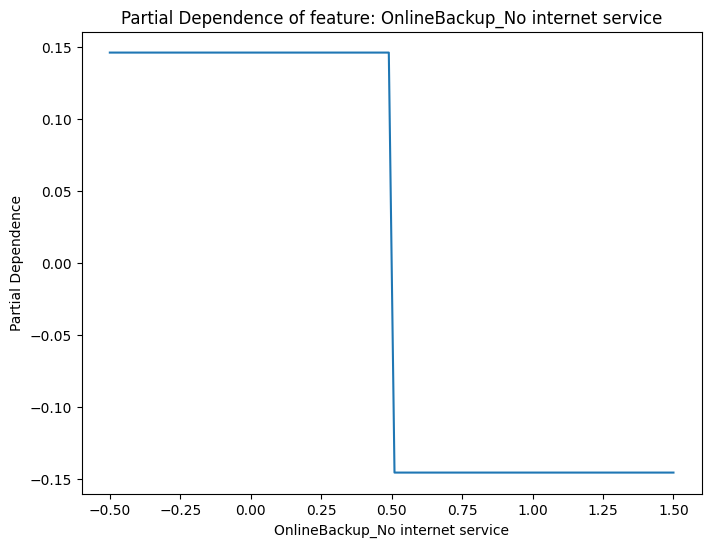

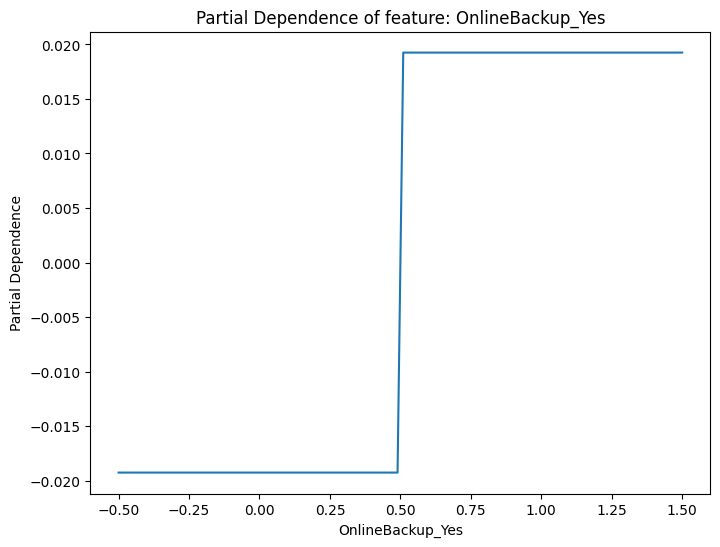

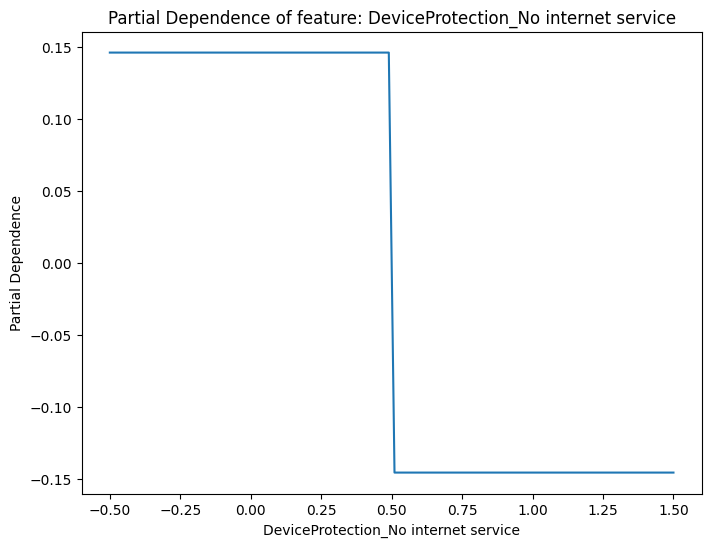

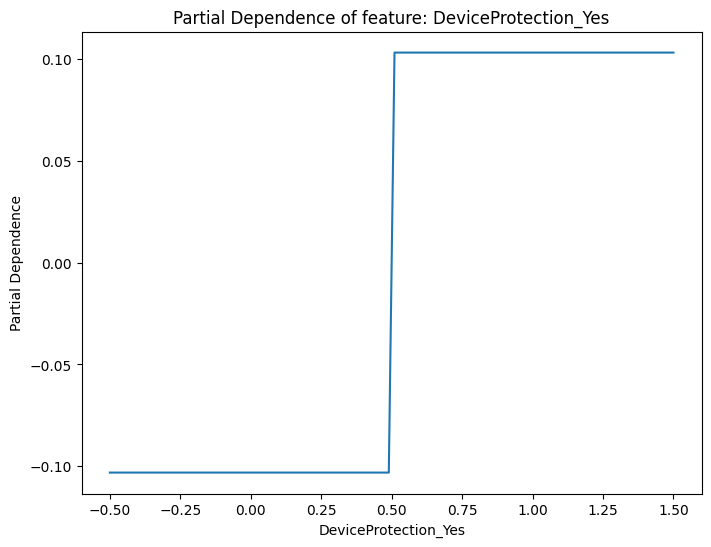

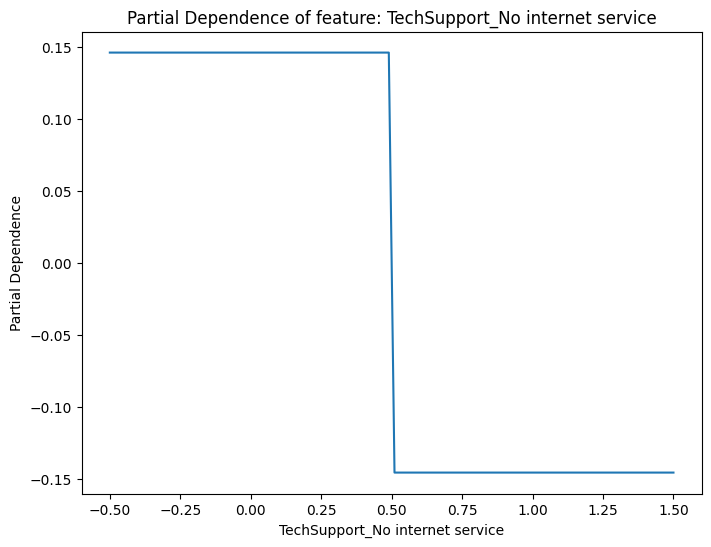

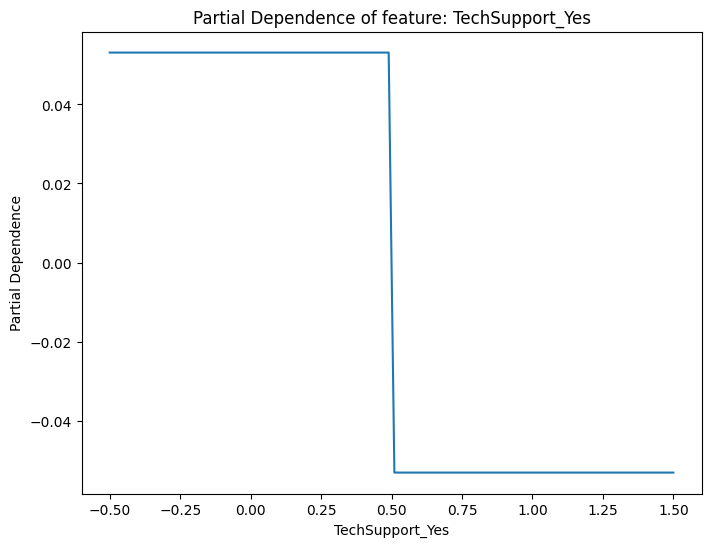

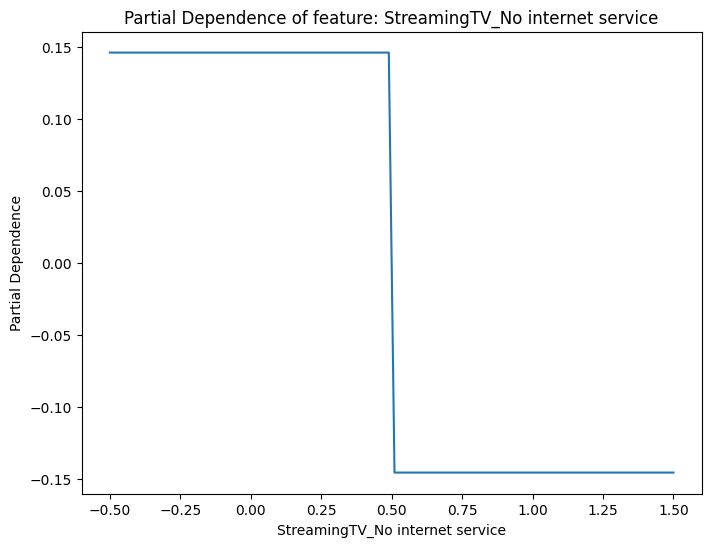

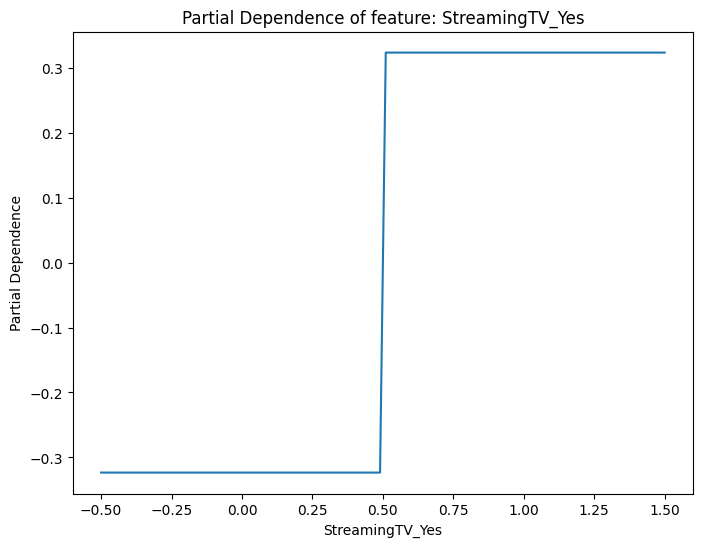

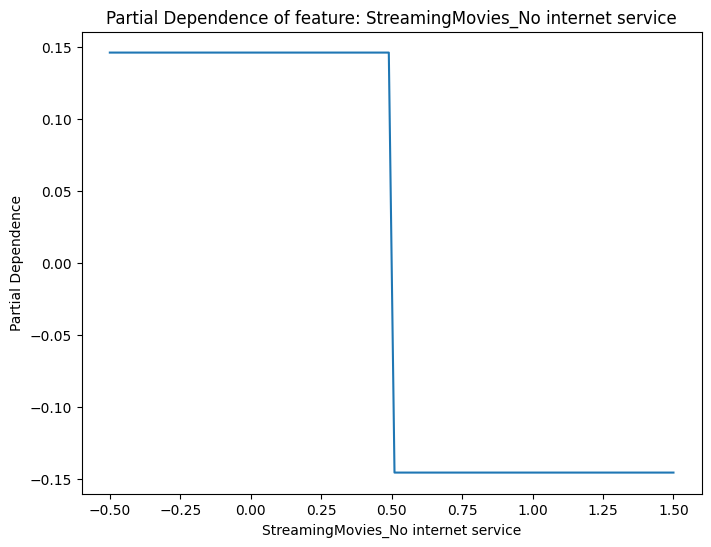

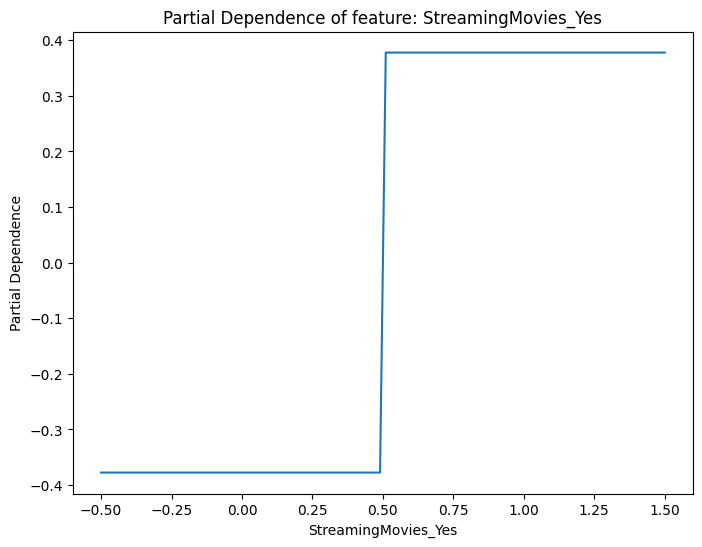

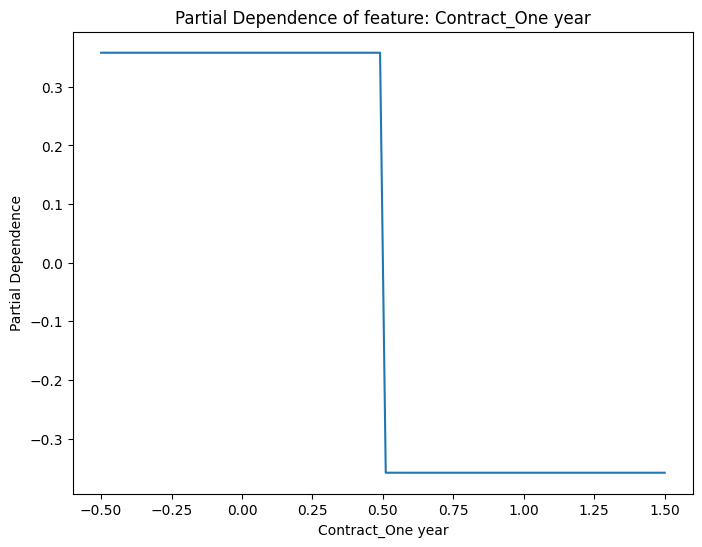

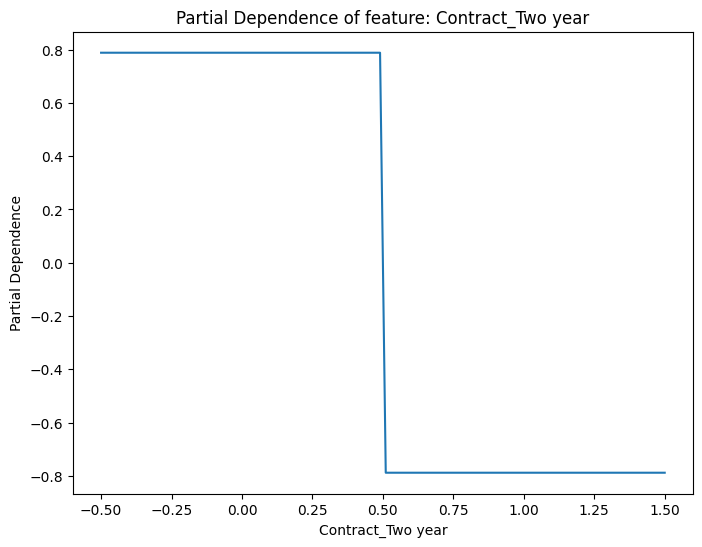

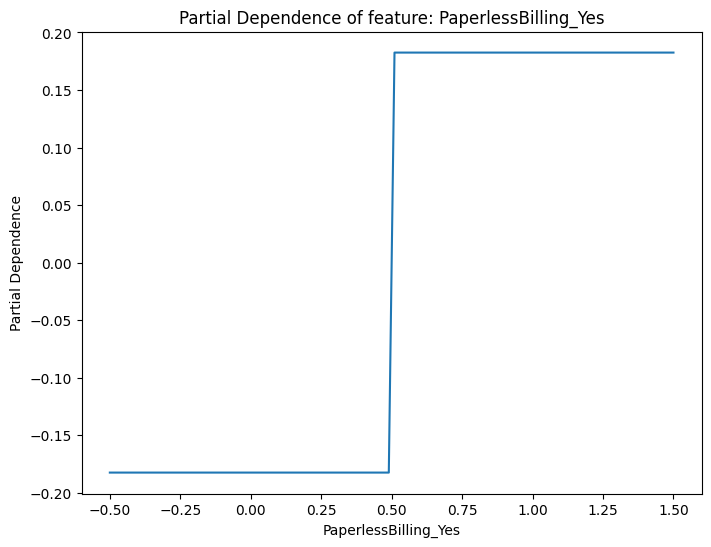

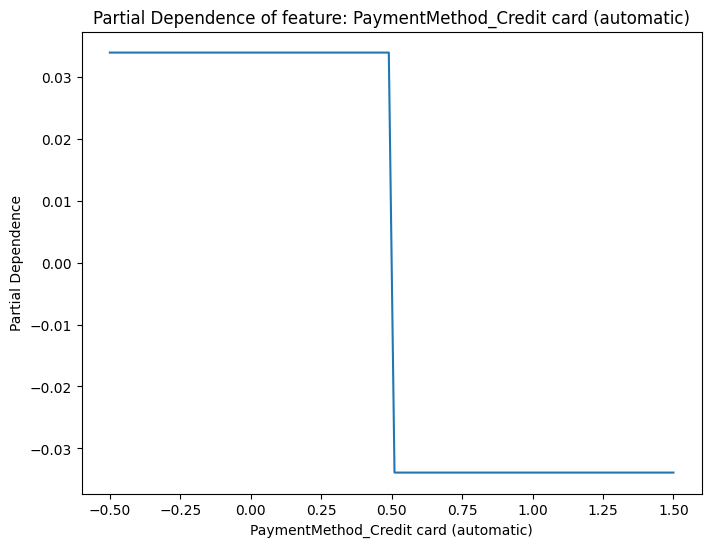

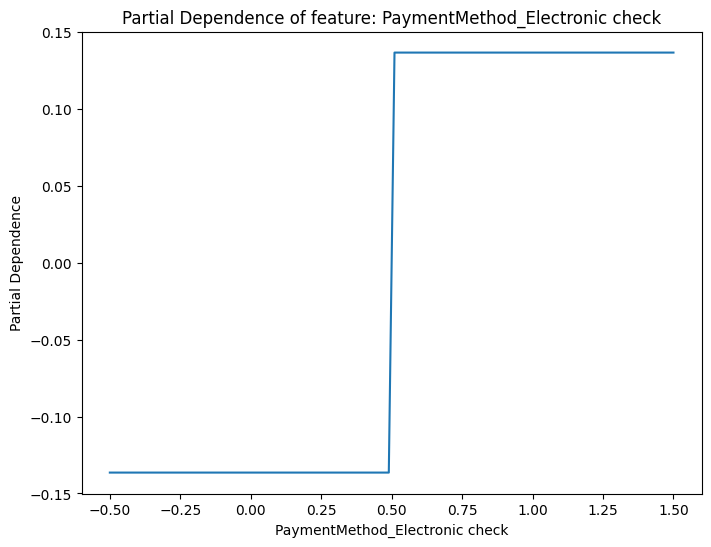

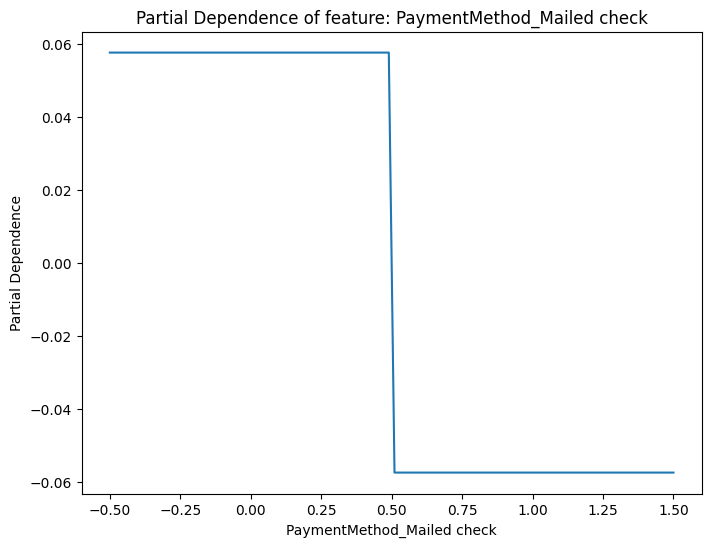

In [64]:
# Step 1: Define numerical and categorical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                   'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                   'PaperlessBilling', 'PaymentMethod']

# Step 2: Apply OneHotEncoder with drop='first' to avoid multicollinearity
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Create a new dataframe with encoded variables
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names)

# Combine encoded categorical variables with numerical variables
combined_df = pd.concat([df[numerical_cols], encoded_df, df['Churn']], axis=1)

# Prepare feature matrix X and target variable y
X = combined_df.drop('Churn', axis=1)
y = combined_df['Churn']

# Step 3: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Build the GAM model using smooth functions for numerical variables
# and factor functions for encoded categorical variables
gam_formula = s(0) + s(1) + s(2)  # Smooth terms for the numerical variables

# Dynamically add the encoded categorical terms
for i in range(len(numerical_cols), X.shape[1]):
    gam_formula += f(i)

# Step 5: Add regularization using the lambda (lam) parameter in GAM
# Set lam=0.6 as an example for regularization, this can be tuned based on your model performance
gam = LogisticGAM(gam_formula, lam=0.6).fit(X_train, y_train)

# Step 6: View the model summary
print(gam.summary())  # Show the usual summary

# Step 7: Map f(i) terms to the original categorical variable names
# Combine numerical and encoded feature names
feature_names = numerical_cols + list(encoded_feature_names)

# Print mapping between f(i) and feature names
print("\nFeature Mapping:")
for i, feature_name in enumerate(feature_names):  # Corrected: start from f(0)
    print(f"f({i}) corresponds to feature: '{feature_name}'")

# Step 8: Predict on the test set and evaluate the model
y_pred = gam.predict(X_test)

# Step 9: Visualize the smooth functions for each numerical and categorical feature
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)

    # Visualize only smooth functions for numerical features
    plt.figure(figsize=(8, 6))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f"Partial Dependence of feature: {feature_names[i]}")
    plt.xlabel(feature_names[i])
    plt.ylabel("Partial Dependence")
    plt.show()


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     55.1895
Link Function:                        LogitLink Log Likelihood:                                 -2278.4046
Number of Samples:                         5634 AIC:                                              4667.188
                                                AICc:                                            4668.3405
                                                UBRE:                                               2.8362
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3013
Feature Function                  Lam

<ipython-input-61-7ef0fda3fed3>:38: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())  # Show the usual summary


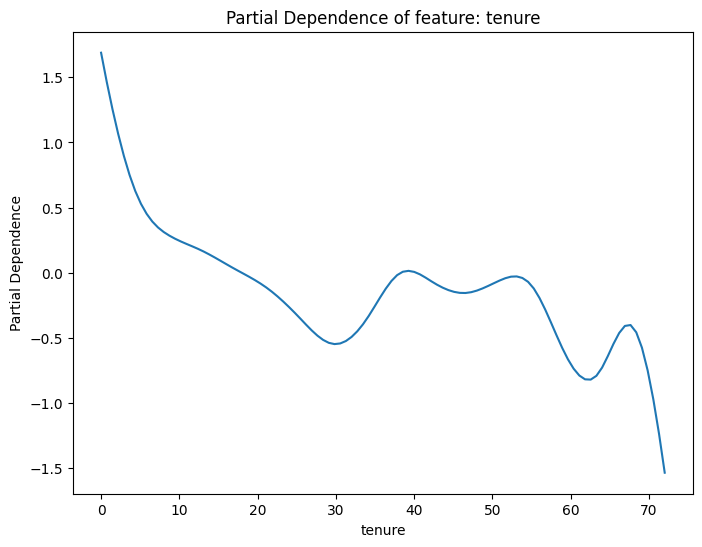

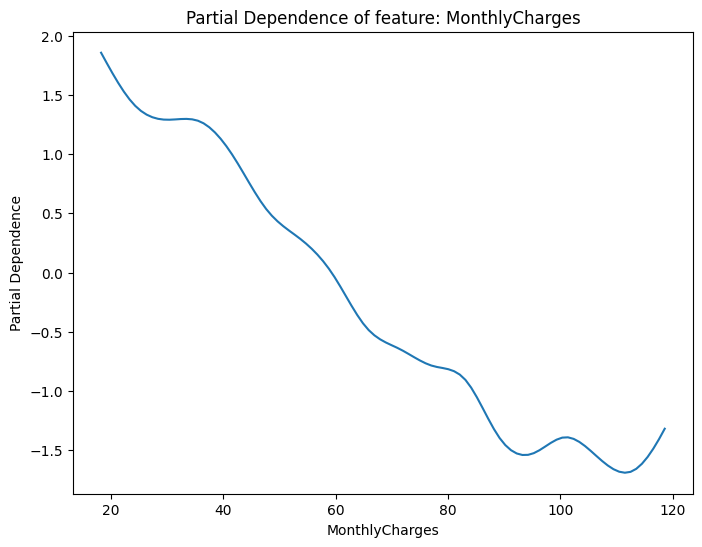

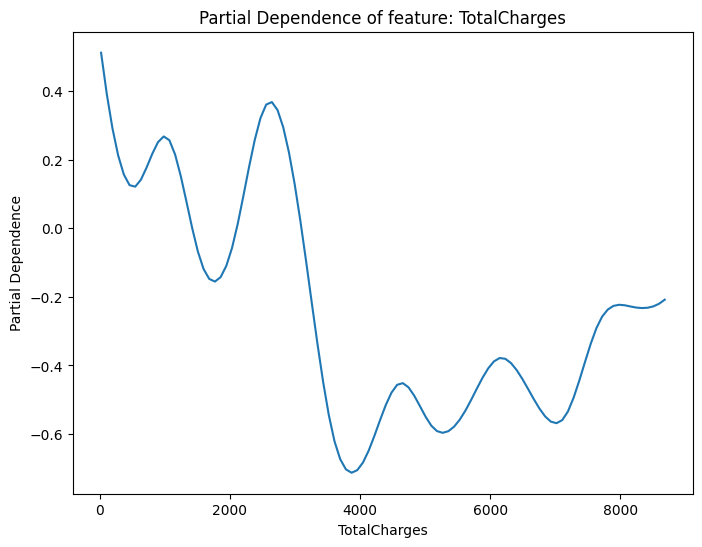

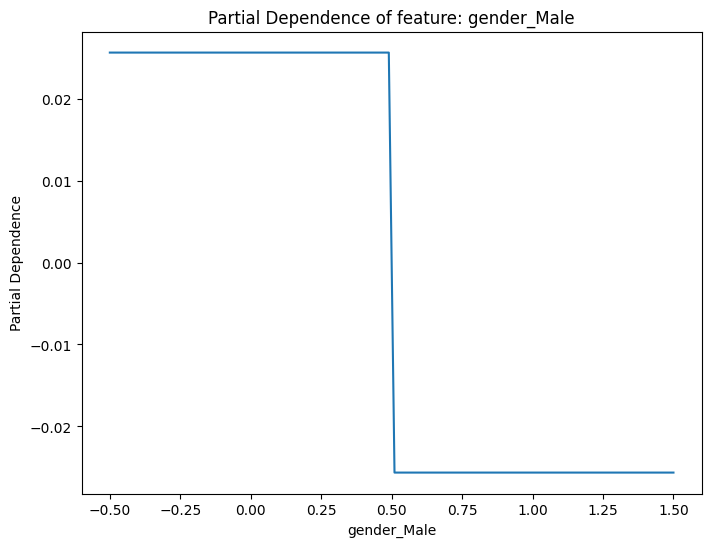

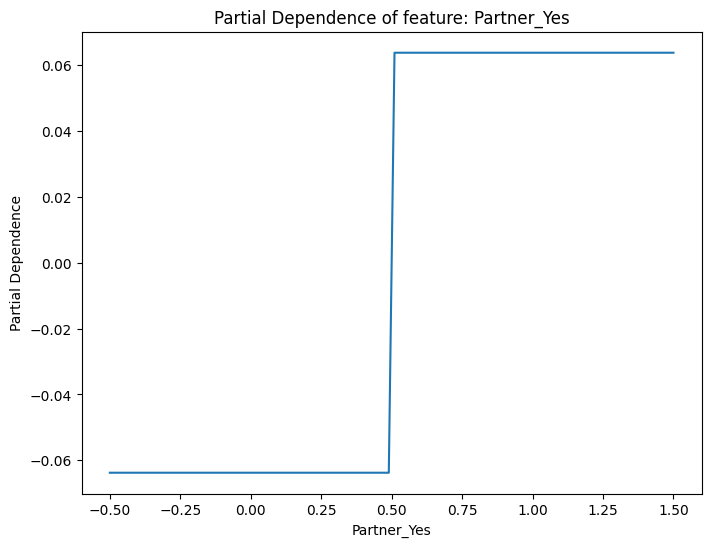

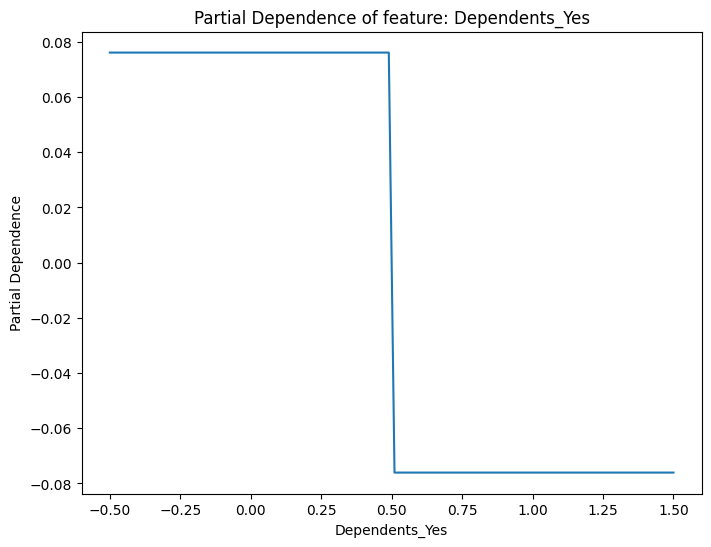

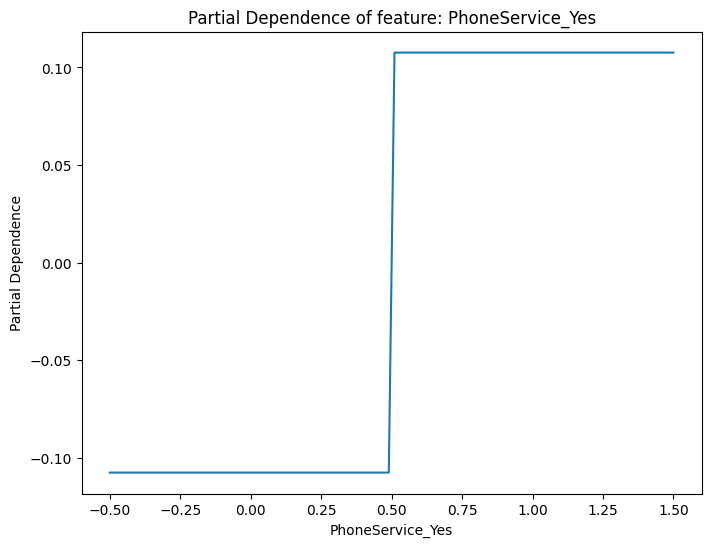

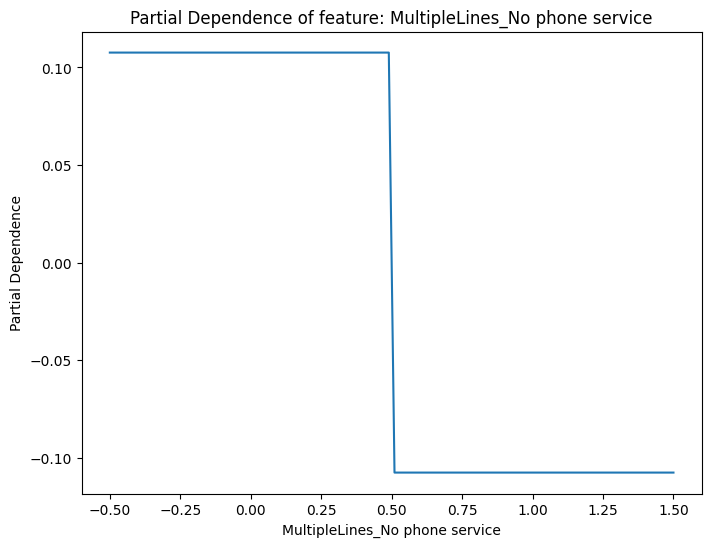

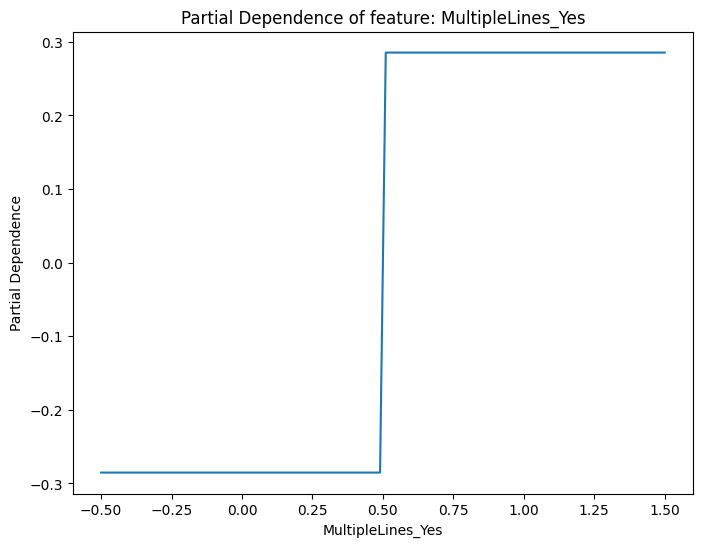

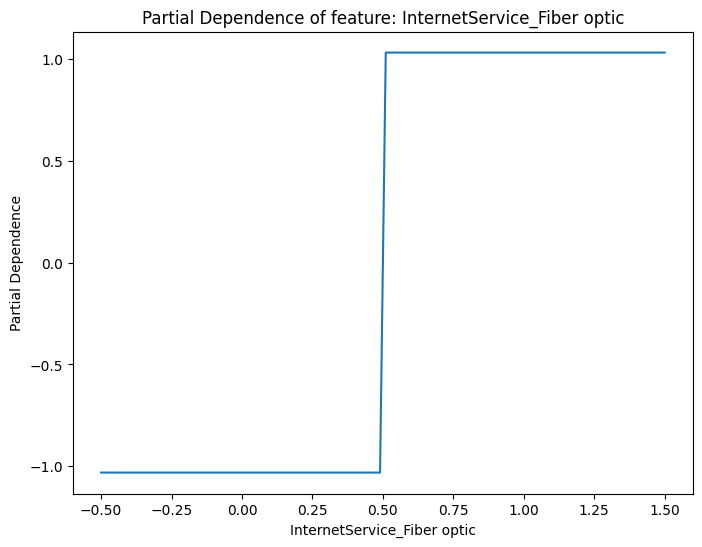

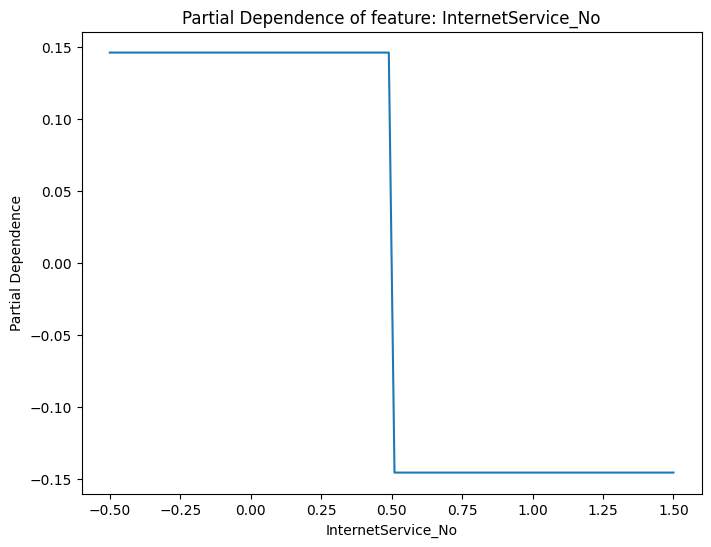

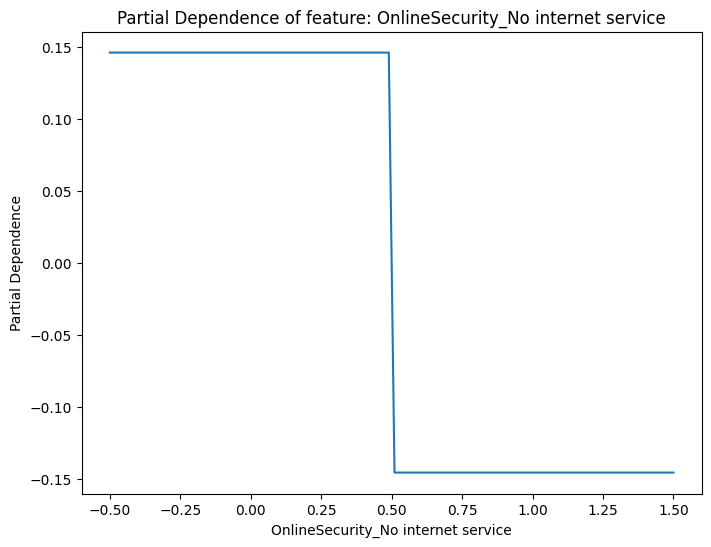

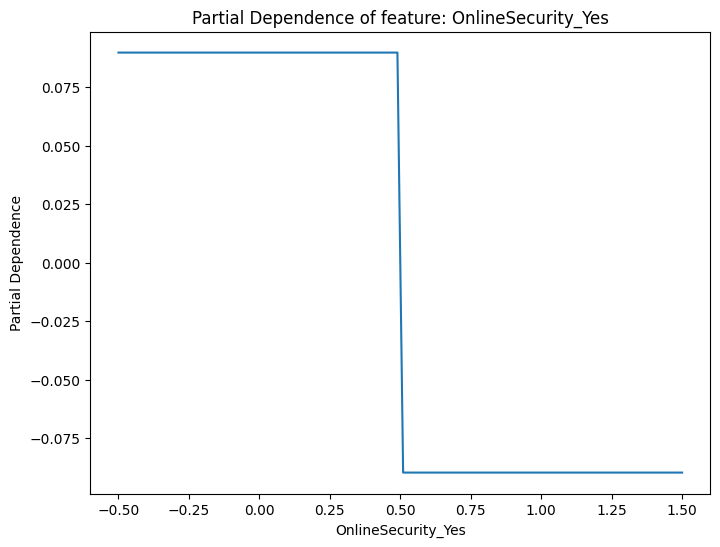

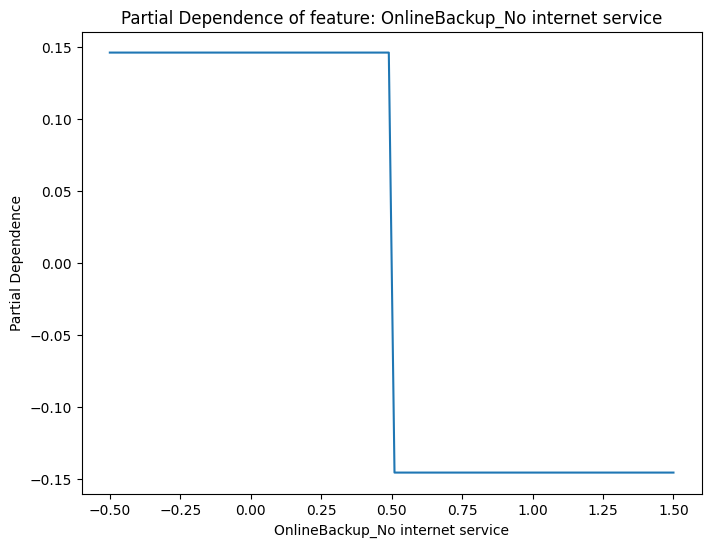

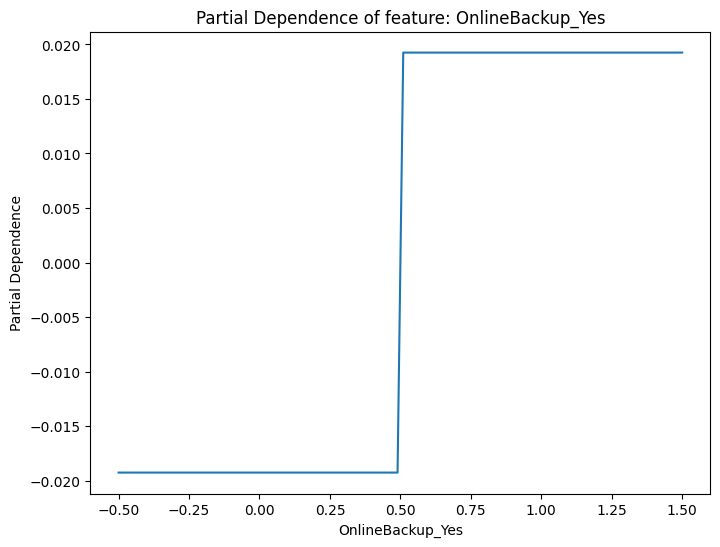

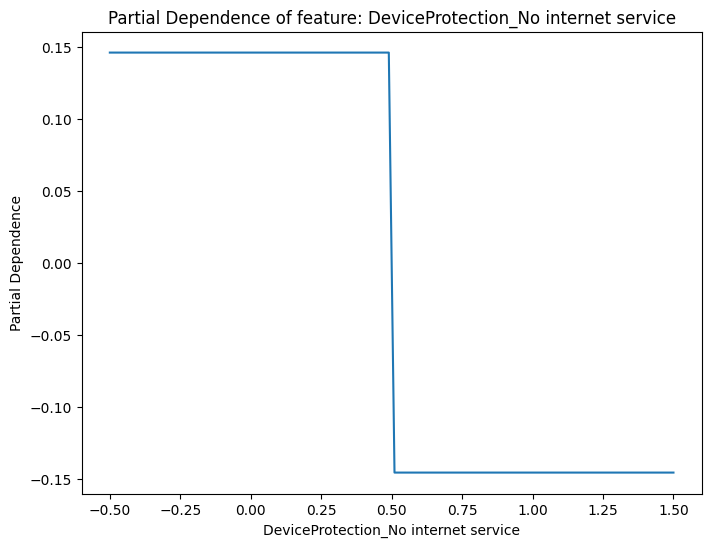

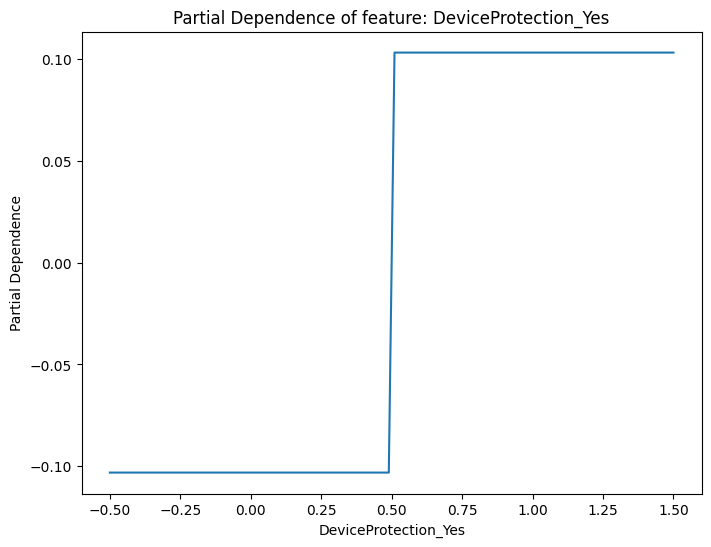

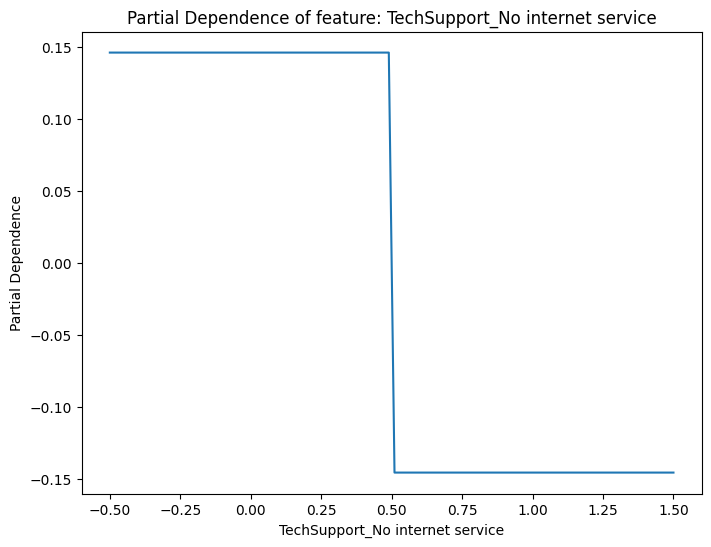

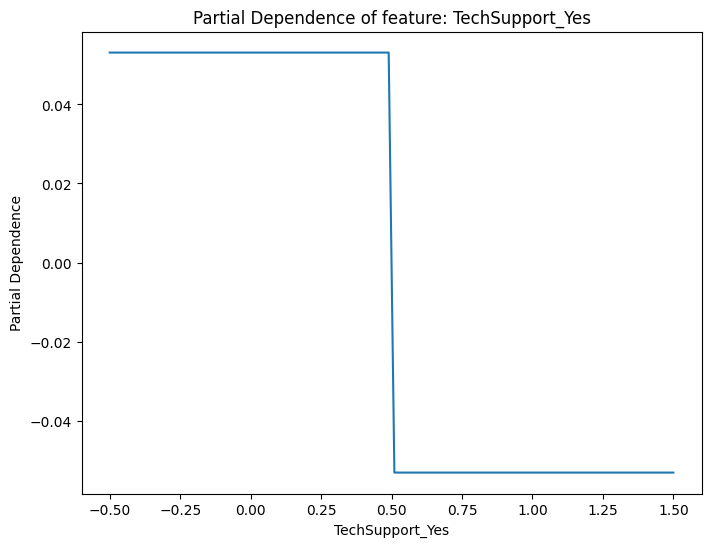

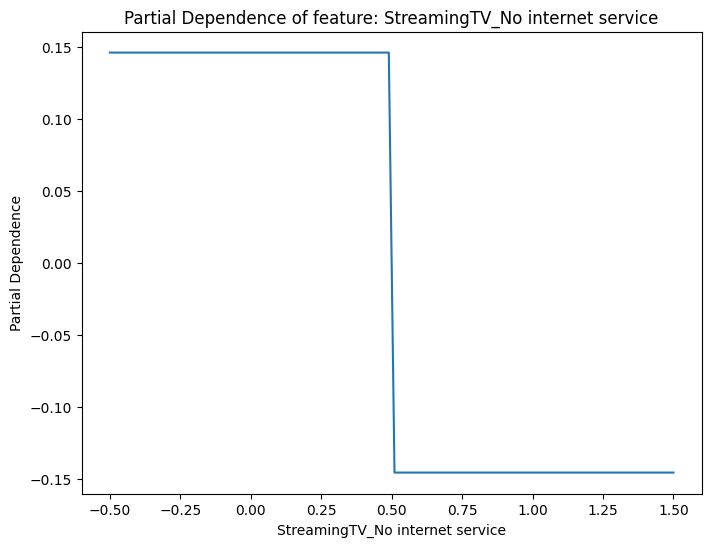

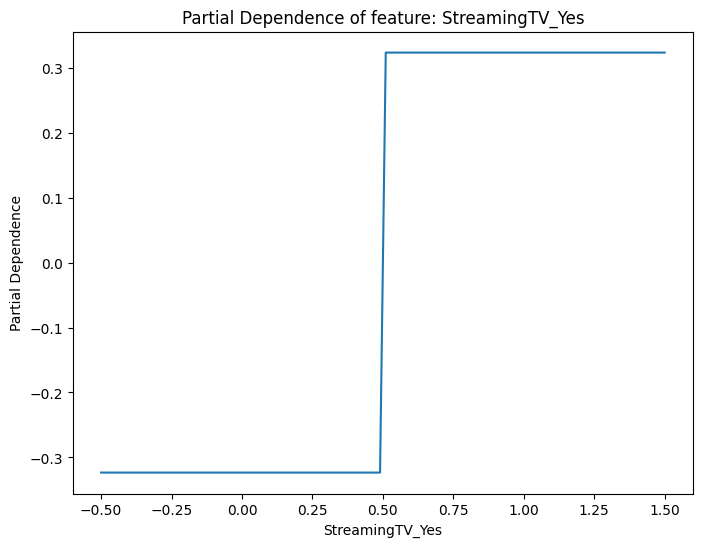

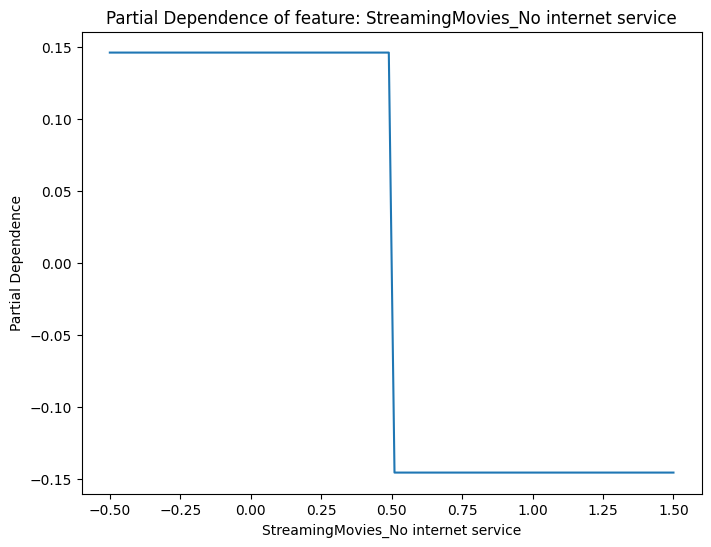

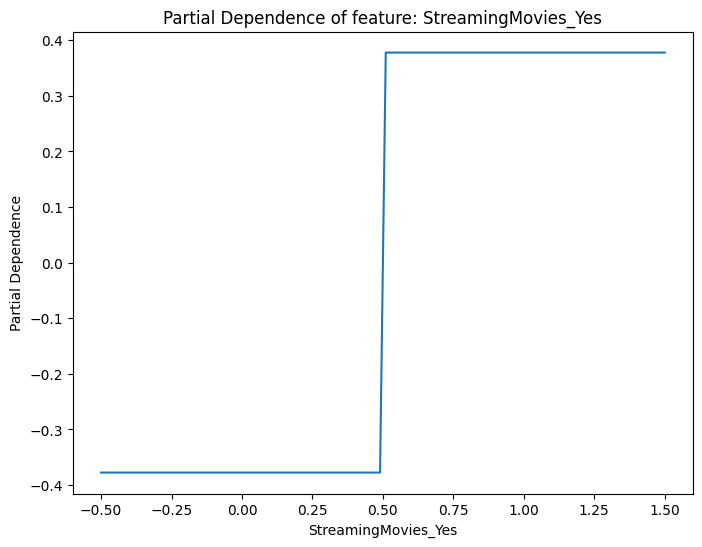

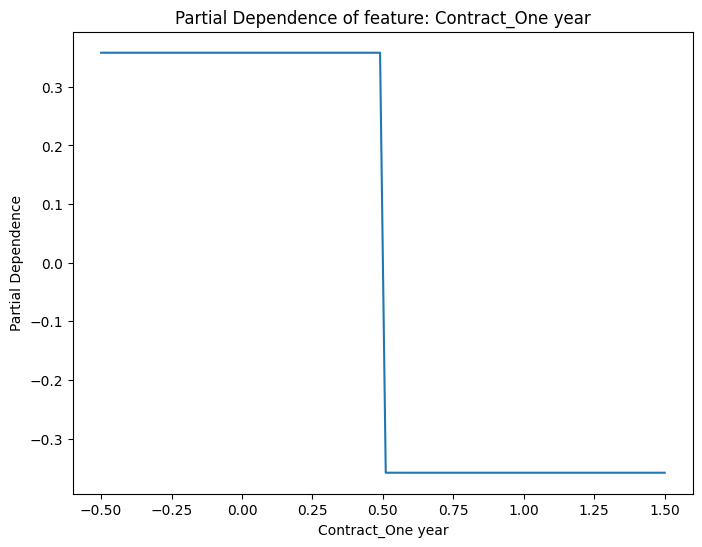

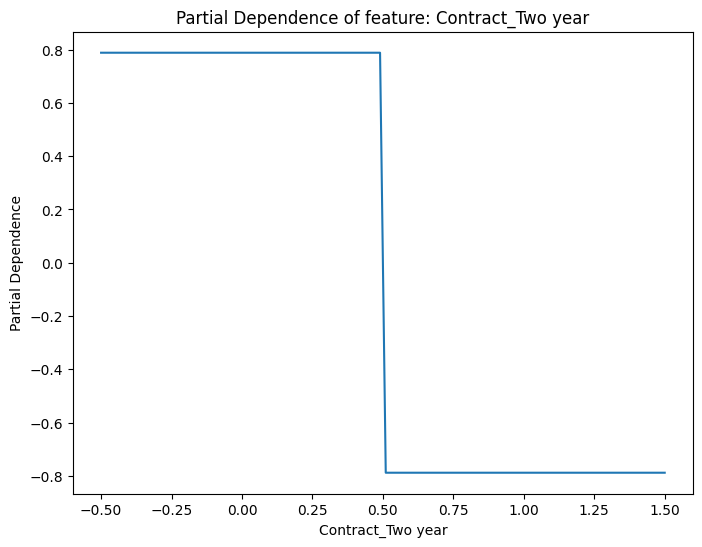

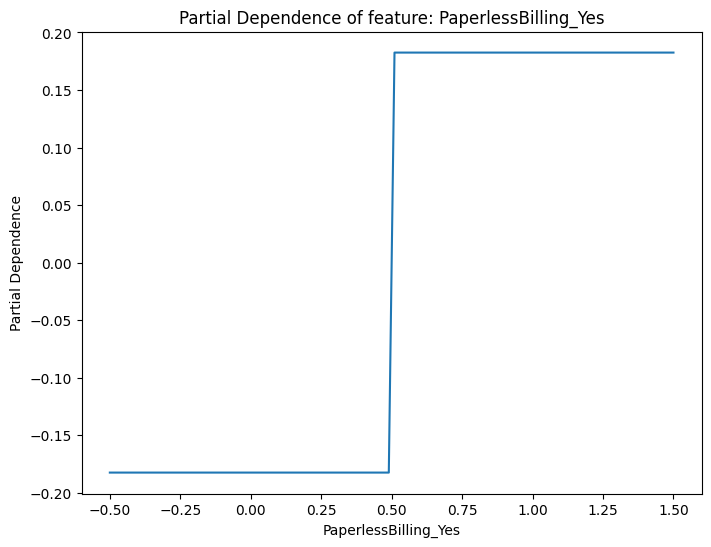

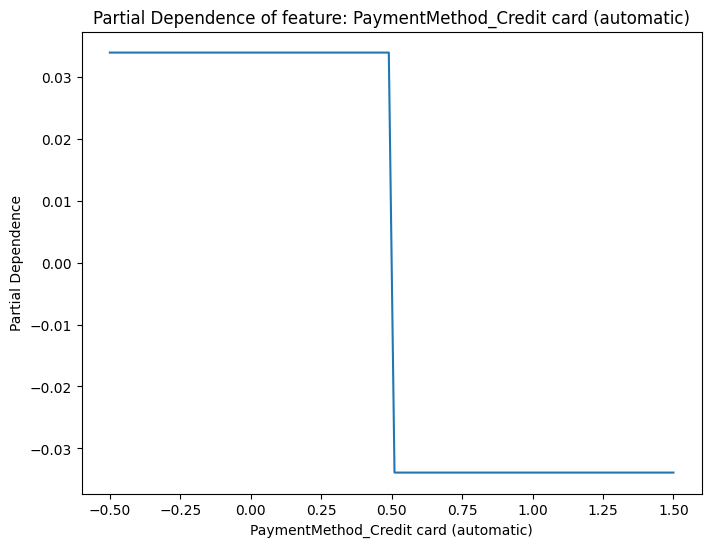

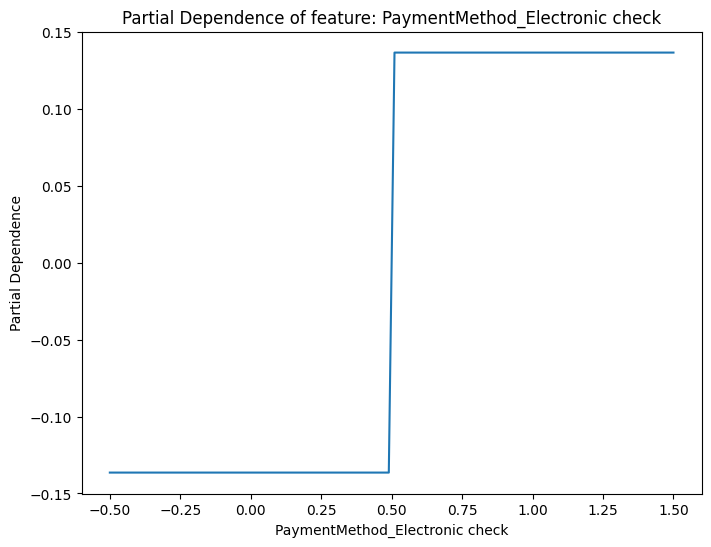

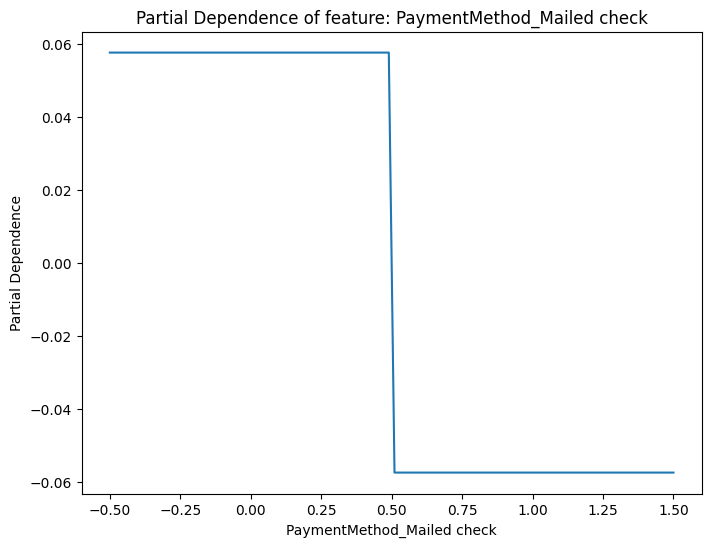

In [61]:
# Step 1: Define numerical and categorical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                   'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                   'PaperlessBilling', 'PaymentMethod']

# Step 2: Apply OneHotEncoder with drop='first' to avoid multicollinearity
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Create a new dataframe with encoded variables
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names)

# Combine encoded categorical variables with numerical variables
combined_df = pd.concat([df[numerical_cols], encoded_df, df['Churn']], axis=1)

# Prepare feature matrix X and target variable y
X = combined_df.drop('Churn', axis=1)
y = combined_df['Churn']

# Step 3: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Build the GAM model using smooth functions for numerical variables
# and factor functions for encoded categorical variables
gam_formula = s(0) + s(1) + s(2)  # Smooth terms for the numerical variables

# Dynamically add the encoded categorical terms
for i in range(len(numerical_cols), X.shape[1]):
    gam_formula += f(i)

# Fit the model with both numerical and categorical terms on the training set
gam = LogisticGAM(gam_formula).fit(X_train, y_train)

# Step 5: View the model summary
print(gam.summary())  # Show the usual summary

# Step 6: Map f(i) terms to the original categorical variable names
# Combine numerical and encoded feature names
feature_names = numerical_cols + list(encoded_feature_names)

# Print mapping between f(i) and feature names
print("\nFeature Mapping:")
for i, feature_name in enumerate(feature_names):  # Corrected: start from f(0)
    print(f"f({i}) corresponds to feature: '{feature_name}'")

# Step 7: Predict on the test set and evaluate the model
y_pred = gam.predict(X_test)

# Step 8: Visualize the smooth functions for each numerical and categorical feature
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)

    # Visualize only smooth functions for numerical features
    plt.figure(figsize=(8, 6))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f"Partial Dependence of feature: {feature_names[i]}")
    plt.xlabel(feature_names[i])
    plt.ylabel("Partial Dependence")
    plt.show()


This Logistic Generalized Additive Model (GAM) shows that several factors significantly influence customer churn. The model explains about 30.13% of the data's variance (Pseudo R-squared = 0.3013). Key findings include that longer contracts (one-year and two-year) are associated with a lower likelihood of churn, while lack of services such as online security, device protection, and tech support significantly increases the probability of churn. Moreover, customers using fiber optic internet and multiple phone lines show higher churn rates. In contrast, tenure (time with the company) has a nonlinear but significant impact on reducing churn probability over time. Not all factors, such as MonthlyCharges and gender, significantly affect churn according to this model.

5. Compariosn

Linear regression is simple to understand, but in this case difficult to interpret for Churn is a binary variable. Also it would have problem with multicolinearity problem if simple use linear regression, but can be better if use lasso or ridge.

Logistic regression makes Churn explainable, and can identify positive or negative correlation base on coefficient while spot the factor that is more influencial. On the other hand, it captures only linear relationship, which is not sufficient in complex case. It's limited by multicolinearity problem.

GAM also solve the binary category problem, and allow non-linear relationship between variables. It also has the highest R-Square, which means it explain the data better. But compare to logistic, it's not direct or obvious in finding positive or negative correlation, or how influencial those factors can be. But still, its trend can still be observed with smooth curves.

In this case, I would recommend the company to choose GAM, since it can explain the data better while make the binary variable make sense. But still, other two may contribute to the understanding of correlation or influences those factors have.